In [1]:
import os
import sys
import absl
import json
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from time import time
from numba import njit
from sklearn.decomposition import PCA
import h5py
import plotly.express as px

parentDir = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
sys.path.append(os.path.join(parentDir, "general_utils"))
import file_management
sys.path.append(os.path.join(parentDir, "billeh_model_utils"))
import other_billeh_utils

mpl.style.use('default')
np.random.seed(3000)

In [2]:
source_area = 'VISp'; target_area = 'VISl'; hemisphere = 'right'
patch_name = f'{source_area}_{target_area}'
# Get the whole cortex model from the BlueBrain project and extract only the regions of interest
# Load node information from the BlueBrain project model
path_to_csv ='Data/cortex_node_types.csv'
node_types = pd.read_csv(path_to_csv, sep=' ')

# Focus on one hemisphere and select source
hemisphere_nodes = node_types.loc[node_types['hemisphere']==hemisphere]
source_node_types_mask = hemisphere_nodes['region']==source_area
target_node_types_mask = hemisphere_nodes['region']==target_area
source_node_type_ids = hemisphere_nodes.loc[source_node_types_mask]['node_type_id'].values
target_node_type_ids = hemisphere_nodes.loc[target_node_types_mask]['node_type_id'].values

In [3]:
# Load nodes of the Bbp cortex model
path_to_h5 = 'Data/VISp_VISl_nodes.h5'
node_h5 = h5py.File(path_to_h5, mode='r')

# Extract node_type_ids and get the nodes mask
cortex_node_type_ids = np.array(node_h5['nodes']['VISp_VISl']['node_type_id'])
source_nodes_mask = np.isin(cortex_node_type_ids, source_node_type_ids)
target_nodes_mask = np.isin(cortex_node_type_ids, target_node_type_ids)

In [4]:
allen_id_to_bbp_id = np.array(node_h5['nodes']['VISp_VISl']['allen_id_to_bbp_id']).astype('u4')
bbp_id_to_allen_id = np.array(node_h5['nodes']['VISp_VISl']['bbp_id_to_allen_id']).astype('i4')

In [11]:
n_source_neurons = source_nodes_mask.sum()
source_df = pd.DataFrame()
source_df['node_id'] = allen_id_to_bbp_id[source_nodes_mask]
source_df['x'] = node_h5['nodes'][patch_name]['0']['x'][source_nodes_mask]
source_df['y'] = node_h5['nodes'][patch_name]['0']['y'][source_nodes_mask]
source_df['z'] = node_h5['nodes'][patch_name]['0']['z'][source_nodes_mask]
source_df['Visual_area'] = source_area
source_df = source_df.set_index('node_id')

#source_df.dropna(inplace=True)
source_df

,x,y,z,Visual_area
node_id,,,,
8592275,8500.070671,990.597034,8936.110930,VISp
8592276,9098.710811,1127.792668,9118.440626,VISp
8592277,8428.414221,830.752889,8654.275283,VISp
8592278,9807.832663,1155.635264,8628.500649,VISp
8592279,7844.725075,622.927715,8210.931604,VISp
...,...,...,...,...
8983562,9314.436269,1400.919200,7780.647280,VISp
8983563,9120.404389,1239.671235,7565.060084,VISp
8983564,9422.046995,1660.054676,8104.713477,VISp


In [6]:
percentage_of_selected_neurons = 0.005
tf_indices = np.arange(n_source_neurons)
selected_tf_indices = np.random.choice(tf_indices, size=int(n_source_neurons*percentage_of_selected_neurons), replace=False)
source_subset = source_df.iloc[selected_tf_indices]

In [7]:
edges_df = file_management.load_lzma(f'Source_{source_area}_Target_{target_area}/{source_area}_to_{target_area}_edges_df.lzma')
edges_df['Source_id'] = allen_id_to_bbp_id[edges_df['Source_id']]
edges_df['Target_id'] = allen_id_to_bbp_id[edges_df['Target_id']]
edges_df

,Source_id,Source,Target_id,Target
0,8624668,VISp_L2_e,8161215,VISl_L1_i_Htr3a
1,8624668,VISp_L2_e,8161156,VISl_L1_i_Htr3a
2,8624878,VISp_L2_e,8161131,VISl_L1_i_Htr3a
3,8623409,VISp_L2_e,8161195,VISl_L1_i_Htr3a
4,8627509,VISp_L2_e,8161136,VISl_L1_i_Htr3a
...,...,...,...,...
38661852,8744922,VISp_L2_e,8187711,VISl_L4_e
38661853,8742418,VISp_L2_e,8187994,VISl_L4_e
38661854,8742347,VISp_L2_e,8188454,VISl_L4_e
38661855,8742418,VISp_L2_e,8188772,VISl_L4_e


In [12]:
n_target_neurons = target_nodes_mask.sum()
target_df = pd.DataFrame()
target_df['node_id'] = allen_id_to_bbp_id[target_nodes_mask]
target_df['x'] = node_h5['nodes'][patch_name]['0']['x'][target_nodes_mask]
target_df['y'] = node_h5['nodes'][patch_name]['0']['y'][target_nodes_mask]
target_df['z'] = node_h5['nodes'][patch_name]['0']['z'][target_nodes_mask]
target_df['Visual_area'] = target_area
target_df = target_df.set_index('node_id')
target_df

,x,y,z,Visual_area
node_id,,,,
8161111,9885.848918,1781.105061,9238.365826,VISl
8161112,9301.237960,1578.684083,9423.971513,VISl
8161113,9162.541289,1609.843756,9557.755458,VISl
8161114,9520.393718,1834.875397,9561.739094,VISl
8161115,9429.508106,1630.177622,9458.110141,VISl
...,...,...,...,...
8216922,8509.955391,1986.731489,9198.199545,VISl
8216923,8735.944264,1885.712081,9062.820802,VISl
8216924,8890.313048,2247.276835,9254.254607,VISl


In [8]:
n_target_neurons = target_nodes_mask.sum()
target_df = pd.DataFrame()
target_df['node_id'] = allen_id_to_bbp_id[target_nodes_mask]
target_df['x'] = node_h5['nodes'][patch_name]['0']['x'][target_nodes_mask]
target_df['y'] = node_h5['nodes'][patch_name]['0']['y'][target_nodes_mask]
target_df['z'] = node_h5['nodes'][patch_name]['0']['z'][target_nodes_mask]
target_df['Visual_area'] = target_area
target_df = target_df.set_index('node_id')

#Esto no será necesario luego en el .py
a = dict(zip(edges_df['Target_id'].values, edges_df['Target'].values))
target_df.loc[np.array(list(a.keys())), 'Neuron_type'] = np.array(list(a.values()))
target_df

,x,y,z,Visual_area,Neuron_type
node_id,,,,,
8161111,9885.848918,1781.105061,9238.365826,VISl,NaN
8161112,9301.237960,1578.684083,9423.971513,VISl,VISl_L1_i_Htr3a
8161113,9162.541289,1609.843756,9557.755458,VISl,VISl_L1_i_Htr3a
8161114,9520.393718,1834.875397,9561.739094,VISl,VISl_L1_i_Htr3a
8161115,9429.508106,1630.177622,9458.110141,VISl,VISl_L1_i_Htr3a
...,...,...,...,...,...
8216922,8509.955391,1986.731489,9198.199545,VISl,VISl_L6_e
8216923,8735.944264,1885.712081,9062.820802,VISl,VISl_L6_e
8216924,8890.313048,2247.276835,9254.254607,VISl,VISl_L6_e


In [9]:
percentage_of_selected_neurons = 0.005
tf_indices = np.arange(n_target_neurons)
selected_tf_indices = np.random.choice(tf_indices, size=int(n_target_neurons*percentage_of_selected_neurons), replace=False)
target_subset = target_df.iloc[selected_tf_indices]

In [10]:
#Esto no será necesario luego en el .py
a = dict(zip(edges_df['Source_id'].values, edges_df['Source'].values))
source_df.loc[np.array(list(a.keys())), 'Neuron_type'] = np.array(list(a.values()))
source_df

,x,y,z,Visual_area,Neuron_type
node_id,,,,,
8592275,8500.070671,990.597034,8936.110930,VISp,NaN
8592276,9098.710811,1127.792668,9118.440626,VISp,NaN
8592277,8428.414221,830.752889,8654.275283,VISp,NaN
8592278,9807.832663,1155.635264,8628.500649,VISp,NaN
8592279,7844.725075,622.927715,8210.931604,VISp,NaN
...,...,...,...,...,...
8983562,9314.436269,1400.919200,7780.647280,VISp,NaN
8983563,9120.404389,1239.671235,7565.060084,VISp,NaN
8983564,9422.046995,1660.054676,8104.713477,VISp,NaN


In [11]:
source_df.dropna(inplace=True)
source_df

,x,y,z,Visual_area,Neuron_type
node_id,,,,,
8623069,10056.340290,1362.442117,8474.168424,VISp,VISp_L2_e
8623073,8039.264782,727.489458,8217.312610,VISp,VISp_L2_e
8623074,9616.007324,806.857683,7932.440212,VISp,VISp_L2_e
8623076,9029.974191,661.722854,7874.460227,VISp,VISp_L2_e
8623077,8191.147203,878.643836,8675.630162,VISp,VISp_L2_e
...,...,...,...,...,...
8983542,8303.755566,1227.021795,7637.673419,VISp,VISp_L6_e
8983546,8808.498834,1691.132595,8692.997675,VISp,VISp_L6_e
8983551,9024.761417,1835.552857,8440.067079,VISp,VISp_L6_e


In [14]:
from collections import Counter
def get_population_neurons(array_node_types):
    # Get the number of neurons per population
    counter = dict(Counter(array_node_types))
    keys = ['_'.join(key.split('_')[1:]) for key in counter.keys()]
    all_pop_names = sorted(keys)
    sorted_values = [x for _,x in sorted(zip(keys, counter.values()))]
    counter_df = pd.DataFrame(sorted_values, index=all_pop_names, columns=['# neurons'])
    
    return counter_df

In [22]:
c = get_population_neurons(source_df['Neuron_type'])
c

,# neurons
L2_e,24298
L4_e,15302
L5_e,6197
L6_e,17281


In [23]:
c.index = 'VISp_' + c.index.astype(str)
c

,# neurons
VISp_L2_e,24298
VISp_L4_e,15302
VISp_L5_e,6197
VISp_L6_e,17281


In [19]:
c.loc['L2_e']

# neurons    0.000123
Name: L2_e, dtype: float64

In [10]:
# Density estimation
def neuron_types_planar_density(neurons_df, shape_estimator='parallelepiped', center_cylinder_radius=175, side_length=175):
    # Get the center of the area
    center_coordinates = neurons_df.loc[:, ['x', 'y', 'z']].mean(axis=0)
    neurons_df.loc[:, 'Distance_to_center'] = np.sqrt(((neurons_df[['x', 'y', 'z']]-center_coordinates)**2).sum(axis=1))
    all_closest_neurons = neurons_df.sort_values(['Distance_to_center']).groupby('Neuron_type', sort=False).head(100)
    # use excitatory neurons to determine the depth and planar coordinates
    exc_pops = [f'{target_area}_L2_e', f'{target_area}_L4_e', f'{target_area}_L5_e', f'{target_area}_L6_e']
    exc_closest_neurons = all_closest_neurons.loc[all_closest_neurons['Neuron_type'].isin(exc_pops)]
    pca=PCA(3)
    pca.fit(exc_closest_neurons[['x', 'y', 'z']])   
    # transform original coordinates to the new pca coordinates
    pca_center_coordinates = pca.transform([center_coordinates])[0]
    neurons_df.loc[:, ['x_trans', 'y_trans', 'z_trans']] = pca.transform(neurons_df[['x', 'y', 'z']])

    if shape_estimator == 'parallelepiped':
        neurons_df.loc[:, ['y_trans', 'z_trans']] -= np.array([pca_center_coordinates[1], pca_center_coordinates[2]])
        mask_y = np.abs(neurons_df.loc[:, 'y_trans']) < side_length
        mask_z = np.abs(neurons_df.loc[:, 'z_trans']) < side_length
        mask = np.logical_and(mask_y, mask_z)
        planar_area = side_length**2
    elif shape_estimator == 'cylinder':
        neurons_df.loc[:, 'planar_intersomatic_distance'] = np.sqrt(((neurons_df[['y_trans', 'z_trans']]-np.array([pca_center_coordinates[1], pca_center_coordinates[2]]))**2).sum(axis=1))
        # isolate the neurons located inside a cylinder around the center
        mask = neurons_df.loc[:, 'planar_intersomatic_distance'] < center_cylinder_radius
        planar_area = np.pi*center_cylinder_radius**2

    neurons_df = neurons_df.loc[mask]
    # count neurons of every type and estimate their densities
    n_neurons_in_area = neurons_df[['Neuron_type', 'Distance_to_center']].groupby('Neuron_type').count()
    planar_density = dict()
    for neuron_type, n_cylinder in zip(list(n_neurons_in_area.index), n_neurons_in_area.values):
        planar_density[neuron_type] = n_cylinder[0]/planar_area
        
    return planar_density

In [11]:
planar_density = neuron_types_planar_density(target_df)
planar_density

{'VISl_L1_i_Htr3a': 0.003526530612244898,
 'VISl_L2_e': 0.07095510204081633,
 'VISl_L2_i_Htr3a': 0.004375510204081633,
 'VISl_L2_i_Pvalb': 0.001142857142857143,
 'VISl_L2_i_Sst': 0.0011102040816326532,
 'VISl_L4_e': 0.05658775510204082,
 'VISl_L4_i_Htr3a': 0.0011102040816326532,
 'VISl_L4_i_Pvalb': 0.0004897959183673469,
 'VISl_L4_i_Sst': 0.0005877551020408164,
 'VISl_L5_e': 0.05015510204081633,
 'VISl_L5_i_Htr3a': 0.002383673469387755,
 'VISl_L5_i_Pvalb': 0.0009142857142857143,
 'VISl_L5_i_Sst': 0.0013061224489795918,
 'VISl_L6_e': 0.1117061224489796,
 'VISl_L6_i_Htr3a': 0.0007836734693877551,
 'VISl_L6_i_Pvalb': 0.0003918367346938776,
 'VISl_L6_i_Sst': 0.0008163265306122449}

In [12]:
edges_df.loc[:, ['x_target', 'y_target', 'z_target']] = target_df.loc[edges_df['Target_id'], ['x', 'y', 'z']].values
edges_df

,Source_id,Source,Target_id,Target,x_target,y_target,z_target
0,8624668,VISp_L2_e,8161215,VISl_L1_i_Htr3a,9301.708303,1493.350343,9325.162706
1,8624668,VISp_L2_e,8161156,VISl_L1_i_Htr3a,9183.515173,1490.031367,9392.563837
2,8624878,VISp_L2_e,8161131,VISl_L1_i_Htr3a,9249.099005,1579.817803,9451.942567
3,8623409,VISp_L2_e,8161195,VISl_L1_i_Htr3a,8583.266541,1277.412900,9355.869785
4,8627509,VISp_L2_e,8161136,VISl_L1_i_Htr3a,9639.551674,1842.048003,9494.470198
...,...,...,...,...,...,...,...
38661852,8744922,VISp_L2_e,8187711,VISl_L4_e,9003.762095,1710.684741,9170.987745
38661853,8742418,VISp_L2_e,8187994,VISl_L4_e,9381.614992,1909.596445,9244.497147
38661854,8742347,VISp_L2_e,8188454,VISl_L4_e,8579.650152,1571.086391,9152.143952
38661855,8742418,VISp_L2_e,8188772,VISl_L4_e,9480.521449,1949.699291,9312.349989


In [13]:
a = edges_df[['Source_id', 'x_target', 'y_target', 'z_target']].loc[edges_df['Source_id']==8683756]
a

,Source_id,x_target,y_target,z_target
682459,8683756,9265.417847,1673.989883,9529.589428
810567,8683756,9367.534424,1661.997341,9409.708761
998676,8683756,9236.504567,1705.412239,9492.707667
998681,8683756,9266.143935,1692.450289,9521.868326
998682,8683756,9252.163318,1695.088332,9503.808186
...,...,...,...,...
37832139,8683756,9147.792660,1841.190193,9332.652125
37832144,8683756,9178.020444,1779.061148,9201.778158
37832184,8683756,9210.668466,1855.156297,9275.935612
37832209,8683756,9224.223007,1712.702417,9196.871644


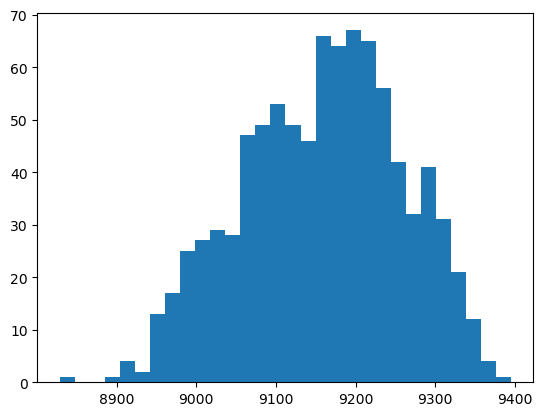

In [14]:
plt.hist(a['x_target'], bins=30)
plt.show()

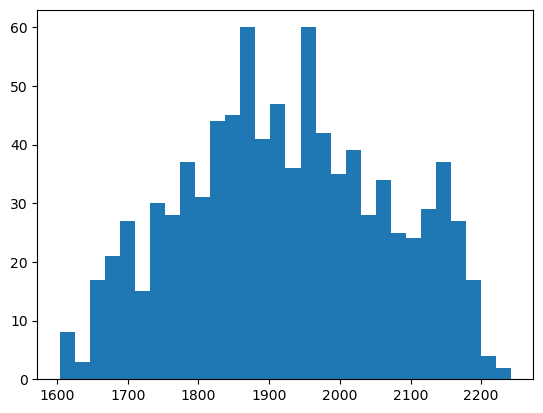

In [15]:
plt.hist(a['y_target'], bins=30)
plt.show()

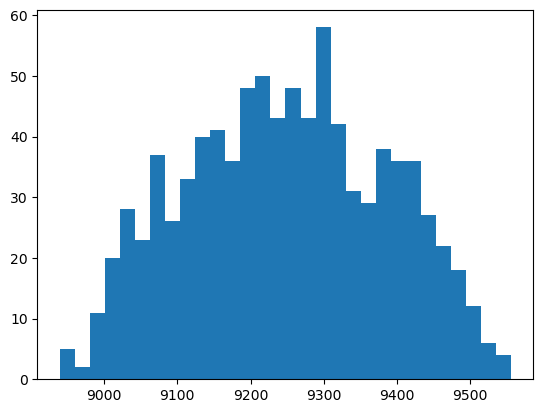

In [16]:
plt.hist(a['z_target'], bins=30)
plt.show()

In [17]:
std_prediction = edges_df[['Source_id', 'x_target', 'y_target', 'z_target']].groupby(['Source_id'], sort=False).std()
std_prediction

,x_target,y_target,z_target
Source_id,,,
8624668,95.051507,166.287475,127.842934
8624878,101.037550,158.198684,147.479728
8623409,49.895343,135.402996,113.142633
8627509,128.603781,152.235814,150.286430
8624882,101.376221,150.488633,146.985140
...,...,...,...
8663413,63.989208,24.792081,38.035708
8925987,NaN,NaN,NaN
8732112,NaN,NaN,NaN


In [18]:
std_prediction.mean(axis=0)

x_target     88.534633
y_target    137.700167
z_target    126.465059
dtype: float64

In [19]:
projected_source_positions = edges_df[['Source_id', 'x_target', 'y_target', 'z_target']].groupby(['Source_id'], sort=False).median()
projected_source_positions

,x_target,y_target,z_target
Source_id,,,
8624668,9090.704821,1718.956176,9121.655089
8624878,9088.653608,1806.430607,9313.622758
8623409,8561.358640,1392.786027,9225.540806
8627509,9427.734638,2090.868698,9271.280009
8624882,8763.416068,1835.598728,9262.847327
...,...,...,...
8663413,9097.198600,1673.333923,9116.561841
8925987,8963.251552,1955.758139,9517.130203
8732112,8895.836184,1623.262423,9081.356874


In [20]:
source_connected_neurons_df = source_df.loc[projected_source_positions.index]
source_connected_neurons_df

,x,y,z,Visual_area
Source_id,,,,
8624668,9248.455449,1134.637362,8853.299707,VISp
8624878,9370.604774,965.628291,8351.587968,VISp
8623409,7962.683096,759.896390,8444.115233,VISp
8627509,9979.398302,1220.256841,8281.162051,VISp
8624882,8840.683805,739.760909,8172.522524,VISp
...,...,...,...,...
8663413,9191.504652,1323.321002,9043.205604,VISp
8925987,8873.159377,1194.846208,7656.934081,VISp
8732112,8891.905748,1262.279965,9057.546202,VISp


In [21]:
#Esto no será necesario luego en el .py
a = dict(zip(edges_df['Source_id'].values, edges_df['Source'].values))
source_connected_neurons_df.loc[np.array(list(a.keys())), 'Neuron_type'] = np.array(list(a.values()))

In [22]:
source_connected_central_neurons_df = source_connected_neurons_df.copy()
center_coordinates = source_connected_central_neurons_df.loc[:, ['x', 'y', 'z']].mean(axis=0)
source_connected_central_neurons_df.loc[:, 'Distance_to_center'] = np.sqrt(((source_connected_central_neurons_df[['x', 'y', 'z']]-center_coordinates)**2).sum(axis=1))
all_closest_neurons = source_connected_central_neurons_df.sort_values(['Distance_to_center']).groupby('Neuron_type', sort=False).head(100)
# use excitatory neurons to determine the depth and planar coordinates
exc_pops = [f'{source_area}_L2_e', f'{source_area}_L4_e', f'{source_area}_L5_e', f'{source_area}_L6_e']
exc_closest_neurons = all_closest_neurons.loc[all_closest_neurons['Neuron_type'].isin(exc_pops)]
pca=PCA(3)
pca.fit(exc_closest_neurons[['x', 'y', 'z']])   
# transform original coordinates to the new pca coordinates
pca_center_coordinates = pca.transform([center_coordinates])[0]
source_connected_central_neurons_df.loc[:, ['x_trans', 'y_trans', 'z_trans']] = pca.transform(source_connected_central_neurons_df[['x', 'y', 'z']])
source_connected_central_neurons_df.loc[:, 'planar_intersomatic_distance'] = np.sqrt(((source_connected_central_neurons_df[['y_trans', 'z_trans']]-np.array([pca_center_coordinates[1], pca_center_coordinates[2]]))**2).sum(axis=1))
mask = source_connected_central_neurons_df.loc[:, 'planar_intersomatic_distance'] < 300
source_connected_central_neurons_df = source_connected_central_neurons_df.loc[mask]

In [23]:
source_connected_central_neurons_df

,x,y,z,Visual_area,Neuron_type,Distance_to_center,x_trans,y_trans,z_trans,planar_intersomatic_distance
Source_id,,,,,,,,,,
8624878,9370.604774,965.628291,8351.587968,VISp,VISp_L2_e,403.177856,-339.381161,228.107283,38.590666,237.863031
8627307,9015.452432,869.207133,8340.618712,VISp,VISp_L2_e,390.337753,-371.638283,-105.220020,-114.389519,156.037757
8623782,8951.302705,966.311171,8534.562681,VISp,VISp_L2_e,422.429231,-368.332254,-226.907842,76.240461,229.750937
8626218,9323.269423,856.468377,8188.569296,VISp,VISp_L2_e,449.980035,-352.854230,234.408704,-162.681235,295.896966
8625010,9129.681448,863.164904,8364.232177,VISp,VISp_L2_e,396.153594,-403.038546,-3.473510,-66.389065,73.934631
...,...,...,...,...,...,...,...,...,...,...
8927086,8770.757745,1514.171288,8092.896418,VISp,VISp_L6_e,451.114231,340.528101,-274.175882,-75.743114,279.147817
8957861,8786.349408,1501.679883,8097.320197,VISp,VISp_L6_e,430.835540,325.471584,-260.451893,-73.830414,265.486868
8977243,9190.296226,1503.094033,7909.381040,VISp,VISp_L6_e,438.071037,360.600782,181.407575,-118.800500,227.368258


In [24]:
central_source_edges_df = edges_df.loc[edges_df['Source_id'].isin(source_connected_central_neurons_df.index)]
central_source_edges_df

,Source_id,Source,Target_id,Target,x_target,y_target,z_target
2,8624878,VISp_L2_e,8161131,VISl_L1_i_Htr3a,9249.099005,1579.817803,9451.942567
8,8627307,VISp_L2_e,8161231,VISl_L1_i_Htr3a,8994.222825,1408.142326,9376.649431
10,8623782,VISp_L2_e,8161207,VISl_L1_i_Htr3a,9021.765542,1448.394013,9457.610486
19,8626218,VISp_L2_e,8161134,VISl_L1_i_Htr3a,9114.910096,1653.293331,9581.880961
20,8626218,VISp_L2_e,8161153,VISl_L1_i_Htr3a,9161.072035,1711.657160,9600.228564
...,...,...,...,...,...,...,...
38661831,8904879,VISp_L5_e,8189231,VISl_L4_e,9008.037148,1609.948909,9220.859659
38661832,8904879,VISp_L5_e,8189221,VISl_L4_e,9087.773082,1663.193396,9186.529729
38661833,8904879,VISp_L5_e,8189200,VISl_L4_e,9023.498753,1777.583268,9314.297172
38661852,8744922,VISp_L2_e,8187711,VISl_L4_e,9003.762095,1710.684741,9170.987745


In [25]:
targets_ids = set(list(central_source_edges_df['Target_id']))
len(targets_ids)

34204

In [26]:
des = central_source_edges_df[['Source', 'Target', 'Source_id']].groupby(['Source', 'Target']).count()
print(des.to_string())

                           Source_id
Source    Target                    
VISp_L2_e VISl_L1_i_Htr3a       7049
          VISl_L2_e           484122
          VISl_L2_i_Htr3a      16984
          VISl_L2_i_Pvalb       9999
          VISl_L2_i_Sst         6359
          VISl_L4_e           379623
          VISl_L4_i_Htr3a       6844
          VISl_L4_i_Pvalb       3468
          VISl_L4_i_Sst         2021
          VISl_L5_e           540734
          VISl_L5_i_Htr3a      14067
          VISl_L5_i_Pvalb       6001
          VISl_L5_i_Sst         7679
          VISl_L6_e           310739
          VISl_L6_i_Htr3a       3741
          VISl_L6_i_Pvalb       1922
          VISl_L6_i_Sst         4051
VISp_L4_e VISl_L1_i_Htr3a       3949
          VISl_L2_e           292689
          VISl_L2_i_Htr3a      10517
          VISl_L2_i_Pvalb       5654
          VISl_L2_i_Sst         3844
          VISl_L4_e           227246
          VISl_L4_i_Htr3a       3700
          VISl_L4_i_Pvalb       2096
 

In [27]:
percentage_of_selected_neurons

0.005

In [28]:
percentage_of_selected_neurons = 0.1
tf_indices = np.arange(len(source_connected_central_neurons_df))
selected_tf_indices = np.random.choice(tf_indices, size=int(len(source_connected_central_neurons_df)*percentage_of_selected_neurons), replace=False)
source_connected_central_neurons_subset = source_connected_central_neurons_df.iloc[selected_tf_indices]

In [29]:
target_connected_central_neurons_df = target_df.loc[(target_df.index).isin(targets_ids)]
tf_indices = np.arange(len(target_connected_central_neurons_df))
selected_tf_indices = np.random.choice(tf_indices, size=int(len(target_connected_central_neurons_df)*percentage_of_selected_neurons), replace=False)
target_connected_central_neurons_subset = target_connected_central_neurons_df.iloc[selected_tf_indices]

In [30]:
# df_pred = pd.DataFrame(columns=target_df.columns)
# df1 = target_df.loc[np.isin(target_df.index, edges_df['Target_id'].loc[edges_df['Source_id']==sid])]
# df2 = source_df.loc[source_df.index==sid]
# location_prediction = model.predict(x_scaler.transform(df2[['x', 'y', 'z']]))
# df_pred[['x', 'y', 'z']] = location_prediction
# df_pred['Visual_area'] = f'{target_area} prediction'
# df_pred['marker_size'] = 10
# df1 = df1.assign(Visual_area = f'{target_area} targets')
# df2 = df2.assign(Visual_area = f'{source_area} source')
# df1 = df1.assign(marker_size = 2)
# df2 = df2.assign(marker_size = 10)
source_subset = source_subset.assign(marker_size = 1)
target_subset = target_subset.assign(marker_size = 1)
source_connected_central_neurons_subset = source_connected_central_neurons_subset.assign(marker_size = 0.5)
target_connected_central_neurons_subset = target_connected_central_neurons_subset.assign(marker_size = 0.5)
# average_targets = pd.DataFrame(df1.mean(axis=0)).transpose()
# average_targets = average_targets.assign(marker_size = 10)
# average_targets = average_targets.assign(Visual_area = f'{target_area} average targets position')
source_connected_central_neurons_subset = source_connected_central_neurons_subset.assign(Visual_area = f'Central {source_area} source')
target_connected_central_neurons_subset = target_connected_central_neurons_subset.assign(Visual_area = f'Connected {target_area} target')

representation_df = pd.concat([source_subset, target_subset, source_connected_central_neurons_subset, target_connected_central_neurons_subset], ignore_index=True, sort=False)
fig = px.scatter_3d(representation_df, x='x', y='y', z='z', 
                    color='Visual_area', size='marker_size',
                    opacity=0.7)

#fig.update_traces(marker_size = 2)
fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0)) #, scene_camera=camera)
fig.write_html(f"Central_{source_area}_and_connected_{target_area}_neurons.html")

In [31]:
source_filter = edges_df[['Source_id','Target_id']].groupby(['Source_id'], sort=False).count()
source_filter_indices = source_filter.loc[source_filter['Target_id']>30].index # to reduce computation cost
source_filter_indices

UInt64Index([8624668, 8624878, 8623409, 8627509, 8624882, 8626112, 8624049,
             8627307, 8623782, 8627512,
             ...
             8970503, 8978262, 8970336, 8929025, 8911610, 8962905, 8978521,
             8945523, 8918766, 8910353],
            dtype='uint64', name='Source_id', length=56534)

In [32]:
hub_source_positions = projected_source_positions.loc[source_filter_indices]
hub_source_positions

,x_target,y_target,z_target
Source_id,,,
8624668,9090.704821,1718.956176,9121.655089
8624878,9088.653608,1806.430607,9313.622758
8623409,8561.358640,1392.786027,9225.540806
8627509,9427.734638,2090.868698,9271.280009
8624882,8763.416068,1835.598728,9262.847327
...,...,...,...
8962905,9359.048483,2176.093355,8876.985241
8978521,8472.696827,1834.211313,8930.136875
8945523,8479.156215,1851.190184,8957.569851


In [33]:
std_prediction = std_prediction.loc[source_filter_indices]
std_prediction

,x_target,y_target,z_target
Source_id,,,
8624668,95.051507,166.287475,127.842934
8624878,101.037550,158.198684,147.479728
8623409,49.895343,135.402996,113.142633
8627509,128.603781,152.235814,150.286430
8624882,101.376221,150.488633,146.985140
...,...,...,...
8962905,42.039042,51.631672,61.792639
8978521,42.006970,46.330332,45.259653
8945523,30.832162,44.051000,46.091352


In [34]:
std_prediction.mean(axis=0)

x_target     90.472978
y_target    140.367642
z_target    129.001262
dtype: float64

In [35]:
np.sqrt((std_prediction.mean(axis=0)**2).sum())

211.02075842126024

In [36]:
hub_source_df = source_df.loc[(source_df.index).isin(hub_source_positions.index)]
hub_source_df

,x,y,z,Visual_area
node_id,,,,
8623069,10056.340290,1362.442117,8474.168424,VISp
8623073,8039.264782,727.489458,8217.312610,VISp
8623074,9616.007324,806.857683,7932.440212,VISp
8623076,9029.974191,661.722854,7874.460227,VISp
8623077,8191.147203,878.643836,8675.630162,VISp
...,...,...,...,...
8983541,8575.553304,1567.776978,8535.693665,VISp
8983542,8303.755566,1227.021795,7637.673419,VISp
8983551,9024.761417,1835.552857,8440.067079,VISp


In [37]:
hub_source_df.loc[:, ['x_projected', 'y_projected', 'z_projected']] = hub_source_positions.loc[hub_source_df.index, ['x_target', 'y_target', 'z_target']].values
hub_source_df.dropna(axis=0, inplace=True)
# hub_source_df.drop('Visual_area', axis=1, inplace=True)
hub_source_df
# source_df = source_df.drop('Visual_area', axis=1)
# target_df = target_df.drop('Visual_area', axis=1)

<ipython-input-37-92e7d510dcf7>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-37-92e7d510dcf7>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,x,y,z,Visual_area,x_projected,y_projected,z_projected
node_id,,,,,,,
8623069,10056.340290,1362.442117,8474.168424,VISp,9454.346605,2016.298415,9245.990140
8623073,8039.264782,727.489458,8217.312610,VISp,8558.832626,1565.708593,9284.425491
8623074,9616.007324,806.857683,7932.440212,VISp,9146.685818,2033.155165,9432.251063
8623076,9029.974191,661.722854,7874.460227,VISp,8841.314718,1869.895192,9472.037757
8623077,8191.147203,878.643836,8675.630162,VISp,8575.847255,1523.348707,9121.424002
...,...,...,...,...,...,...,...
8983541,8575.553304,1567.776978,8535.693665,VISp,8697.603544,1817.840397,8922.221612
8983542,8303.755566,1227.021795,7637.673419,VISp,8561.583251,1871.856102,9236.841725
8983551,9024.761417,1835.552857,8440.067079,VISp,9023.189553,1976.012165,8943.017893


## Neural network mapping

In [259]:
def euclidean_distance_loss(y_true, y_pred):
    square_deviation = tf.math.square(y_true - y_pred)
    euclidean_distance = tf.math.reduce_sum(square_deviation, axis=1)
    return tf.math.reduce_mean(euclidean_distance)

In [260]:
def euclidean_distance_metric(y_true, y_pred):
    square_deviation = tf.math.square(y_true - y_pred)
    euclidean_distance = tf.math.sqrt(tf.math.reduce_sum(square_deviation, axis=1))
    return tf.math.reduce_mean(euclidean_distance)

def mae_metric(y_true, y_pred):
    abs_deviation = tf.math.abs(y_true - y_pred)
    return tf.math.reduce_mean(abs_deviation)

def rsme_metric(y_true, y_pred):
    square_deviation = tf.math.square(y_true - y_pred)
    return tf.math.sqrt(tf.math.reduce_mean(square_deviation))

In [261]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def get_model():
    model = Sequential()
    model.add(Dense(128, input_shape = (3, ), kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dense(64, kernel_initializer='glorot_uniform'))
    model.add(LeakyReLU(alpha=0.3)) # activation layer here instead 
    model.add(Dense(32, kernel_initializer='glorot_uniform'))
    model.add(LeakyReLU(alpha=0.3)) # activation layer here instead 
    model.add(Dense(16, kernel_initializer='glorot_uniform'))
    model.add(LeakyReLU(alpha=0.3)) # activation layer here instead 
    model.add(Dense(8, kernel_initializer='glorot_uniform'))
    model.add(LeakyReLU(alpha=0.3)) # activation layer here instead 
    model.add(Dense(3, kernel_initializer='glorot_uniform')) # no activation required for linear regression in the output layer
#     model.compile(loss=euclidean_distance_loss, optimizer='adam', metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae"), tf.keras.metrics.RootMeanSquaredError(name='rmse'), euclidean_distance_metric])
    model.compile(loss=euclidean_distance_loss, optimizer='adam', metrics=[euclidean_distance_metric])

    return model

In [262]:
X = hub_source_df[['x', 'y', 'z']].values
y = hub_source_df[['x_projected', 'y_projected', 'z_projected']].values
n_inputs, n_outputs = X.shape[1], y.shape[1]

In [263]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# scaler
# x_scaler = MinMaxScaler().fit(X_train)
# X_train_scaled = x_scaler.transform(X_train)
# X_test_scaled = x_scaler.transform(X_test)

In [291]:
from tensorflow.keras.callbacks import Callback, CSVLogger
from timeit import default_timer as timer

class MyCallback(Callback):
    def __init__(self, monitor='val_loss', value=50, verbose=1, patience=1000):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
        self.patience=patience  
        self.starttime = timer()
        # best_weights para almacenar los pesos en los cuales ocurre la perdida minima.
        self.best_weights = None
        
    def on_train_begin(self, logs=None):
        # El numero de epoch que ha esperado cuando la perdida ya no es minima.
        self.wait = 0
        # Initialize el best como infinito.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs={}):
        if epoch%2 == 0:
            elapsed_time = float(timer()-self.starttime)
            self.starttime = timer()
            print('Epoch {}/{} - Elapsed_time: {:3.2f} s - Train loss: {:7.2f} - Train EUD {:7.2f} - Val loss: {:7.2f} - Val EUD: {:7.2f}.'.format(
                epoch+1, self.params.get('epochs'), elapsed_time, logs['loss'], logs['euclidean_distance_metric'], logs['val_loss'], logs['val_euclidean_distance_metric']))
            
        current = logs.get(self.monitor)   
        if np.less(current, self.best):
            self.best = current
            # Guardar los mejores pesos si el resultado actual es mejor (menos).
            self.best_weights = self.model.get_weights()
        
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
                
            elapsed_time = float(timer()-self.starttime)
            print('Epoch {}/{} - Elapsed_time: {:3.2f} s - Train loss: {:7.2f} - Train EUD {:7.2f} - Val loss: {:7.2f} - Val EUD: {:7.2f}.'.format(
                epoch+1, self.params.get('epochs'), elapsed_time, logs['loss'], logs['euclidean_distance_metric'], logs['val_loss'], logs['val_euclidean_distance_metric']))

            self.model.stop_training = True   
            
            
        if ((epoch+1) == self.params.get('epochs')) and (epoch%2 != 0):
            elapsed_time = float(timer()-self.starttime)
            print('Epoch {}/{} - Elapsed_time: {:3.2f} s - Train loss: {:7.2f} - Train EUD {:7.2f} - Val loss: {:7.2f} - Val EUD: {:7.2f}.'.format(
                epoch+1, self.params.get('epochs'), elapsed_time, logs['loss'], logs['euclidean_distance_metric'], logs['val_loss'], logs['val_euclidean_distance_metric']))
    
    def on_train_end(self, epoch, logs={}):
        
        print('Restaurando los pesos del modelo del final de la mejor epoch.')
        self.model.set_weights(self.best_weights)        
               
filename = 'history.csv'
callbacks = [
    MyCallback(monitor='val_euclidean_distance_metric', value=10, verbose=1),
    CSVLogger(filename, append=False)
#     EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000)
]

In [292]:
import io
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import load_model
import h5py

class PickleablePipeline(Pipeline):

    def _pickle_steps(self):
        steps = self.steps[:]
        classifier = steps[-1][1]
        bio = io.BytesIO()
        with h5py.File(bio) as f:
            classifier.model.save(f)
        steps[-1] = (steps[-1][0], bio)
        return steps

    def _unpickle_steps(self, steps):
        with h5py.File(steps[-1][1]) as f:
            steps[-1] = (steps[-1][0], load_model(f, custom_objects={'euclidean_distance_loss': euclidean_distance_loss,
                                                                    'euclidean_distance_metric': euclidean_distance_metric}))
        return steps

    def __getstate__(self):
        state = super(PickleablePipeline, self).__getstate__()
        state['steps'] = self._pickle_steps()
        return state

    def __setstate__(self, state):
        state['steps'] = self._unpickle_steps(state['steps'])
        return super(PickleablePipeline, self).__setstate__(state)

In [293]:
# Create pipeline
from sklearn.pipeline import Pipeline
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

regressorNN = KerasRegressor(build_fn= get_model, epochs=100, batch_size=128, 
                             verbose=0)

pipe = PickleablePipeline([
('scaler', MinMaxScaler()),
('regressor', regressorNN)
])

# pipe = Pipeline([
# ('scaler', MinMaxScaler()),
# ('regressor', regressorNN)
# ])

In [294]:
pipe[:-1].fit(X_train)

PickleablePipeline(steps=[('scaler', MinMaxScaler())])

In [295]:
pipe.fit(X_train, y_train, regressor__validation_data=(pipe[:-1].transform(X_test), y_test), regressor__callbacks=callbacks)

dict_keys(['loss', 'euclidean_distance_metric', 'val_loss', 'val_euclidean_distance_metric'])
Epoch 1/100 - Elapsed_time: 4.75 s - Train loss: 54338552.00 - Train EUD 5388.02 - Val loss: 3357937.00 - Val EUD: 1542.37.
dict_keys(['loss', 'euclidean_distance_metric', 'val_loss', 'val_euclidean_distance_metric'])
Epoch 3/100 - Elapsed_time: 2.65 s - Train loss: 277362.19 - Train EUD  452.73 - Val loss: 126320.72 - Val EUD:  328.27.
dict_keys(['loss', 'euclidean_distance_metric', 'val_loss', 'val_euclidean_distance_metric'])
Epoch 5/100 - Elapsed_time: 2.66 s - Train loss: 96737.09 - Train EUD  287.82 - Val loss: 98203.30 - Val EUD:  290.12.
dict_keys(['loss', 'euclidean_distance_metric', 'val_loss', 'val_euclidean_distance_metric'])
Epoch 7/100 - Elapsed_time: 2.70 s - Train loss: 96411.19 - Train EUD  287.62 - Val loss: 98194.33 - Val EUD:  290.06.
dict_keys(['loss', 'euclidean_distance_metric', 'val_loss', 'val_euclidean_distance_metric'])
Epoch 9/100 - Elapsed_time: 2.61 s - Train loss

dict_keys(['loss', 'euclidean_distance_metric', 'val_loss', 'val_euclidean_distance_metric'])
Epoch 79/100 - Elapsed_time: 2.62 s - Train loss: 31591.87 - Train EUD  156.88 - Val loss: 33889.80 - Val EUD:  163.72.
dict_keys(['loss', 'euclidean_distance_metric', 'val_loss', 'val_euclidean_distance_metric'])
Epoch 81/100 - Elapsed_time: 2.64 s - Train loss: 31569.58 - Train EUD  156.87 - Val loss: 31709.76 - Val EUD:  156.69.
dict_keys(['loss', 'euclidean_distance_metric', 'val_loss', 'val_euclidean_distance_metric'])
Epoch 83/100 - Elapsed_time: 2.62 s - Train loss: 31499.46 - Train EUD  156.64 - Val loss: 31888.70 - Val EUD:  157.03.
dict_keys(['loss', 'euclidean_distance_metric', 'val_loss', 'val_euclidean_distance_metric'])
Epoch 85/100 - Elapsed_time: 2.63 s - Train loss: 31509.13 - Train EUD  156.72 - Val loss: 31294.30 - Val EUD:  155.63.
dict_keys(['loss', 'euclidean_distance_metric', 'val_loss', 'val_euclidean_distance_metric'])
Epoch 87/100 - Elapsed_time: 2.69 s - Train loss: 

PickleablePipeline(steps=[('scaler', MinMaxScaler()),
                          ('regressor',
                           <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f210695e1c0>)])

In [300]:
y_pred = pipe.predict(X_test)

In [301]:
'{:3.2f}'.format(float(euclidean_distance_loss(y_test, y_pred)))

'30980.42'

In [302]:
float(euclidean_distance_metric(y_test, y_pred))

154.417213304389

In [303]:
# Use pickle to save model for next usage.
import pickle
filename = 'model_v1.pk'
with open('./'+filename, 'wb') as file:
    pickle.dump(pipe, file) 

<ipython-input-292-6ca5a8920b03>:12: H5pyDeprecationWarning:

The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.



## Error analysis

In [304]:
with open('./'+filename ,'rb') as f:
    loaded_model = pickle.load(f)

<ipython-input-292-6ca5a8920b03>:18: H5pyDeprecationWarning:

The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.



In [305]:
y_pred = loaded_model.predict(hub_source_df.loc[:, ['x', 'y', 'z']].values)

In [306]:
hub_source_df.loc[:, ['x_projected_new', 'y_projected_new', 'z_projected_new']] = y_pred
hub_source_df

,x,y,z,Visual_area,x_projected,y_projected,z_projected,x_projected_new,y_projected_new,z_projected_new,Prediction_error
node_id,,,,,,,,,,,
8849104,8814.798580,1058.291862,8129.458520,VISp,8799.731162,1793.664949,9260.254146,8806.979492,1806.156250,9245.639648,0.907319
8807846,8752.090986,1035.346520,8126.510644,VISp,8760.885381,1776.749806,9259.611252,8771.637695,1790.698730,9245.628906,3.086912
8714643,9896.984659,1296.438456,8305.884771,VISp,9371.318251,2032.780574,9298.847322,9372.091797,2045.202393,9281.103516,3.916647
8758157,9091.382028,888.158902,8129.561202,VISp,8901.746788,1819.878353,9353.479356,8907.153320,1830.155151,9336.865234,4.357757
8959633,9084.164141,1722.985183,8367.796482,VISp,9062.327688,1953.553757,9035.741181,9056.506836,1961.721802,9028.915039,5.647104
...,...,...,...,...,...,...,...,...,...,...,...
8903252,8478.085700,1311.376579,8243.787723,VISp,9082.420552,1909.926896,9594.443418,8717.323242,1790.894165,9132.721680,593.888146
8903664,8480.194587,1306.386160,8265.408430,VISp,9086.517605,1925.347499,9584.111930,8714.958008,1790.062256,9131.457031,595.067291
8904671,8496.617333,1344.482724,8284.586027,VISp,9091.341216,1923.503953,9580.920053,8725.613281,1798.192017,9115.322266,603.454625


In [307]:
y_approx = hub_source_df.loc[:, ['x_projected', 'y_projected', 'z_projected']].values
y_pred = hub_source_df.loc[:, ['x_projected_new', 'y_projected_new', 'z_projected_new']]

error_in_prediction = np.sqrt(((y_approx -y_pred)**2).sum(axis=1))
hub_source_df = hub_source_df.assign(Prediction_error = error_in_prediction)

hub_source_df

,x,y,z,Visual_area,x_projected,y_projected,z_projected,x_projected_new,y_projected_new,z_projected_new,Prediction_error
node_id,,,,,,,,,,,
8849104,8814.798580,1058.291862,8129.458520,VISp,8799.731162,1793.664949,9260.254146,8806.979492,1806.156250,9245.639648,20.546397
8807846,8752.090986,1035.346520,8126.510644,VISp,8760.885381,1776.749806,9259.611252,8771.637695,1790.698730,9245.628906,22.487569
8714643,9896.984659,1296.438456,8305.884771,VISp,9371.318251,2032.780574,9298.847322,9372.091797,2045.202393,9281.103516,21.673547
8758157,9091.382028,888.158902,8129.561202,VISp,8901.746788,1819.878353,9353.479356,8907.153320,1830.155151,9336.865234,20.269983
8959633,9084.164141,1722.985183,8367.796482,VISp,9062.327688,1953.553757,9035.741181,9056.506836,1961.721802,9028.915039,12.132415
...,...,...,...,...,...,...,...,...,...,...,...
8903252,8478.085700,1311.376579,8243.787723,VISp,9082.420552,1909.926896,9594.443418,8717.323242,1790.894165,9132.721680,600.542921
8903664,8480.194587,1306.386160,8265.408430,VISp,9086.517605,1925.347499,9584.111930,8714.958008,1790.062256,9131.457031,601.044997
8904671,8496.617333,1344.482724,8284.586027,VISp,9091.341216,1923.503953,9580.920053,8725.613281,1798.192017,9115.322266,605.178737


In [308]:
hub_source_df.sort_values('Prediction_error', inplace=True)

In [309]:
history = pd.read_csv('history.csv') 
history

,epoch,euclidean_distance_metric,loss,val_euclidean_distance_metric,val_loss
0,0,5388.019043,5.433855e+07,1542.367676,3.357937e+06
1,1,1112.283325,1.833537e+06,709.191467,6.846007e+05
2,2,452.727631,2.773622e+05,328.268646,1.263207e+05
3,3,300.752625,1.059006e+05,291.096130,9.933836e+04
4,4,287.823242,9.673709e+04,290.117828,9.820330e+04
...,...,...,...,...,...
95,95,156.364731,3.137209e+04,154.630356,3.092546e+04
96,96,156.110596,3.131452e+04,155.645599,3.143086e+04
97,97,155.974899,3.125513e+04,155.706451,3.117766e+04
98,98,155.860962,3.123871e+04,155.456970,3.118805e+04


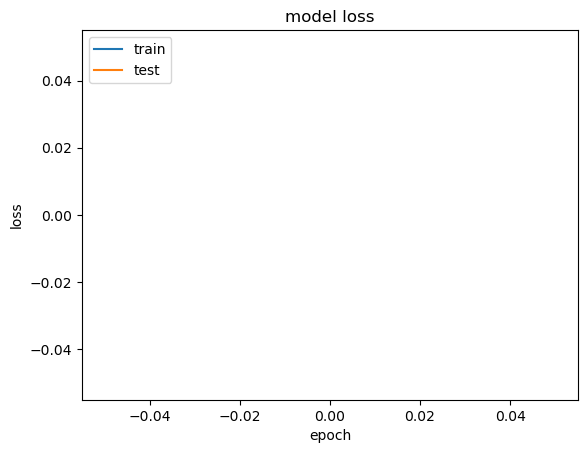

In [310]:
# summarize history for loss
plt.plot(history['euclidean_distance_metric'][100:])
plt.plot(history['val_euclidean_distance_metric'][100:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(os.path.join(prediction_path, 'training_loss_curve.png'), dpi=300)
plt.show()

In [318]:
source_ids = list(hub_source_df.iloc[-10:].index)
# source_ids = list(source_connected_neurons_df.index)

In [319]:
len(source_ids)

10

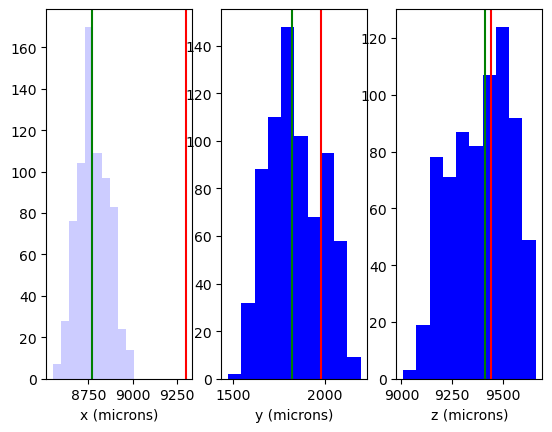

552.7769360226598


In [317]:
sid = source_ids[0]
a = edges_df[['Source_id', 'x_target', 'y_target', 'z_target']].loc[edges_df['Source_id']==sid]
a_median = a.median()
b =  pipe.predict([source_df.loc[sid, ['x', 'y', 'z']].values])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.hist(a['x_target'], color='b', alpha=0.2)
ax1.axvline(x=b[0], color='r')
ax1.axvline(x=a_median['x_target'], color='g')
ax1.set_xlabel('x (microns)')

ax2.hist(a['y_target'], color='b')
ax2.axvline(x=b[1], color='r')
ax2.axvline(x=a_median['y_target'], color='g')
ax2.set_xlabel('y (microns)')

ax3.hist(a['z_target'], color='b')
ax3.axvline(x=b[2], color='r')
ax3.axvline(x=a_median['z_target'], color='g')
ax3.set_xlabel('z (microns)')

plt.show()

print(np.sqrt(((a_median[['x_target', 'y_target', 'z_target']] -b)**2).sum()))

In [316]:
df_pred = pd.DataFrame(index=[sid], columns=target_df.columns)
df1 = target_df.loc[np.isin(target_df.index, edges_df['Target_id'].loc[edges_df['Source_id']==sid])]
df2 = source_df.loc[source_df.index==sid]
location_prediction = pipe.predict(df2[['x', 'y', 'z']])
df_pred[['x', 'y', 'z']] = location_prediction
df_pred['Visual_area'] = f'{target_area} prediction'
df_pred['marker_size'] = 10
df1 = df1.assign(Visual_area = f'{target_area} targets')
df2 = df2.assign(Visual_area = f'{source_area} source')
df1 = df1.assign(marker_size = 2)
df2 = df2.assign(marker_size = 10)
source_subset = source_subset.assign(marker_size = 2)
target_subset = target_subset.assign(marker_size = 2)
average_targets = pd.DataFrame(df1.mean(axis=0)).transpose()
average_targets = average_targets.assign(marker_size = 10)
average_targets = average_targets.assign(Visual_area = f'{target_area} average targets position')

representation_df = pd.concat([source_subset,target_subset,df1, df2, df_pred, average_targets], ignore_index=True, sort=False)
fig = px.scatter_3d(representation_df, x='x', y='y', z='z', 
                    color='Visual_area', size='marker_size',
                    opacity=0.7)

#fig.update_traces(marker_size = 2)
# fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0)) #, scene_camera=camera)

<ipython-input-316-cf5cb559d298>:14: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [194]:
# Path to save results
prediction_path = 'Retinotopic_mapping_pred'
os.makedirs(prediction_path, exist_ok=True)

df_pred = pd.DataFrame(columns=target_df.columns)
for sid in np.random.choice(source_df.index, size=10, replace=False):
    df1 = target_df.loc[np.isin(target_df.index, edges_df['Target_id'].loc[edges_df['Source_id']==sid])]
    df2 = source_df.loc[source_df.index==sid]
    location_prediction = model.predict(x_scaler.transform(df2[['x', 'y', 'z']]))
    df_pred[['x', 'y', 'z']] = location_prediction
    df_pred['Visual_area'] = f'{target_area} prediction'
    df_pred['marker_size'] = 10
    df1 = df1.assign(Visual_area = f'{target_area} targets')
    df2 = df2.assign(Visual_area = f'{source_area} source')
    df1 = df1.assign(marker_size = 2)
    df2 = df2.assign(marker_size = 10)
    source_subset = source_subset.assign(marker_size = 2)
    target_subset = target_subset.assign(marker_size = 2)

    representation_df = pd.concat([source_subset,target_subset,df1, df2, df_pred], ignore_index=True, sort=False)
    fig = px.scatter_3d(representation_df, x='x', y='y', z='z', 
                        color='Visual_area', size='marker_size',
                        opacity=0.7)

    #fig.update_traces(marker_size = 2)
    fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0)) #, scene_camera=camera)
    fig.write_html(os.path.join(prediction_path, f"{source_area}_node_{sid}_to_{target_area}_bbp_model.html"))

model.save(os.path.join(prediction_path, f'saved_models/{source_area}_to_{target_area}_model'))

INFO:tensorflow:Assets written to: Retinotopic_mapping_pred/saved_models/VISp_to_VISl_model/assets


## Obtain projections using NN

In [186]:
location_prediction = model.predict(x_scaler.transform(source_connected_neurons_df[['x', 'y', 'z']]))
source_connected_neurons_df.loc[projected_source_positions.index, ['x_projected', 'y_projected', 'z_projected']] = location_prediction

In [188]:
source_connected_neurons_df

,x,y,z,Visual_area,Neuron_type,x_projected,y_projected,z_projected
Source_id,,,,,,,,
8624668,9248.455449,1134.637362,8853.299707,VISp,VISp_L2_e,9088.875000,1649.943970,9156.166992
8624878,9370.604774,965.628291,8351.587968,VISp,VISp_L2_e,9082.566406,1802.500732,9311.858398
8623409,7962.683096,759.896390,8444.115233,VISp,VISp_L2_e,8559.208984,1444.608887,9297.019531
8627509,9979.398302,1220.256841,8281.162051,VISp,VISp_L2_e,9421.220703,2010.249756,9319.896484
8624882,8840.683805,739.760909,8172.522524,VISp,VISp_L2_e,8766.427734,1710.048462,9351.143555
...,...,...,...,...,...,...,...,...
8663413,9191.504652,1323.321002,9043.205604,VISp,VISp_L2_e,9104.083008,1630.786011,9060.559570
8925987,8873.159377,1194.846208,7656.934081,VISp,VISp_L6_e,8804.871094,2055.021240,9321.915039
8732112,8891.905748,1262.279965,9057.546202,VISp,VISp_L2_e,8945.068359,1556.918823,9042.125000


## Obtain projections using targets mean

In [187]:
source_connected_neurons_df.loc[:, ['x_projected_tar', 'y_projected_tar', 'z_projected_tar']] = source_connected_neurons_df.loc[:, ['x_target', 'y_target', 'z_target']].values
source_connected_neurons_df

KeyError: "None of [Index(['x_target', 'y_target', 'z_target'], dtype='object')] are in the [columns]"

In [23]:
source_df.dropna(axis=0, inplace=True)
target_df.dropna(inplace=True)
source_df = source_df.drop('Visual_area', axis=1)
target_df = target_df.drop('Visual_area', axis=1)

In [24]:
# # Illustrate the retinotopic mapping
# mapping_path = os.path.join(results_path, 'Retinotopic_mapping')
# os.makedirs(mapping_path, exist_ok=True)

In [97]:
# density_data = pd.DataFrame(columns=['planar_intersomatic_distance', 'Neuron_type'])
planar_distance_to_100_closest_neuron = pd.DataFrame(index=sorted(list(set(target_df['Neuron_type']))))
exc_pops = [f'{target_area}_L2_e', f'{target_area}_L4_e', f'{target_area}_L5_e', f'{target_area}_L6_e']
source_ids = list(set(source_df.index))
n_source_ids = 10 #len(source_ids)
print(n_source_ids)
for idx, sid in enumerate(source_ids[:10]):
    t0 = time()
    if idx%1000 == 0:
        t0 = time()
        print(idx)
        print(time()-t0)
    xp, yp, zp = source_df.loc[sid, ['x_projected', 'y_projected', 'z_projected']]
    # Use closest excitatory neurons to determine the cylindrical coordinates through a PCA and determine the neuron densities
    new_target_df = target_df.copy()
    new_target_df.loc[:, 'Distance_to_projected_source'] = np.sqrt(((new_target_df[['x', 'y', 'z']]-np.array([xp, yp, zp]))**2).sum(axis=1))
    all_closest_neurons = new_target_df.sort_values(['Distance_to_projected_source']).groupby('Neuron_type', sort=False).head(100)
    exc_closest_neurons = all_closest_neurons.loc[all_closest_neurons['Neuron_type'].isin(exc_pops)]
    pca=PCA(3)
    pca.fit(exc_closest_neurons[['x', 'y', 'z']])   
#     #Get now neurons projections on the cylindrical basis
    xp_trans, yp_trans, zp_trans = pca.transform(np.array([[xp, yp, zp]]))[0]
    all_closest_neurons.loc[:, ['x_trans', 'y_trans', 'z_trans']] = pca.transform(all_closest_neurons[['x', 'y', 'z']])
    all_closest_neurons.loc[:, 'planar_intersomatic_distance'] = np.sqrt(((all_closest_neurons[['y_trans', 'z_trans']]-np.array([yp_trans, zp_trans]))**2).sum(axis=1))
    
    planar_distance_to_furthest_closest_neuron = all_closest_neurons[['Neuron_type', 'planar_intersomatic_distance']].groupby('Neuron_type').max()
    planar_density = 100/(np.pi*planar_distance_to_furthest_closest_neuron**2)
    
#     density_data = pd.concat([density_data, all_closest_neurons.loc[:, ['planar_intersomatic_distance', 'Neuron_type']]])
#     density_data.loc[:, idx] = planar_density
    planar_distance_to_100_closest_neuron.loc[:, idx] = planar_distance_to_furthest_closest_neuron

    edges_subset_df = edges_df.loc[edges_df['Source_id']==sid]
    #     density_data = pd.concat([density_data, all_closest_neurons.loc[:, ['planar_intersomatic_distance', 'Neuron_type']]])
    targets_projection = pca.transform(edges_subset_df.loc[:,['x_target', 'y_target', 'z_target']])
    edges_subset_df.loc[:, ['x_trans', 'y_trans', 'z_trans']] = targets_projection
    intersomatic_planar_dist = np.sqrt(((edges_subset_df[['y_trans', 'z_trans']] - np.array([yp_trans, zp_trans]))**2).sum(axis=1))

    source_edges_index = edges_subset_df.index
    edges_df.loc[source_edges_index, 'planar_intersomatic_distance'] = (intersomatic_planar_dist.values).astype(np.float32)

#     print(pca.transform(edges_subset_df[['x_target', 'y_target', 'z_target']]))

10
0
4.172325134277344e-05


<ipython-input-97-379b13c22a14>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_subset_df.loc[:, ['x_trans', 'y_trans', 'z_trans']] = targets_projection
<ipython-input-97-379b13c22a14>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_subset_df.loc[:, ['x_trans', 'y_trans', 'z_trans']] = targets_projection
<ipython-input-97-379b13c22a14>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [98]:
density = {}
for neuron_type in planar_distance_to_100_closest_neuron.index:
    distances = planar_distance_to_100_closest_neuron.loc[neuron_type]
    NBR_BINS = freedman_diaconis(distances, returnas="bins")
    n, bins, patches = plt.hist(distances, bins=NBR_BINS, align='mid')
    idx = np.where(n==n.max())[0][0]
    radius = bins[idx] + (bins[1]-bins[0])/2
    density[neuron_type] = 100/(np.pi*radius**2)
    plt.close()

In [99]:
density

{'VISl_L1_i_Htr3a': 0.0003702979407024254,
 'VISl_L2_e': 0.0018510386513918564,
 'VISl_L2_i_Htr3a': 0.00039728489054252836,
 'VISl_L2_i_Pvalb': 0.00022278977487629625,
 'VISl_L2_i_Sst': 0.0001507849375738305,
 'VISl_L4_e': 0.006353057595674239,
 'VISl_L4_i_Htr3a': 0.00026587457671052334,
 'VISl_L4_i_Pvalb': 7.080791848449201e-05,
 'VISl_L4_i_Sst': 9.75293327643758e-05,
 'VISl_L5_e': 0.0044520721958948815,
 'VISl_L5_i_Htr3a': 0.0006493797832761112,
 'VISl_L5_i_Pvalb': 0.00029507788608787883,
 'VISl_L5_i_Sst': 0.0003945449743609882,
 'VISl_L6_e': 0.0014188015703307843,
 'VISl_L6_i_Htr3a': 0.00015996039409718954,
 'VISl_L6_i_Pvalb': 5.9611349339153886e-05,
 'VISl_L6_i_Sst': 0.0001395253782224026}

In [100]:
new_edges_df = edges_df[['Source', 'Target', 'planar_intersomatic_distance']].dropna(axis=0)
new_edges_df

,Source,Target,planar_intersomatic_distance
620924,VISp_L4_e,VISl_L1_i_Htr3a,39.119694
621995,VISp_L4_e,VISl_L1_i_Htr3a,51.465607
621996,VISp_L4_e,VISl_L1_i_Htr3a,11.233895
622741,VISp_L4_e,VISl_L1_i_Htr3a,50.207161
622844,VISp_L4_e,VISl_L1_i_Htr3a,109.329140
...,...,...,...
38644091,VISp_L4_e,VISl_L4_e,51.730682
38644093,VISp_L4_e,VISl_L4_e,5.483818
38644104,VISp_L4_e,VISl_L4_e,79.222290
38644107,VISp_L4_e,VISl_L4_e,116.853951


In [101]:
source_pop_names = list(set(new_edges_df['Source']))
target_pop_names = list(set(new_edges_df['Target']))

In [102]:
from scipy import stats
def freedman_diaconis(data, returnas="width"):
    """
    Use Freedman Diaconis rule to compute optimal histogram bin width. 
    ``returnas`` can be one of "width" or "bins", indicating whether
    the bin width or number of bins should be returned respectively. 


    Parameters
    ----------
    data: np.ndarray
        One-dimensional array.

    returnas: {"width", "bins"}
        If "width", return the estimated width for each histogram bin. 
        If "bins", return the number of bins suggested by rule.
    """
    data = np.asarray(data, dtype=np.float_)
    IQR  = stats.iqr(data, rng=(25, 75), scale=1.0, nan_policy="omit")
    N    = data.size
    bw   = (2 * IQR) / np.power(N, 1/3)

    if returnas=="width":
        result = bw
    else:
        datmin, datmax = data.min(), data.max()
        datrng = datmax - datmin
        result = int((datrng / bw) + 1)
    return(result)

In [103]:
source_pop = 'VISp_L2_e'
target_pop = 'VISl_L5_e'
# sdf = 100/(np.pi*80**2)
sdf = density[target_pop]
sdf

0.0044520721958948815

In [104]:
mask = np.logical_and(new_edges_df['Source']==source_pop, new_edges_df['Target']==target_pop)
intersomatic_distances = new_edges_df.loc[mask, 'planar_intersomatic_distance'].values
# Use Freedman_diaconis rule to determine the proper number of bins in the histogram
NBR_BINS = freedman_diaconis(intersomatic_distances, returnas="bins")

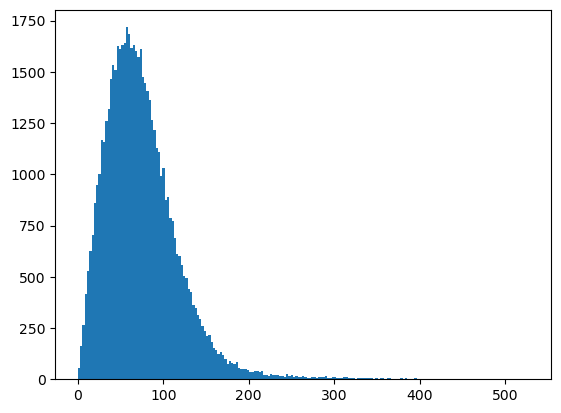

In [111]:
fig = plt.figure()
n, bins, patches = plt.hist(intersomatic_distances, bins=NBR_BINS, align='mid')
# plt.savefig(os.path.join(self.gaussian_path, f'{source_pop}_to_{target_pop}_histogram.png'), dpi=300, transparent=True)
# plt.close()
plt.show()

In [112]:
centered_bins = bins[:-1] + (bins[1]-bins[0])/2
areas = np.pi*(bins[1:]**2 - bins[:-1]**2)
non_zero_bins_mask = (n!=0)
n = n[non_zero_bins_mask]
centered_bins = centered_bins[non_zero_bins_mask]
areas = areas[non_zero_bins_mask]

targets_density = n/(n_source_ids*areas)

In [113]:
targets_density

array([2.48806075e-01, 2.36958188e-01, 2.35477242e-01, 2.64039069e-01,
       2.60160360e-01, 2.52845216e-01, 2.39920079e-01, 2.54137657e-01,
       2.47237887e-01, 2.34541954e-01, 2.46478804e-01, 2.23500628e-01,
       2.24103193e-01, 2.16553281e-01, 2.24446331e-01, 2.19855209e-01,
       2.03299167e-01, 2.06280574e-01, 1.93449384e-01, 1.85693154e-01,
       1.77501936e-01, 1.77408607e-01, 1.66068069e-01, 1.52668134e-01,
       1.47886966e-01, 1.39561700e-01, 1.31863504e-01, 1.30219456e-01,
       1.14815491e-01, 1.08890363e-01, 1.02406912e-01, 9.61230916e-02,
       8.64670427e-02, 8.06362862e-02, 7.27617182e-02, 6.93977859e-02,
       6.04366134e-02, 6.10760224e-02, 5.04881688e-02, 5.01099649e-02,
       4.31131751e-02, 4.12714663e-02, 3.59095328e-02, 3.12029522e-02,
       3.01023742e-02, 2.72436125e-02, 2.41735887e-02, 2.30567030e-02,
       2.01078320e-02, 1.90732788e-02, 1.58803093e-02, 1.50975163e-02,
       1.32442275e-02, 1.22907927e-02, 1.05979625e-02, 9.44627439e-03,
      

In [114]:
prob = targets_density/sdf
prob

array([5.58854538e+01, 5.32242465e+01, 5.28916045e+01, 5.93070053e+01,
       5.84357909e+01, 5.67927034e+01, 5.38895301e+01, 5.70830044e+01,
       5.55332160e+01, 5.26815253e+01, 5.53627150e+01, 5.02014833e+01,
       5.03368282e+01, 4.86410084e+01, 5.04139020e+01, 4.93826693e+01,
       4.56639422e+01, 4.63336094e+01, 4.34515380e+01, 4.17093762e+01,
       3.98695098e+01, 3.98485468e+01, 3.73012973e+01, 3.42914775e+01,
       3.32175579e+01, 3.13475825e+01, 2.96184560e+01, 2.92491789e+01,
       2.57892248e+01, 2.44583551e+01, 2.30020780e+01, 2.15906408e+01,
       1.94217521e+01, 1.81120797e+01, 1.63433374e+01, 1.55877494e+01,
       1.35749401e+01, 1.37185607e+01, 1.13403751e+01, 1.12554250e+01,
       9.68384455e+00, 9.27017004e+00, 8.06580199e+00, 7.00863573e+00,
       6.76142992e+00, 6.11931059e+00, 5.42973869e+00, 5.17886997e+00,
       4.51651076e+00, 4.28413511e+00, 3.56694784e+00, 3.39112118e+00,
       2.97484562e+00, 2.76069033e+00, 2.38045612e+00, 2.12177026e+00,
      

In [115]:
from scipy.optimize import curve_fit

def gaussian_func(r, a, sigma):
    return a*np.exp(-r**2/sigma**2)

popt, pcov = curve_fit(gaussian_func, centered_bins, prob, p0=np.array([1, 75]), method='lm')

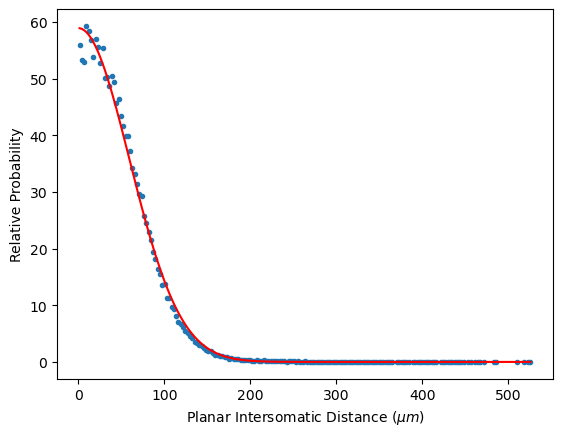

In [116]:
fig = plt.figure()
plt.plot(centered_bins, prob, '.')
ym = gaussian_func(centered_bins, popt[0], popt[1])
plt.plot(centered_bins, ym, c='r', label=f'Gaussian sigma: {popt[1]}')
plt.ylabel('Relative Probability')
plt.xlabel(r'Planar Intersomatic Distance ($\mu m$)')
plt.show()

In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    model.compile(loss='mae', optimizer='adam')
    return model

In [26]:
X = source_df[['x', 'y', 'z']].values
y = projected_source_positions[['x_target', 'y_target', 'z_target']].values
n_inputs, n_outputs = X.shape[1], y.shape[1]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# scaler
x_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = x_scaler.transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

In [29]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
        
model = get_model(n_inputs, n_outputs)
# fit the model on all data
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_test_scaled, y_test), 
                    verbose=2, epochs=100, callbacks=[es])

Epoch 1/100
1590/1590 - 2s - loss: 6641.9111 - val_loss: 6518.7910
Epoch 2/100
1590/1590 - 2s - loss: 6288.6816 - val_loss: 6021.9443
Epoch 3/100
1590/1590 - 2s - loss: 5679.0869 - val_loss: 5308.0557
Epoch 4/100
1590/1590 - 2s - loss: 4980.5210 - val_loss: 4688.6621
Epoch 5/100
1590/1590 - 2s - loss: 4364.9043 - val_loss: 4010.8376
Epoch 6/100
1590/1590 - 2s - loss: 3603.2173 - val_loss: 3173.7415
Epoch 7/100
1590/1590 - 2s - loss: 2703.3899 - val_loss: 2213.7275
Epoch 8/100
1590/1590 - 2s - loss: 1709.8877 - val_loss: 1258.8433
Epoch 9/100
1590/1590 - 2s - loss: 1058.8170 - val_loss: 946.0301
Epoch 10/100
1590/1590 - 2s - loss: 925.3531 - val_loss: 903.2971
Epoch 11/100
1590/1590 - 2s - loss: 889.7868 - val_loss: 867.3536
Epoch 12/100
1590/1590 - 2s - loss: 851.0210 - val_loss: 826.6906
Epoch 13/100
1590/1590 - 2s - loss: 809.3428 - val_loss: 784.6127
Epoch 14/100
1590/1590 - 2s - loss: 766.6567 - val_loss: 741.8953
Epoch 15/100
1590/1590 - 2s - loss: 723.2094 - val_loss: 698.0182
Ep

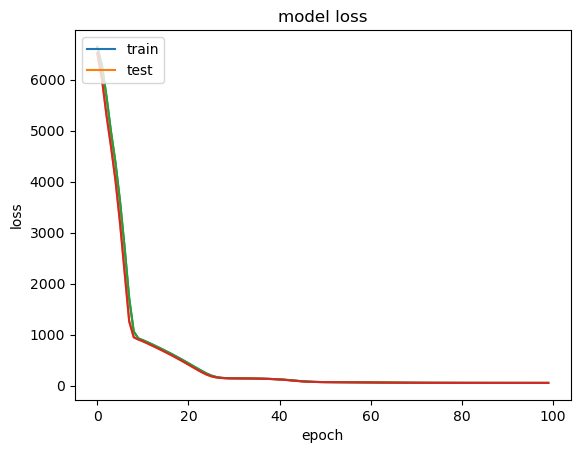

In [31]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(os.path.join(prediction_path, 'training_loss_curve.png'), dpi=300)
plt.show()

In [35]:
# Path to save results
prediction_path = 'Retinotopic_mapping_pred'
os.makedirs(prediction_path, exist_ok=True)

df_pred = pd.DataFrame(columns=target_df.columns)
for sid in np.random.choice(source_df.index, size=10, replace=False):
    df1 = target_df.loc[np.isin(target_df.index, edges_df['Target_id'].loc[edges_df['Source_id']==sid])]
    df2 = source_df.loc[source_df.index==sid]
    location_prediction = model.predict(x_scaler.transform(df2[['x', 'y', 'z']]))
    df_pred[['x', 'y', 'z']] = location_prediction
    df_pred['Visual_area'] = f'{target_area} prediction'
    df_pred['marker_size'] = 10
    df1 = df1.assign(Visual_area = f'{target_area} targets')
    df2 = df2.assign(Visual_area = f'{source_area} source')
    df1 = df1.assign(marker_size = 2)
    df2 = df2.assign(marker_size = 10)
    source_subset = source_subset.assign(marker_size = 2)
    target_subset = target_subset.assign(marker_size = 2)

    representation_df = pd.concat([source_subset,target_subset,df1, df2, df_pred], ignore_index=True, sort=False)
    fig = px.scatter_3d(representation_df, x='x', y='y', z='z', 
                        color='Visual_area', size='marker_size',
                        opacity=0.7)

    #fig.update_traces(marker_size = 2)
    fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0)) #, scene_camera=camera)
    fig.write_html(os.path.join(prediction_path, f"{source_area}_node_{sid}_to_{target_area}_bbp_model.html"))

model.save(os.path.join(prediction_path, f'saved_models/{source_area}_to_{target_area}_model'))

INFO:tensorflow:Assets written to: Retinotopic_mapping_pred/saved_models/VISp_to_VISl_model/assets


In [36]:
location_prediction = model.predict(x_scaler.transform(source_df[['x', 'y', 'z']]))

source_df.loc[projected_source_positions.index, ['x_projected', 'y_projected', 'z_projected']] = location_prediction
source_df.dropna(axis=0, inplace=True)
source_df = source_df.drop('Visual_area', axis=1)
target_df = target_df.drop('Visual_area', axis=1)

In [38]:
density_data = pd.DataFrame(columns=['planar_intersomatic_distance', 'Neuron_type'])
exc_pops = [f'{target_area}_L2_e', f'{target_area}_L4_e', f'{target_area}_L5_e', f'{target_area}_L6_e']
source_ids = list(set(source_df.index))
print(len(source_ids))    

56534


In [41]:
target_df.keys()

Index(['x', 'y', 'z'], dtype='object')

In [39]:
for idx, sid in enumerate(source_ids):
    xp, yp, zp = source_df.loc[sid, ['x_projected', 'y_projected', 'z_projected']]
    # Use closest excitatory neurons to determine the cylindrical coordinates through a PCA and determine the neuron densities
    new_target_df = target_df.copy()
    new_target_df['Distance_to_projected_source'] = np.sqrt(((new_target_df[['x', 'y', 'z']]-np.array([xp, yp, zp]))**2).sum(axis=1))
    all_closest_neurons = new_target_df.sort_values(['Distance_to_projected_source']).groupby('Neuron_type', sort=False).head(100)
    exc_closest_neurons = all_closest_neurons.loc[all_closest_neurons['Neuron_type'].isin(exc_pops)]
    pca=PCA(3)
    pca.fit(exc_closest_neurons[['x', 'y', 'z']])   
    #Get now neurons projections on the cylindrical basis
    xp_trans, yp_trans, zp_trans = pca.transform(np.array([[xp, yp, zp]]))[0]
    all_closest_neurons.loc[:, ['x_trans', 'y_trans', 'z_trans']] = pca.transform(all_closest_neurons[['x', 'y', 'z']])
    all_closest_neurons.loc[:, 'planar_intersomatic_distance'] = np.sqrt(((all_closest_neurons[['y_trans', 'z_trans']]-np.array([yp_trans, zp_trans]))**2).sum(axis=1))
    density_data = pd.concat([density_data, all_closest_neurons.loc[:, ['planar_intersomatic_distance', 'Neuron_type']]])

    edges_subset_df = self.edges_df.loc[self.edges_df['Source_id']==sid]
    edges_subset_df.loc[:, ['x_trans', 'y_trans', 'z_trans']] = pca.transform(edges_subset_df.loc[:,['x_target', 'y_target', 'z_target']])
    intersomatic_planar_dist = np.sqrt(((edges_subset_df[['y_trans', 'z_trans']] - np.array([yp_trans, zp_trans]))**2).sum(axis=1))

    source_edges_index = edges_subset_df.index
    edges_df.loc[source_edges_index, 'planar_intersomatic_distance'] = (intersomatic_planar_dist.values).astype(np.float32)


KeyError: 'Neuron_type'

In [14]:
source_filter_mask = source_filter.loc[source_filter['Target_id']>30] # to reduce computation cost
source_filter_mask

,Target_id
Source_id,
8624668,512
8624878,1186
8623409,482
8627509,761
8624882,1229
...,...
8962905,32
8978521,34
8945523,71


In [15]:
mean_edges_df = edges_df[['Source_id', 'x_target', 'y_target', 'z_target']].groupby(['Source_id'], sort=False).mean()
mean_edges_df

,x_target,y_target,z_target
Source_id,,,
8624668,9080.329751,1739.954200,9108.981739
8624878,9083.435169,1821.554752,9295.583586
8623409,8562.853567,1434.440359,9211.164020
8627509,9424.794065,2084.363727,9281.179985
8624882,8772.599504,1824.359061,9271.724274
...,...,...,...
8663413,9097.198600,1673.333923,9116.561841
8925987,8963.251552,1955.758139,9517.130203
8732112,8895.836184,1623.262423,9081.356874


In [16]:
mean_edges_df2 = mean_edges_df.loc[source_filter_mask.index]
mean_edges_df2

,x_target,y_target,z_target
Source_id,,,
8624668,9080.329751,1739.954200,9108.981739
8624878,9083.435169,1821.554752,9295.583586
8623409,8562.853567,1434.440359,9211.164020
8627509,9424.794065,2084.363727,9281.179985
8624882,8772.599504,1824.359061,9271.724274
...,...,...,...
8962905,9360.388578,2172.189007,8893.092289
8978521,8480.914118,1828.149867,8945.011504
8945523,8481.467322,1845.646276,8955.245787


In [17]:
source_df = source_df.loc[mean_edges_df2.index]
source_df

,x,y,z,Visual_area
Source_id,,,,
8624668,9248.455449,1134.637362,8853.299707,VISp
8624878,9370.604774,965.628291,8351.587968,VISp
8623409,7962.683096,759.896390,8444.115233,VISp
8627509,9979.398302,1220.256841,8281.162051,VISp
8624882,8840.683805,739.760909,8172.522524,VISp
...,...,...,...,...
8962905,9702.367476,2017.309327,8721.879047,VISp
8978521,7846.541514,1204.093867,7940.781033,VISp
8945523,7986.599783,1282.081826,7929.646510,VISp


In [18]:
source_df.loc[mean_edges_df2.index, ['x_projected', 'y_projected', 'z_projected']] = mean_edges_df2.loc[:, ['x_target', 'y_target', 'z_target']].values
source_df.dropna(axis=0, inplace=True)
source_df

,x,y,z,Visual_area,x_projected,y_projected,z_projected
Source_id,,,,,,,
8624668,9248.455449,1134.637362,8853.299707,VISp,9080.329751,1739.954200,9108.981739
8624878,9370.604774,965.628291,8351.587968,VISp,9083.435169,1821.554752,9295.583586
8623409,7962.683096,759.896390,8444.115233,VISp,8562.853567,1434.440359,9211.164020
8627509,9979.398302,1220.256841,8281.162051,VISp,9424.794065,2084.363727,9281.179985
8624882,8840.683805,739.760909,8172.522524,VISp,8772.599504,1824.359061,9271.724274
...,...,...,...,...,...,...,...
8962905,9702.367476,2017.309327,8721.879047,VISp,9360.388578,2172.189007,8893.092289
8978521,7846.541514,1204.093867,7940.781033,VISp,8480.914118,1828.149867,8945.011504
8945523,7986.599783,1282.081826,7929.646510,VISp,8481.467322,1845.646276,8955.245787


In [19]:
#Esto no será necesario luego en el .py
a = dict(zip(edges_df['Target_id'].values, edges_df['Target'].values))
target_df.loc[np.array(list(a.keys())), 'Neuron_type'] = np.array(list(a.values()))
target_df.dropna(inplace=True)
target_df

,x,y,z,Visual_area,Neuron_type
node_id,,,,,
8161112,9301.237960,1578.684083,9423.971513,VISl,VISl_L1_i_Htr3a
8161113,9162.541289,1609.843756,9557.755458,VISl,VISl_L1_i_Htr3a
8161114,9520.393718,1834.875397,9561.739094,VISl,VISl_L1_i_Htr3a
8161115,9429.508106,1630.177622,9458.110141,VISl,VISl_L1_i_Htr3a
8161116,8700.408176,1559.152282,9697.845100,VISl,VISl_L1_i_Htr3a
...,...,...,...,...,...
8216921,8533.629505,1997.655514,9238.402582,VISl,VISl_L6_e
8216922,8509.955391,1986.731489,9198.199545,VISl,VISl_L6_e
8216923,8735.944264,1885.712081,9062.820802,VISl,VISl_L6_e


In [20]:
target_df = target_df.drop('Visual_area', axis=1)
target_df

,x,y,z,Neuron_type
node_id,,,,
8161112,9301.237960,1578.684083,9423.971513,VISl_L1_i_Htr3a
8161113,9162.541289,1609.843756,9557.755458,VISl_L1_i_Htr3a
8161114,9520.393718,1834.875397,9561.739094,VISl_L1_i_Htr3a
8161115,9429.508106,1630.177622,9458.110141,VISl_L1_i_Htr3a
8161116,8700.408176,1559.152282,9697.845100,VISl_L1_i_Htr3a
...,...,...,...,...
8216921,8533.629505,1997.655514,9238.402582,VISl_L6_e
8216922,8509.955391,1986.731489,9198.199545,VISl_L6_e
8216923,8735.944264,1885.712081,9062.820802,VISl_L6_e


In [81]:
sid = 8978521
xp, yp, zp = source_df.loc[sid, ['x_projected', 'y_projected', 'z_projected']]
xp, yp, zp

(8480.91411772325, 1828.1498670086578, 8945.011504076967)

In [82]:
new_target_df = target_df.copy()
new_target_df

,x,y,z,Neuron_type
node_id,,,,
8161112,9301.237960,1578.684083,9423.971513,VISl_L1_i_Htr3a
8161113,9162.541289,1609.843756,9557.755458,VISl_L1_i_Htr3a
8161114,9520.393718,1834.875397,9561.739094,VISl_L1_i_Htr3a
8161115,9429.508106,1630.177622,9458.110141,VISl_L1_i_Htr3a
8161116,8700.408176,1559.152282,9697.845100,VISl_L1_i_Htr3a
...,...,...,...,...
8216921,8533.629505,1997.655514,9238.402582,VISl_L6_e
8216922,8509.955391,1986.731489,9198.199545,VISl_L6_e
8216923,8735.944264,1885.712081,9062.820802,VISl_L6_e


In [83]:
new_target_df['Distance_to_projected_source'] = np.sqrt(((new_target_df[['x', 'y', 'z']]-np.array([xp, yp, zp]))**2).sum(axis=1))
# new_target_df = new_target_df.loc[:, ['Neuron_type', 'Distance_to_source']]
new_target_df

,x,y,z,Neuron_type,Distance_to_projected_source
node_id,,,,,
8161112,9301.237960,1578.684083,9423.971513,VISl_L1_i_Htr3a,982.123757
8161113,9162.541289,1609.843756,9557.755458,VISl_L1_i_Htr3a,942.193351
8161114,9520.393718,1834.875397,9561.739094,VISl_L1_i_Htr3a,1208.683578
8161115,9429.508106,1630.177622,9458.110141,VISl_L1_i_Htr3a,1096.491576
8161116,8700.408176,1559.152282,9697.845100,VISl_L1_i_Htr3a,829.033031
...,...,...,...,...,...
8216921,8533.629505,1997.655514,9238.402582,VISl_L6_e,342.913110
8216922,8509.955391,1986.731489,9198.199545,VISl_L6_e,300.159475
8216923,8735.944264,1885.712081,9062.820802,VISl_L6_e,286.762645


In [109]:
closest_neurons0 = new_target_df.sort_values(['Distance_to_projected_source']).groupby('Neuron_type', sort=False).head(100)
closest_neurons0

,x,y,z,Neuron_type,Distance_to_projected_source
node_id,,,,,
8201936,8487.949311,1833.533871,8937.323399,VISl_L6_e,11.729809
8207383,8481.073860,1841.192573,8938.897178,VISl_L6_e,14.405648
8201728,8477.431092,1827.363463,8930.233491,VISl_L6_e,15.203275
8209757,8484.804337,1822.033101,8931.378637,VISl_L6_i_Sst,15.440327
8205983,8472.487076,1825.484215,8932.272665,VISl_L6_e,15.504798
...,...,...,...,...,...
8209791,9485.922523,2270.443509,8975.384886,VISl_L6_i_Pvalb,1098.448043
8209578,9504.335457,2213.684156,9064.079417,VISl_L6_i_Pvalb,1100.093221
8209808,9524.618913,2189.098237,8945.580663,VISl_L6_i_Pvalb,1104.356712


In [110]:
exc_pops = [f'{target_area}_L2_e', f'{target_area}_L4_e', f'{target_area}_L5_e', f'{target_area}_L6_e']
closest_neurons = closest_neurons0.loc[closest_neurons0['Neuron_type'].isin(exc_pops)]
closest_neurons

,x,y,z,Neuron_type,Distance_to_projected_source
node_id,,,,,
8201936,8487.949311,1833.533871,8937.323399,VISl_L6_e,11.729809
8207383,8481.073860,1841.192573,8938.897178,VISl_L6_e,14.405648
8201728,8477.431092,1827.363463,8930.233491,VISl_L6_e,15.203275
8205983,8472.487076,1825.484215,8932.272665,VISl_L6_e,15.504798
8207432,8479.346079,1819.142916,8930.085791,VISl_L6_e,17.503166
...,...,...,...,...,...
8172142,8721.317093,1518.654024,9267.979479,VISl_L2_e,507.828298
8177443,8641.215391,1431.814000,9219.183369,VISl_L2_e,507.886630
8170130,8670.019939,1549.370357,9325.791860,VISl_L2_e,508.402111


In [111]:
pca=PCA(3)
pca.fit(closest_neurons[['x', 'y', 'z']])    

array([0.8590455 , 0.09917953, 0.04177497])

In [ ]:
pca.explained_variance_ratio_

In [88]:
pca.components_

array([[-0.2049925 ,  0.78884351, -0.57939969],
       [-0.23721083, -0.61436387, -0.75252114],
       [ 0.94958365,  0.01682131, -0.31306221]])

In [89]:
pca.singular_values_

array([3797.00489314, 1290.16155892,  837.31937997])

In [90]:
pca.transform(np.array([[xp, yp, zp]]))

array([[ 2.39957568e+02,  1.01755669e-01, -1.57985452e+01]])

In [91]:
val = pca.transform(closest_neurons[['x', 'y', 'z']])
val

array([[ 247.2170285 ,    0.910656  ,   -6.62061937],
       [ 253.75611447,   -3.34794525,  -13.5132964 ],
       [ 248.61358837,   12.53187256,  -14.4927608 ],
       ...,
       [-239.34513161, -160.02940047,   39.87587669],
       [-251.54375941,   85.36527243,   82.70991969],
       [-244.49217253,  154.08892252,    1.90226199]])

In [92]:
val.var(axis=0)

array([36043.11539628,  4161.29212032,  1752.75936017])

In [93]:
closest_neurons.loc[:, ['x_trans', 'y_trans', 'z_trans']] = pca.transform(closest_neurons[['x', 'y', 'z']])
closest_neurons

<ipython-input-93-8df315bd6f5a>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,x,y,z,Neuron_type,Distance_to_projected_source,x_trans,y_trans,z_trans
node_id,,,,,,,,
8201936,8487.949311,1833.533871,8937.323399,VISl_L6_e,11.729809,247.217028,0.910656,-6.620619
8207383,8481.073860,1841.192573,8938.897178,VISl_L6_e,14.405648,253.756114,-3.347945,-13.513296
8201728,8477.431092,1827.363463,8930.233491,VISl_L6_e,15.203275,248.613588,12.531873,-14.492761
8205983,8472.487076,1825.484215,8932.272665,VISl_L6_e,15.504798,246.963145,13.324667,-19.857517
8207432,8479.346079,1819.142916,8930.085791,VISl_L6_e,17.503166,241.821883,17.239171,-12.766361
...,...,...,...,...,...,...,...,...
8172142,8721.317093,1518.654024,9267.979479,VISl_L2_e,507.828298,-240.594568,-109.821597,106.168998
8177443,8641.215391,1431.814000,9219.183369,VISl_L2_e,507.886630,-264.405059,-0.749128,43.921186
8170130,8670.019939,1549.370357,9325.791860,VISl_L2_e,508.402111,-239.345132,-160.029400,39.875877


In [94]:
closest_neurons.var(axis=0)

<ipython-input-94-b81fde2af656>:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



x                                3337.575692
y                               24059.992840
z                               14664.754151
Distance_to_projected_source    32145.884052
x_trans                         36133.449019
y_trans                          4171.721424
z_trans                          1757.152241
dtype: float64

In [95]:
mapping_path = 'PCA_mapping'
os.makedirs(mapping_path, exist_ok=True)

sid_df = pd.DataFrame(index=np.arange(1), columns=closest_neurons.columns)
sid_df.loc[0, ['x', 'y', 'z']] = np.array([xp, yp, zp])
sid_df.loc[0, ['x_trans', 'y_trans', 'z_trans']] = pca.transform(np.array([[xp, yp, zp]]))[0]
sid_df = sid_df.assign(marker_size = 15)
sid_df = sid_df.assign(Neuron_type = 'Source')
closest_neurons = closest_neurons.assign(marker_size = 2)
representation_df = pd.concat([sid_df, closest_neurons], ignore_index=True, sort=False)

fig = px.scatter_3d(representation_df, x='x', y='y', z='z', 
                    size='marker_size', color='Neuron_type', opacity=0.7)
# fig.update_traces(marker_size = 2)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), scene=dict(
                 aspectmode='data'))
fig.write_html(os.path.join(mapping_path, f"{source_area}_node_{sid}_to_{target_area}_closest_excitatory.html"))

In [96]:
fig = px.scatter_3d(representation_df, x='x_trans', y='y_trans', z='z_trans', 
                    size='marker_size', color='Neuron_type', opacity=0.7)
# fig.update_traces(marker_size = 2)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), scene=dict(
                 aspectmode='data'))
fig.write_html(os.path.join(mapping_path, f"{source_area}_node_{sid}_to_{target_area}_closest_excitatory_PCA_coordinates.html"))

In [97]:
closest_neurons0.loc[:, ['x_trans', 'y_trans', 'z_trans']] = pca.transform(closest_neurons0[['x', 'y', 'z']])
closest_neurons0

,x,y,z,Neuron_type,Distance_to_projected_source,x_trans,y_trans,z_trans
node_id,,,,,,,,
8201936,8487.949311,1833.533871,8937.323399,VISl_L6_e,11.729809,247.217028,0.910656,-6.620619
8207383,8481.073860,1841.192573,8938.897178,VISl_L6_e,14.405648,253.756114,-3.347945,-13.513296
8201728,8477.431092,1827.363463,8930.233491,VISl_L6_e,15.203275,248.613588,12.531873,-14.492761
8209757,8484.804337,1822.033101,8931.378637,VISl_L6_i_Sst,15.440327,242.233810,13.195894,-7.939413
8205983,8472.487076,1825.484215,8932.272665,VISl_L6_e,15.504798,246.963145,13.324667,-19.857517
...,...,...,...,...,...,...,...,...
8209791,9485.922523,2270.443509,8975.384886,VISl_L6_i_Pvalb,1098.448043,365.240526,-532.882966,936.472198
8209578,9504.335457,2213.684156,9064.079417,VISl_L6_i_Pvalb,1100.093221,265.302183,-569.124327,925.235148
8209808,9524.618913,2189.098237,8945.580663,VISl_L6_i_Pvalb,1104.356712,310.407924,-469.658265,981.179899


In [98]:
closest_neurons0 = closest_neurons0.assign(marker_size = 2)
representation_df = pd.concat([sid_df, closest_neurons0], ignore_index=True, sort=False)

fig = px.scatter_3d(representation_df, x='x', y='y', z='z', 
                    size='marker_size', color='Neuron_type', opacity=0.7)
# fig.update_traces(marker_size = 2)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), scene=dict(
                 aspectmode='data'))
fig.write_html(os.path.join(mapping_path, f"{source_area}_node_{sid}_to_{target_area}_closest_all.html"))

In [99]:
fig = px.scatter_3d(representation_df, x='x_trans', y='y_trans', z='z_trans', 
                    size='marker_size', color='Neuron_type', opacity=0.7)
# fig.update_traces(marker_size = 2)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), scene=dict(
                  aspectmode='data'))
fig.write_html(os.path.join(mapping_path, f"{source_area}_node_{sid}_to_{target_area}_closest_all_PCA_coordinates.html"))

In [100]:
closest_neurons0

,x,y,z,Neuron_type,Distance_to_projected_source,x_trans,y_trans,z_trans,marker_size
node_id,,,,,,,,,
8201936,8487.949311,1833.533871,8937.323399,VISl_L6_e,11.729809,247.217028,0.910656,-6.620619,2
8207383,8481.073860,1841.192573,8938.897178,VISl_L6_e,14.405648,253.756114,-3.347945,-13.513296,2
8201728,8477.431092,1827.363463,8930.233491,VISl_L6_e,15.203275,248.613588,12.531873,-14.492761,2
8209757,8484.804337,1822.033101,8931.378637,VISl_L6_i_Sst,15.440327,242.233810,13.195894,-7.939413,2
8205983,8472.487076,1825.484215,8932.272665,VISl_L6_e,15.504798,246.963145,13.324667,-19.857517,2
...,...,...,...,...,...,...,...,...,...
8209791,9485.922523,2270.443509,8975.384886,VISl_L6_i_Pvalb,1098.448043,365.240526,-532.882966,936.472198,2
8209578,9504.335457,2213.684156,9064.079417,VISl_L6_i_Pvalb,1100.093221,265.302183,-569.124327,925.235148,2
8209808,9524.618913,2189.098237,8945.580663,VISl_L6_i_Pvalb,1104.356712,310.407924,-469.658265,981.179899,2


In [101]:
xp_trans, yp_trans, zp_trans = pca.transform(np.array([[xp, yp, zp]]))[0]
closest_neurons0.loc[:, 'planar_intersomatic_distance'] = np.sqrt(((closest_neurons0[['y_trans', 'z_trans']]-np.array([yp_trans, zp_trans]))**2).sum(axis=1))
closest_neurons0

,x,y,z,Neuron_type,Distance_to_projected_source,x_trans,y_trans,z_trans,marker_size,planar_intersomatic_distance
node_id,,,,,,,,,,
8201936,8487.949311,1833.533871,8937.323399,VISl_L6_e,11.729809,247.217028,0.910656,-6.620619,2,9.213503
8207383,8481.073860,1841.192573,8938.897178,VISl_L6_e,14.405648,253.756114,-3.347945,-13.513296,2,4.137970
8201728,8477.431092,1827.363463,8930.233491,VISl_L6_e,15.203275,248.613588,12.531873,-14.492761,2,12.498515
8209757,8484.804337,1822.033101,8931.378637,VISl_L6_i_Sst,15.440327,242.233810,13.195894,-7.939413,2,15.271622
8205983,8472.487076,1825.484215,8932.272665,VISl_L6_e,15.504798,246.963145,13.324667,-19.857517,2,13.831871
...,...,...,...,...,...,...,...,...,...,...
8209791,9485.922523,2270.443509,8975.384886,VISl_L6_i_Pvalb,1098.448043,365.240526,-532.882966,936.472198,2,1091.280112
8209578,9504.335457,2213.684156,9064.079417,VISl_L6_i_Pvalb,1100.093221,265.302183,-569.124327,925.235148,2,1099.801230
8209808,9524.618913,2189.098237,8945.580663,VISl_L6_i_Pvalb,1104.356712,310.407924,-469.658265,981.179899,2,1102.107298


In [102]:
density_data = pd.DataFrame(columns=['planar_intersomatic_distance', 'Neuron_type'])
density_data = pd.concat([density_data, closest_neurons0.loc[:, ['planar_intersomatic_distance', 'Neuron_type']]])
density_data

,planar_intersomatic_distance,Neuron_type
8201936,9.213503,VISl_L6_e
8207383,4.137970,VISl_L6_e
8201728,12.498515,VISl_L6_e
8209757,15.271622,VISl_L6_i_Sst
8205983,13.831871,VISl_L6_e
...,...,...
8209791,1091.280112,VISl_L6_i_Pvalb
8209578,1099.801230,VISl_L6_i_Pvalb
8209808,1102.107298,VISl_L6_i_Pvalb
8209590,1109.651579,VISl_L6_i_Pvalb


In [103]:
edges_subset_df = edges_df.loc[edges_df['Source_id']==sid]
edges_subset_df

,Source_id,Source,Target_id,Target,x_target,y_target,z_target,planar_intersomatic_distance
22714953,8978521,VISp_L6_e,8199595,VISl_L5_e,8644.639315,1687.285429,9016.418637,NaN
23762448,8978521,VISp_L6_e,8199923,VISl_L6_e,8446.601893,1821.879938,8898.542129,NaN
23762451,8978521,VISp_L6_e,8201715,VISl_L6_e,8489.982054,1780.239968,8964.675988,NaN
23762455,8978521,VISp_L6_e,8202745,VISl_L6_e,8482.845865,1783.171532,8889.456296,NaN
23762490,8978521,VISp_L6_e,8200323,VISl_L6_e,8471.713527,1875.080047,8919.069211,NaN
24753863,8978521,VISp_L6_e,8203133,VISl_L6_e,8451.721608,1865.958228,8950.056618,NaN
24753864,8978521,VISp_L6_e,8203944,VISl_L6_e,8524.116427,1840.847640,8918.093669,NaN
24753958,8978521,VISp_L6_e,8205215,VISl_L6_e,8503.072375,1844.974967,8984.707854,NaN
25108866,8978521,VISp_L6_e,8205611,VISl_L6_e,8450.087021,1867.846543,8926.763040,NaN
26208851,8978521,VISp_L6_e,8206823,VISl_L6_e,8529.861099,1789.689079,9064.179213,NaN


In [104]:
edges_subset_df.loc[:, ['x_trans', 'y_trans', 'z_trans']] = pca.transform(edges_subset_df.loc[:,['x_target', 'y_target', 'z_target']])
edges_subset_df

<ipython-input-104-16af15041ee8>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Source_id,Source,Target_id,Target,x_target,y_target,z_target,planar_intersomatic_distance,x_trans,y_trans,z_trans
22714953,8978521,VISp_L6_e,8199595,VISl_L5_e,8644.639315,1687.285429,9016.418637,NaN,53.901863,-5.928989,114.947826
23762448,8978521,VISp_L6_e,8199923,VISl_L6_e,8446.601893,1821.879938,8898.542129,NaN,268.969665,47.062192,-33.938536
23762451,8978521,VISp_L6_e,8201715,VISl_L6_e,8489.982054,1780.239968,8964.675988,NaN,188.911700,12.586914,-14.149895
23762455,8978521,VISp_L6_e,8202745,VISl_L6_e,8482.845865,1783.171532,8889.456296,NaN,236.269377,69.083056,2.671452
23762490,8978521,VISp_L6_e,8200323,VISl_L6_e,8471.713527,1875.080047,8919.069211,NaN,293.895144,-7.025848,-15.624297
24753863,8978521,VISp_L6_e,8203133,VISl_L6_e,8451.721608,1865.958228,8950.056618,NaN,272.843556,-19.998111,-44.462723
24753864,8978521,VISp_L6_e,8203944,VISl_L6_e,8524.116427,1840.847640,8918.093669,NaN,256.714160,2.308887,33.866211
24753958,8978521,VISp_L6_e,8205215,VISl_L6_e,8503.072375,1844.974967,8984.707854,NaN,225.687609,-45.363499,-6.901833
25108866,8978521,VISp_L6_e,8205611,VISl_L6_e,8450.087021,1867.846543,8926.763040,NaN,288.164511,-3.241572,-38.690798
26208851,8978521,VISp_L6_e,8206823,VISl_L6_e,8529.861099,1789.689079,9064.179213,NaN,130.538528,-77.556299,-7.273158


In [105]:
edges_subset_df = edges_subset_df.assign(marker_size = 2)
sid_df = sid_df.assign(Target='Source')
representation_df = pd.concat([sid_df, edges_subset_df], ignore_index=True, sort=False)
fig = px.scatter_3d(representation_df, x='x_trans', y='y_trans', z='z_trans', 
                    size='marker_size', color='Target', opacity=0.7)
# fig.update_traces(marker_size = 2)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), scene=dict(
                 aspectmode='data'))
fig.write_html(os.path.join(mapping_path, f"{source_area}_node_{sid}_to_{target_area}_targets_PCA_coordinates.html"))

In [106]:
intersomatic_planar_dist = np.sqrt(((edges_subset_df[['y_trans', 'z_trans']] -  [yp_trans, zp_trans])**2).sum(axis=1))
intersomatic_planar_dist

22714953    130.885383
23762448     50.342247
23762451     12.593539
23762455     71.411208
23762490      7.129733
24753863     35.009138
24753864     49.713775
24753958     46.327539
25108866     23.135105
26208851     78.124617
26208883      4.137970
26208885     54.433844
26208899     17.403596
26208907     19.122328
26208920     31.705467
26209347     32.334322
26209353     19.326825
26209354     52.016432
26209534     15.393255
26209538     53.708898
27339393     28.306147
27339661     57.776193
27511769     49.003498
27511774    116.877391
27513189     15.271622
27718481    102.862290
27718482     46.803697
27718509     25.519586
27718615     53.101971
27718647     19.079356
27718989     49.447701
27719026     44.822395
27719042     51.271034
29769285     23.328576
dtype: float64

In [107]:
source_edges_index = edges_subset_df.index
edges_df.loc[source_edges_index, 'planar_intersomatic_distance'] = (intersomatic_planar_dist.values).astype(np.float32)

In [108]:
edges_df

,Source_id,Source,Target_id,Target,x_target,y_target,z_target,planar_intersomatic_distance
0,8624668,VISp_L2_e,8161215,VISl_L1_i_Htr3a,9301.708303,1493.350343,9325.162706,105.181007
1,8624668,VISp_L2_e,8161156,VISl_L1_i_Htr3a,9183.515173,1490.031367,9392.563837,80.402153
2,8624878,VISp_L2_e,8161131,VISl_L1_i_Htr3a,9249.099005,1579.817803,9451.942567,82.337959
3,8623409,VISp_L2_e,8161195,VISl_L1_i_Htr3a,8583.266541,1277.412900,9355.869785,NaN
4,8627509,VISp_L2_e,8161136,VISl_L1_i_Htr3a,9639.551674,1842.048003,9494.470198,NaN
...,...,...,...,...,...,...,...,...
38661852,8744922,VISp_L2_e,8187711,VISl_L4_e,9003.762095,1710.684741,9170.987745,NaN
38661853,8742418,VISp_L2_e,8187994,VISl_L4_e,9381.614992,1909.596445,9244.497147,NaN
38661854,8742347,VISp_L2_e,8188454,VISl_L4_e,8579.650152,1571.086391,9152.143952,NaN
38661855,8742418,VISp_L2_e,8188772,VISl_L4_e,9480.521449,1949.699291,9312.349989,NaN


In [52]:
xsource_df.iloc[0]

x              9248.455449
y              1134.637362
z              8853.299707
Visual_area           VISp
x_projected    9080.329751
y_projected      1739.9542
z_projected    9108.981739
Name: 8624668, dtype: object

In [10]:
source_ids = list(set(edges_df['Source_id']))
# source_pop_name = list(set(edges_df['Source']))
len(source_ids)
sid = source_ids[0]

In [51]:
new_source_df = source_df.dropna(axis=0)
new_source_df.shape

(63078, 7)

In [52]:
target_df

,x,y,z,Visual_area
node_id,,,,
8161111,9885.848918,1781.105061,9238.365826,VISl
8161112,9301.237960,1578.684083,9423.971513,VISl
8161113,9162.541289,1609.843756,9557.755458,VISl
8161114,9520.393718,1834.875397,9561.739094,VISl
8161115,9429.508106,1630.177622,9458.110141,VISl
...,...,...,...,...
8216922,8509.955391,1986.731489,9198.199545,VISl
8216923,8735.944264,1885.712081,9062.820802,VISl
8216924,8890.313048,2247.276835,9254.254607,VISl


In [54]:
(63078*55816)/38661857

91.06550800185309

In [19]:
edges_subset_df = edges_df.loc[edges_df['Source_id'].isin(source_ids[:2])]
edges_subset_df

,Source_id,Source,Target_id,Target
774101,8912896,VISp_L6_e,8161756,VISl_L1_i_Htr3a
927407,8912896,VISp_L6_e,8169186,VISl_L2_i_Htr3a
1066390,8781825,VISp_L4_e,8162291,VISl_L2_i_Htr3a
1076113,8912896,VISp_L6_e,8162346,VISl_L2_i_Htr3a
1123804,8912896,VISp_L6_e,8162514,VISl_L2_i_Pvalb
...,...,...,...,...
37195224,8781825,VISp_L4_e,8188768,VISl_L4_e
37683518,8912896,VISp_L6_e,8187541,VISl_L4_e
37683535,8912896,VISp_L6_e,8187386,VISl_L4_e
37683574,8912896,VISp_L6_e,8187074,VISl_L4_e


In [22]:
target_df.loc[edges_subset_df['Target_id']]

,x,y,z,Visual_area
node_id,,,,
8161756,9434.170461,1782.556998,9645.088800,VISl
8169186,9358.820667,1844.388451,9509.872315,VISl
8162291,8987.039064,1700.838325,9654.597887,VISl
8162346,9436.222020,1883.422457,9618.135073,VISl
8162514,9328.667250,1753.153755,9564.687162,VISl
...,...,...,...,...
8188768,8963.341219,1879.238669,9599.808424,VISl
8187541,9253.913202,1966.269911,9498.614630,VISl
8187386,9185.727744,1971.836378,9389.256216,VISl


In [21]:
target_df

,x,y,z,Visual_area
node_id,,,,
8161111,9885.848918,1781.105061,9238.365826,VISl
8161112,9301.237960,1578.684083,9423.971513,VISl
8161113,9162.541289,1609.843756,9557.755458,VISl
8161114,9520.393718,1834.875397,9561.739094,VISl
8161115,9429.508106,1630.177622,9458.110141,VISl
...,...,...,...,...
8216922,8509.955391,1986.731489,9198.199545,VISl
8216923,8735.944264,1885.712081,9062.820802,VISl
8216924,8890.313048,2247.276835,9254.254607,VISl


In [20]:
df1 = target_df.loc[target_df.index.isin(edges_subset_df['Target_id'])]
df1

,x,y,z,Visual_area
node_id,,,,
8161756,9434.170461,1782.556998,9645.088800,VISl
8169186,9358.820667,1844.388451,9509.872315,VISl
8162291,8987.039064,1700.838325,9654.597887,VISl
8162346,9436.222020,1883.422457,9618.135073,VISl
8162514,9328.667250,1753.153755,9564.687162,VISl
...,...,...,...,...
8216404,9066.123400,2228.166913,9105.177765,VISl
8216419,9108.354377,2226.128170,9151.575554,VISl
8216505,9058.711417,2169.845940,9159.196758,VISl


In [ ]:
for idx, sid in enumerate(source_ids[:10]):
#     if idx%10000 == 0:
#         print(idx)
    edges_subset_df = edges_df.loc[edges_df['Source_id']==sid]
    df1 = target_df.loc[target_df.index.isin(edges_subset_df['Target_id'])]

In [17]:
edges_subset_df = edges_df.loc[edges_df['Source_id']==sid]
edges_subset_df

,Source_id,Source,Target_id,Target
774101,8912896,VISp_L6_e,8161756,VISl_L1_i_Htr3a
927407,8912896,VISp_L6_e,8169186,VISl_L2_i_Htr3a
1076113,8912896,VISp_L6_e,8162346,VISl_L2_i_Htr3a
1123804,8912896,VISp_L6_e,8162514,VISl_L2_i_Pvalb
1433936,8912896,VISp_L6_e,8162726,VISl_L2_i_Pvalb
...,...,...,...,...
36078244,8912896,VISp_L6_e,8179616,VISl_L4_e
37683518,8912896,VISp_L6_e,8187541,VISl_L4_e
37683535,8912896,VISp_L6_e,8187386,VISl_L4_e
37683574,8912896,VISp_L6_e,8187074,VISl_L4_e


In [18]:
df1 = target_df.loc[target_df.index.isin(edges_subset_df['Target_id'])]
df1

,x,y,z,Visual_area
node_id,,,,
8161756,9434.170461,1782.556998,9645.088800,VISl
8169186,9358.820667,1844.388451,9509.872315,VISl
8162346,9436.222020,1883.422457,9618.135073,VISl
8162514,9328.667250,1753.153755,9564.687162,VISl
8162726,9318.144111,1716.706728,9468.745786,VISl
...,...,...,...,...
8216404,9066.123400,2228.166913,9105.177765,VISl
8216419,9108.354377,2226.128170,9151.575554,VISl
8216505,9058.711417,2169.845940,9159.196758,VISl


In [19]:
source_df.loc[sid, ['x_projection', 'y_projection', 'z_projection']] = df1[['x', 'y', 'z']].mean().values

In [21]:
source_df.loc[sid, ['x_projection', 'y_projection', 'z_projection']] = df1[['x', 'y', 'z']].mean().values

In [22]:
source_df.loc[sid]

x               9498.602665
y               1514.619344
z               8085.014517
Visual_area            VISp
x_projection    9142.711573
y_projection    2142.144546
z_projection    9221.616705
Name: 8912896, dtype: object

In [38]:
edges_df.loc[edges_df['Source_id']==sid]

,Source_id,Source,Target_id,Target
774101,8912896,VISp_L6_e,8161756,VISl_L1_i_Htr3a
927407,8912896,VISp_L6_e,8169186,VISl_L2_i_Htr3a
1076113,8912896,VISp_L6_e,8162346,VISl_L2_i_Htr3a
1123804,8912896,VISp_L6_e,8162514,VISl_L2_i_Pvalb
1433936,8912896,VISp_L6_e,8162726,VISl_L2_i_Pvalb
...,...,...,...,...
36078244,8912896,VISp_L6_e,8179616,VISl_L4_e
37683518,8912896,VISp_L6_e,8187541,VISl_L4_e
37683535,8912896,VISp_L6_e,8187386,VISl_L4_e
37683574,8912896,VISp_L6_e,8187074,VISl_L4_e


In [15]:
target_df.index

UInt64Index([8161111, 8161112, 8161113, 8161114, 8161115, 8161116, 8161117,
             8161118, 8161119, 8161120,
             ...
             8216917, 8216918, 8216919, 8216920, 8216921, 8216922, 8216923,
             8216924, 8216925, 8216926],
            dtype='uint64', name='node_id', length=55816)

In [47]:
df1[['x', 'y', 'z']].mean()

x    9142.711573
y    2142.144546
z    9221.616705
dtype: float64

In [36]:
tdf = target_df.set_index('node_id')
tdf

,x,y,z,Visual_area
node_id,,,,
8161111,9885.848918,1781.105061,9238.365826,VISl
8161112,9301.237960,1578.684083,9423.971513,VISl
8161113,9162.541289,1609.843756,9557.755458,VISl
8161114,9520.393718,1834.875397,9561.739094,VISl
8161115,9429.508106,1630.177622,9458.110141,VISl
...,...,...,...,...
8216922,8509.955391,1986.731489,9198.199545,VISl
8216923,8735.944264,1885.712081,9062.820802,VISl
8216924,8890.313048,2247.276835,9254.254607,VISl


8912896

In [265]:
target_df.loc[target_df['node_id'].isin(edges_df['Target_id'].loc[edges_df['Source_id']==sid])]

,node_id,x,y,z,Visual_area
645,8161756,9434.170461,1782.556998,9645.088800,VISl
1251,8169186,9358.820667,1844.388451,9509.872315,VISl
1451,8162346,9436.222020,1883.422457,9618.135073,VISl
1692,8162514,9328.667250,1753.153755,9564.687162,VISl
2068,8162726,9318.144111,1716.706728,9468.745786,VISl
...,...,...,...,...,...
55293,8216404,9066.123400,2228.166913,9105.177765,VISl
55308,8216419,9108.354377,2226.128170,9151.575554,VISl
55394,8216505,9058.711417,2169.845940,9159.196758,VISl
55424,8216535,9164.130205,2172.549627,9203.695284,VISl


In [298]:
source_pop_edges_df = edges_df.loc[edges_df['Source_id']==8869157].index
source_pop_edges_df

Int64Index([  619445,   619456,   619665,   619673,   619674,   619692,
              619693,   619694,   619695,   674633,
            ...
            37614666, 37614667, 37614668, 37614670, 37614676, 37614677,
            37614680, 37614681, 37617225, 37617258],
           dtype='int64', length=1673)

In [299]:
edges_df.loc[source_pop_edges_df, 'intersomatic_planar_distance']

619445     NaN
619456     NaN
619665     NaN
619673     NaN
619674     NaN
            ..
37614677   NaN
37614680   NaN
37614681   NaN
37617225   NaN
37617258   NaN
Name: intersomatic_planar_distance, Length: 1673, dtype: float64

In [267]:
source_pop_ids = list(set(source_pop_edges_df['Source_id']))
sid = source_pop_ids[0]
source_pop_ids

[8880135,
 8880136,
 8880153,
 8880156,
 8880157,
 8880166,
 8880169,
 8880171,
 8880173,
 8880187,
 8880189,
 8880192,
 8880194,
 8880198,
 8880199,
 8880211,
 8880230,
 8880232,
 8880235,
 8880239,
 8880247,
 8880248,
 8880255,
 8880266,
 8880268,
 8880270,
 8880273,
 8880279,
 8880286,
 8880288,
 8880293,
 8880296,
 8880297,
 8880299,
 8880305,
 8857495,
 8857507,
 8857512,
 8857523,
 8857524,
 8857527,
 8857533,
 8857535,
 8857545,
 8857548,
 8857562,
 8857568,
 8857569,
 8857571,
 8857580,
 8857583,
 8857584,
 8857589,
 8857590,
 8857592,
 8857596,
 8857597,
 8857600,
 8857601,
 8857603,
 8857606,
 8857608,
 8857609,
 8857611,
 8857634,
 8857635,
 8857636,
 8857641,
 8857644,
 8857654,
 8857656,
 8857660,
 8857661,
 8857680,
 8857687,
 8857690,
 8857709,
 8857714,
 8857721,
 8857724,
 8857726,
 8857731,
 8857751,
 8857753,
 8857756,
 8857768,
 8857769,
 8857772,
 8857783,
 8857784,
 8857791,
 8857792,
 8857795,
 8857797,
 8857808,
 8857811,
 8857817,
 8857821,
 8857822,
 8857824,


In [268]:
df1 = target_df.loc[np.isin(target_df['node_id'], source_pop_edges_df['Target_id'].loc[source_pop_edges_df['Source_id']==sid])]
df1 = df1.assign(Visual_area='target neurons')
df1

,node_id,x,y,z,Visual_area
204,8161315,8997.424241,1358.893273,9305.725578,target neurons
1441,8162336,8956.201728,1413.864072,9304.589364,target neurons
2975,8163496,8976.029156,1397.684449,9270.113739,target neurons
3769,8164290,8921.256908,1434.655923,9395.413013,target neurons
4047,8164568,9028.500131,1418.936842,9250.435455,target neurons
4938,8165459,9059.519560,1375.992057,9283.186457,target neurons
5237,8165758,9024.039759,1429.404616,9367.466320,target neurons
5348,8165869,8964.120138,1394.282815,9279.750072,target neurons
5988,8166509,9051.621336,1398.029637,9280.356554,target neurons
6044,8166565,9174.973196,1431.975748,9279.448458,target neurons


In [269]:
import plotly.express as px

representation_df = pd.concat([source_subset, target_subset, df1], ignore_index=True, sort=False)
fig = px.scatter_3d(representation_df, x='x', y='y', z='z', color='Visual_area',
              opacity=0.7)
fig.update_traces(marker_size = 2)
# fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0)) #, scene_camera=camera)

In [270]:
pca=PCA(3)
pca.fit(df1[['x', 'y', 'z']])
print("Principal axes:", pca.components_)
print("Explained variance:", pca.explained_variance_)
print("Mean:", pca.mean_)

Z= representation_df.copy()
Z[['x_trans', 'y_trans', 'z_trans']] = pca.transform(representation_df[['x', 'y', 'z']])
df1[['x_trans', 'y_trans', 'z_trans']] = pca.transform(df1[['x', 'y', 'z']])

Principal axes: [[-0.29359509  0.75690442 -0.58386439]
 [ 0.9227849   0.38384864  0.03358934]
 [-0.24953947  0.52891958  0.81115605]]
Explained variance: [53001.6333188   3348.28536799  1191.87510595]
Mean: [8943.29358679 1593.41036683 9142.86280506]


In [271]:
Z

,node_id,x,y,z,Visual_area,x_trans,y_trans,z_trans
0,8814098,8294.903101,930.878311,8063.631868,VISp,319.015329,-888.887639,-1064.051854
1,8894942,9192.169311,1020.273155,7615.248348,VISp,385.040901,-41.650745,-1604.381513
2,8931028,8864.532634,1718.837956,8605.716575,VISp,431.681080,-42.576597,-349.714339
3,8605278,9443.536901,959.261871,8366.082227,VISp,-173.324262,192.108390,-1090.334271
4,8781743,9805.506228,1808.546594,8788.764749,VISp,116.441411,866.322636,-388.595106
...,...,...,...,...,...,...,...,...
2280,8198214,8825.979881,1764.006855,9003.075538,target neurons,245.184770,-47.467448,6.116936
2281,8198240,8919.404024,1745.707543,8989.346852,target neurons,211.920762,31.257636,-38.011047
2282,8208780,8779.575701,1910.881919,8911.508912,target neurons,423.441687,-36.986394,21.106884
2283,8213161,8767.472215,1920.943619,8881.996449,target neurons,451.842233,-45.284443,5.509799


In [272]:
import plotly.express as px

fig = px.scatter_3d(Z, x='x_trans', y='y_trans', z='z_trans', color='Visual_area',
              opacity=0.7)
fig.update_traces(marker_size = 2)
# fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0)) #, scene_camera=camera)

In [273]:
Z

,node_id,x,y,z,Visual_area,x_trans,y_trans,z_trans
0,8814098,8294.903101,930.878311,8063.631868,VISp,319.015329,-888.887639,-1064.051854
1,8894942,9192.169311,1020.273155,7615.248348,VISp,385.040901,-41.650745,-1604.381513
2,8931028,8864.532634,1718.837956,8605.716575,VISp,431.681080,-42.576597,-349.714339
3,8605278,9443.536901,959.261871,8366.082227,VISp,-173.324262,192.108390,-1090.334271
4,8781743,9805.506228,1808.546594,8788.764749,VISp,116.441411,866.322636,-388.595106
...,...,...,...,...,...,...,...,...
2280,8198214,8825.979881,1764.006855,9003.075538,target neurons,245.184770,-47.467448,6.116936
2281,8198240,8919.404024,1745.707543,8989.346852,target neurons,211.920762,31.257636,-38.011047
2282,8208780,8779.575701,1910.881919,8911.508912,target neurons,423.441687,-36.986394,21.106884
2283,8213161,8767.472215,1920.943619,8881.996449,target neurons,451.842233,-45.284443,5.509799


In [274]:
df1

,node_id,x,y,z,Visual_area,x_trans,y_trans,z_trans
204,8161315,8997.424241,1358.893273,9305.725578,target neurons,-288.489292,-34.597664,-5.441294
1441,8162336,8956.201728,1413.864072,9304.589364,target neurons,-234.115529,-51.574874,32.998836
2975,8163496,8976.029156,1397.684449,9270.113739,target neurons,-232.054103,-40.646963,-8.471722
3769,8164290,8921.256908,1434.655923,9395.413013,target neurons,-261.147152,-72.789797,126.388317
4047,8164568,9028.500131,1418.936842,9250.435455,target neurons,-219.883844,15.269181,-26.286654
4938,8165459,9059.519560,1375.992057,9283.186457,target neurons,-280.618238,28.509230,-30.175390
5237,8165758,9024.039759,1429.404616,9367.466320,target neurons,-278.981351,19.102248,75.293290
5348,8165869,8964.120138,1394.282815,9279.750072,target neurons,-236.758698,-52.618459,0.517428
5988,8166509,9051.621336,1398.029637,9280.356554,target neurons,-259.966737,29.584909,-18.843857
6044,8166565,9174.973196,1431.975748,9279.448458,target neurons,-269.958071,156.411809,-32.406860


In [275]:
np.std(df1[['x_trans', 'y_trans', 'z_trans']], axis=0)

x_trans    227.907000
y_trans     57.282804
z_trans     34.176565
dtype: float64

In [276]:
x_mean, y_mean, z_mean = np.mean(df1[['x_trans', 'y_trans', 'z_trans']], axis=0) #this means is really close to zero because of the pca transformation
x_mean, y_mean, z_mean

(-2.1486812329385429e-13, -1.305977548327064e-13, -1.2505552149377764e-13)

In [277]:
import math

In [278]:
df1[['y_trans', 'z_trans']].values

array([[ -34.59766385,   -5.4412941 ],
       [ -51.57487432,   32.99883568],
       [ -40.64696334,   -8.47172217],
       [ -72.78979663,  126.38831705],
       [  15.26918121,  -26.2866535 ],
       [  28.50922963,  -30.17538974],
       [  19.10224841,   75.29328976],
       [ -52.61845948,    0.51742762],
       [  29.58490859,  -18.84385652],
       [ 156.41180858,  -32.40685979],
       [ -69.97680272,   -7.57807268],
       [-127.23892767,   -3.06329899],
       [  83.88271994,  -18.58497215],
       [ -78.93314303,  -15.41613781],
       [  43.5983593 ,   12.2694914 ],
       [  -5.79163703,   -2.71170871],
       [  57.56656216,   23.77447105],
       [  14.40916998,  -29.05940609],
       [  36.15877115,  -30.96794275],
       [  80.33910404,    3.5082452 ],
       [ -48.48287264,  -38.97400506],
       [  14.10201392,  -30.27396355],
       [  11.60773032,  -29.54142613],
       [  76.55115908,   16.60772376],
       [ -55.78800689,  -26.14800855],
       [ -89.91809226,   

In [279]:
dist = np.sqrt(np.sum((df1[['y_trans', 'z_trans']] -  [y_mean, z_mean])**2, axis=1))
dist

204       35.022936
1441      61.228186
2975      41.520425
3769     145.850475
4047      30.399606
4938      41.513014
5237      77.678667
5348      52.621004
5988      35.076456
6044     159.733711
6426      70.385937
6867     127.275797
7366      85.916889
7680      80.424489
9206      45.291913
9402       6.395031
10389     62.282699
11129     32.435679
12308     47.607460
13710     80.415667
15620     62.205804
15647     33.397300
16754     31.740121
19632     78.331963
20163     61.611850
21373     89.922661
22234     64.148502
23550     53.646464
29739    113.919127
29892     94.659464
30768     27.074453
30770     16.073948
30941     26.713393
31323      8.766170
31336     74.448268
31611     41.818174
31629     10.593071
32006     34.847415
32408     45.449212
32551     15.749920
32649     30.103720
32715    139.256892
32886     81.716517
34773     59.968943
36961     18.671527
37103     47.859958
37129     49.212595
47669     42.585137
52050     45.618402
54403     18.914953


In [280]:
source_id_edges_df = source_pop_edges_df.loc[source_pop_edges_df['Source_id']==sid]
source_id_edges_df['planar_intersomatic_distance'] = dist.values
source_id_edges_df

<ipython-input-280-e65c0f225d3f>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Source_id,Source,Target_id,Target,planar_intersomatic_distance
691431,8880135,VISp_L5_e,8161315,VISl_L1_i_Htr3a,35.022936
1041540,8880135,VISp_L5_e,8162336,VISl_L2_i_Htr3a,61.228186
1883461,8880135,VISp_L5_e,8163496,VISl_L2_e,41.520425
2700989,8880135,VISp_L5_e,8164290,VISl_L2_e,145.850475
2700990,8880135,VISp_L5_e,8164568,VISl_L2_e,30.399606
2700991,8880135,VISp_L5_e,8165459,VISl_L2_e,41.513014
2700992,8880135,VISp_L5_e,8165758,VISl_L2_e,77.678667
2700993,8880135,VISp_L5_e,8165869,VISl_L2_e,52.621004
2700994,8880135,VISp_L5_e,8166509,VISl_L2_e,35.076456
2700996,8880135,VISp_L5_e,8166565,VISl_L2_e,159.733711


In [303]:
edges_df

,Source_id,Source,Target_id,Target,intersomatic_planar_distance,algo
0,8624668,VISp_L2_e,8161215,VISl_L1_i_Htr3a,NaN,NaN
1,8624668,VISp_L2_e,8161156,VISl_L1_i_Htr3a,NaN,NaN
2,8624878,VISp_L2_e,8161131,VISl_L1_i_Htr3a,NaN,NaN
3,8623409,VISp_L2_e,8161195,VISl_L1_i_Htr3a,NaN,NaN
4,8627509,VISp_L2_e,8161136,VISl_L1_i_Htr3a,NaN,NaN
...,...,...,...,...,...,...
38661852,8744922,VISp_L2_e,8187711,VISl_L4_e,NaN,NaN
38661853,8742418,VISp_L2_e,8187994,VISl_L4_e,NaN,NaN
38661854,8742347,VISp_L2_e,8188454,VISl_L4_e,NaN,NaN
38661855,8742418,VISp_L2_e,8188772,VISl_L4_e,NaN,NaN


In [313]:
edf = edges_df.groupby('Source_id')['Target'].count().values
edf

array([930, 312, 854, ..., 136,  43, 415])

In [319]:
(edf>100).sum()/len(edf)

0.8098227591236247

In [281]:
edges_df['intersomatic_planar_distance'] = np.nan
edges_df

,Source_id,Source,Target_id,Target,intersomatic_planar_distance
0,8624668,VISp_L2_e,8161215,VISl_L1_i_Htr3a,NaN
1,8624668,VISp_L2_e,8161156,VISl_L1_i_Htr3a,NaN
2,8624878,VISp_L2_e,8161131,VISl_L1_i_Htr3a,NaN
3,8623409,VISp_L2_e,8161195,VISl_L1_i_Htr3a,NaN
4,8627509,VISp_L2_e,8161136,VISl_L1_i_Htr3a,NaN
...,...,...,...,...,...
38661852,8744922,VISp_L2_e,8187711,VISl_L4_e,NaN
38661853,8742418,VISp_L2_e,8187994,VISl_L4_e,NaN
38661854,8742347,VISp_L2_e,8188454,VISl_L4_e,NaN
38661855,8742418,VISp_L2_e,8188772,VISl_L4_e,NaN


In [301]:
edges_df.loc[source_id_edges_df.index, 'algo'] = dist.values
edges_df

,Source_id,Source,Target_id,Target,intersomatic_planar_distance,algo
0,8624668,VISp_L2_e,8161215,VISl_L1_i_Htr3a,NaN,NaN
1,8624668,VISp_L2_e,8161156,VISl_L1_i_Htr3a,NaN,NaN
2,8624878,VISp_L2_e,8161131,VISl_L1_i_Htr3a,NaN,NaN
3,8623409,VISp_L2_e,8161195,VISl_L1_i_Htr3a,NaN,NaN
4,8627509,VISp_L2_e,8161136,VISl_L1_i_Htr3a,NaN,NaN
...,...,...,...,...,...,...
38661852,8744922,VISp_L2_e,8187711,VISl_L4_e,NaN,NaN
38661853,8742418,VISp_L2_e,8187994,VISl_L4_e,NaN,NaN
38661854,8742347,VISp_L2_e,8188454,VISl_L4_e,NaN,NaN
38661855,8742418,VISp_L2_e,8188772,VISl_L4_e,NaN,NaN


In [283]:
new_edges_df = edges_df.dropna(axis=0)
new_edges_df

,Source_id,Source,Target_id,Target,intersomatic_planar_distance
691431,8880135,VISp_L5_e,8161315,VISl_L1_i_Htr3a,35.022936
1041540,8880135,VISp_L5_e,8162336,VISl_L2_i_Htr3a,61.228186
1883461,8880135,VISp_L5_e,8163496,VISl_L2_e,41.520425
2700989,8880135,VISp_L5_e,8164290,VISl_L2_e,145.850475
2700990,8880135,VISp_L5_e,8164568,VISl_L2_e,30.399606
2700991,8880135,VISp_L5_e,8165459,VISl_L2_e,41.513014
2700992,8880135,VISp_L5_e,8165758,VISl_L2_e,77.678667
2700993,8880135,VISp_L5_e,8165869,VISl_L2_e,52.621004
2700994,8880135,VISp_L5_e,8166509,VISl_L2_e,35.076456
2700996,8880135,VISp_L5_e,8166565,VISl_L2_e,159.733711


In [284]:
new_edges_df = new_edges_df[['Source', 'Target', 'intersomatic_planar_distance']]
new_edges_df

,Source,Target,intersomatic_planar_distance
691431,VISp_L5_e,VISl_L1_i_Htr3a,35.022936
1041540,VISp_L5_e,VISl_L2_i_Htr3a,61.228186
1883461,VISp_L5_e,VISl_L2_e,41.520425
2700989,VISp_L5_e,VISl_L2_e,145.850475
2700990,VISp_L5_e,VISl_L2_e,30.399606
2700991,VISp_L5_e,VISl_L2_e,41.513014
2700992,VISp_L5_e,VISl_L2_e,77.678667
2700993,VISp_L5_e,VISl_L2_e,52.621004
2700994,VISp_L5_e,VISl_L2_e,35.076456
2700996,VISp_L5_e,VISl_L2_e,159.733711


In [507]:
new_edges_df = file_management.load_lzma('Retinotopic_mapping/VISp_to_VISl_edges_distances.lzma')
new_edges_df

,Source_id,Source,Target_id,Target,planar_intersomatic_distance
0,8624668,VISp_L2_e,8161215,VISl_L1_i_Htr3a,83.509952
1,8624668,VISp_L2_e,8161156,VISl_L1_i_Htr3a,92.047559
2,8624878,VISp_L2_e,8161131,VISl_L1_i_Htr3a,72.633922
3,8623409,VISp_L2_e,8161195,VISl_L1_i_Htr3a,25.920898
4,8627509,VISp_L2_e,8161136,VISl_L1_i_Htr3a,33.403614
...,...,...,...,...,...
38661852,8744922,VISp_L2_e,8187711,VISl_L4_e,83.962205
38661853,8742418,VISp_L2_e,8187994,VISl_L4_e,10.621364
38661854,8742347,VISp_L2_e,8188454,VISl_L4_e,41.775605
38661855,8742418,VISp_L2_e,8188772,VISl_L4_e,47.184141


In [508]:
new_edges_df = new_edges_df[['Source', 'Target', 'planar_intersomatic_distance']].dropna(axis=0)

In [509]:
source_pop_names = list(set(new_edges_df['Source']))
target_pop_names = list(set(new_edges_df['Target']))

In [510]:
gaussian_path = 'Gaussian probability'
os.makedirs(gaussian_path, exist_ok=True)

In [511]:
probability_distributions_df = pd.DataFrame(0, columns=target_pop_names, index=source_pop_names)

In [512]:
for source_pop in source_pop_names:
    for target_pop in target_pop_names:
        mask = np.logical_and(new_edges_df['Source']==source_pop, new_edges_df['Target']==target_pop)
        intersomatic_distances = new_edges_df.loc[mask, 'planar_intersomatic_distance'].values
        # Use Freedman_diaconis rule to determine the proper number of bins in the histogram
        NBR_BINS = freedman_diaconis(intersomatic_distances, returnas="bins")

        fig = plt.figure()
        n, bins, patches = plt.hist(intersomatic_distances, bins=NBR_BINS, align='mid')
        plt.title(f'{source_pop} to {target_pop}')
        plt.savefig(os.path.join(gaussian_path, f'{source_pop}_to_{target_pop}_histogram.png'), dpi=300, transparent=True)
        plt.close()

        centered_bins = bins[:-1] + (bins[1]-bins[0])/2
        areas = np.pi*(bins[1:]**2 - bins[:-1]**2)
        
        non_zero_bins_mask = (n!=0)
        n = n[non_zero_bins_mask]
        centered_bins = centered_bins[non_zero_bins_mask]
        areas = areas[non_zero_bins_mask]
        
        rho = n/areas
        popt, pcov = curve_fit(gaussian_func, centered_bins, rho)
        
#         with open(os.path.join(gaussian_path, f'{source_pop}_to_{target_pop}_metadata.txt'), 'w')  as f:
#             f.write(f'Gaussian amplitude: {popt[0]}\n')
#             f.write(f'Gaussian sigma: {popt[1]}\n')
#             f.write(f'Parameters covariance: {pcov}')
            
        probability_distributions_df.loc[source_pop, target_pop] = popt[1]

        ym = gaussian_func(centered_bins, popt[0], popt[1])
        fig = plt.figure()
        plt.plot(centered_bins, rho/popt[0], '.')
        plt.plot(centered_bins, ym/popt[0], c='r', label='Best fit')
        plt.ylabel('Relative Probability')
        plt.xlabel(r'Planar Intersomatic Distance ($\mu m$)')
        plt.title(f'{source_pop} to {target_pop}')
        plt.savefig(os.path.join(gaussian_path, f'{source_pop}_to_{target_pop}_histogram_fit.png'), dpi=300, transparent=True)
        plt.close()

/home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/scipy/stats/stats.py:2836: VisibleDeprecationWarning:

use of scale='raw' is deprecated, use scale=1.0 instead

/home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated

/home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/scipy/stats/stats.py:2836: VisibleDeprecationWarning:

use of scale='raw' is deprecated, use scale=1.0 instead

/home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/scipy/stats/stats.py:2836: VisibleDeprecationWarning:

use of scale='raw' is deprecated, use scale=1.0 instead

/home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/scipy/stats/stats.py:2836: VisibleDeprecationWarning:

use of scale='raw' is deprecated, use scale=1.0 instead

/home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/scipy/stats/stats.

/home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/scipy/stats/stats.py:2836: VisibleDeprecationWarning:

use of scale='raw' is deprecated, use scale=1.0 instead

/home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/scipy/stats/stats.py:2836: VisibleDeprecationWarning:

use of scale='raw' is deprecated, use scale=1.0 instead

/home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/scipy/stats/stats.py:2836: VisibleDeprecationWarning:

use of scale='raw' is deprecated, use scale=1.0 instead

/home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/scipy/stats/stats.py:2836: VisibleDeprecationWarning:

use of scale='raw' is deprecated, use scale=1.0 instead

/home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated

/home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/scipy/stats/stats.

In [513]:
probability_distributions_df

,VISl_L4_i_Sst,VISl_L5_i_Sst,VISl_L5_i_Htr3a,VISl_L4_e,VISl_L6_i_Sst,VISl_L6_e,VISl_L2_i_Pvalb,VISl_L6_i_Htr3a,VISl_L6_i_Pvalb,VISl_L4_i_Htr3a,VISl_L2_i_Sst,VISl_L1_i_Htr3a,VISl_L5_e,VISl_L2_i_Htr3a,VISl_L4_i_Pvalb,VISl_L2_e,VISl_L5_i_Pvalb
VISp_L5_e,1.900750,109.265304,110.643870,102.739132,1.841382,122.290576,136.577650,1.782420,1.759729,1.750843,1.881659,113.805117,114.064901,135.690816,1.811582,125.285585,1.727886
VISp_L6_e,1.799133,72.497527,74.589100,65.396829,63.922681,69.006643,1.789935,70.668806,65.744425,1.757098,1.000000,1.394515,76.562324,1.718308,1.710405,68.495484,73.700502
VISp_L4_e,79.316122,76.532077,76.441189,68.832798,1.756372,81.521340,80.432111,1.835850,1.827025,80.154257,80.646117,63.389631,78.837450,77.648158,78.116710,72.935433,75.712283
VISp_L2_e,77.249330,75.055615,76.444333,67.616189,81.559078,82.053683,79.153004,86.380023,1.802078,78.170348,78.309221,63.476477,78.615994,75.805284,77.746861,72.500565,72.924398


In [496]:
new_edges_df = new_edges_df[['Source', 'Target', 'planar_intersomatic_distance']].dropna(axis=0)

In [514]:
source_pop_name = 'VISp_L6_e'
target_pop_name = 'VISl_L4_i_Htr3a'

In [515]:
mask = np.logical_and(new_edges_df['Source']==source_pop_name, new_edges_df['Target']==target_pop_name)
intersomatic_distances = new_edges_df.loc[mask, 'planar_intersomatic_distance'].values
intersomatic_distances

array([38.91577492, 55.71284277, 77.1843292 , ..., 45.1736461 ,
       26.24419012, 70.0428556 ])

In [516]:
from scipy import stats

def freedman_diaconis(data, returnas="width"):
    """
    Use Freedman Diaconis rule to compute optimal histogram bin width. 
    ``returnas`` can be one of "width" or "bins", indicating whether
    the bin width or number of bins should be returned respectively. 


    Parameters
    ----------
    data: np.ndarray
        One-dimensional array.

    returnas: {"width", "bins"}
        If "width", return the estimated width for each histogram bin. 
        If "bins", return the number of bins suggested by rule.
    """
    data = np.asarray(data, dtype=np.float_)
    IQR  = stats.iqr(data, rng=(25, 75), scale=1.0, nan_policy="omit")
    N    = data.size
    bw   = (2 * IQR) / np.power(N, 1/3)

    if returnas=="width":
        result = bw
    else:
        datmin, datmax = data.min(), data.max()
        datrng = datmax - datmin
        result = int((datrng / bw) + 1)
    return(result)

In [534]:
NBR_BINS = freedman_diaconis(intersomatic_distances, returnas="bins")
NBR_BINS

76

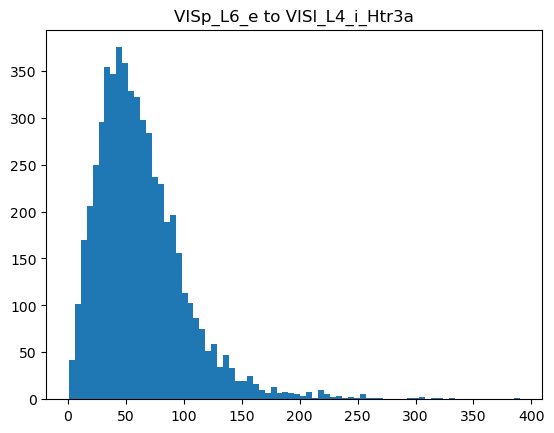

In [540]:
fig = plt.figure()
n, bins, patches = plt.hist(intersomatic_distances, bins=NBR_BINS, align='mid')
plt.title(f'{source_pop_name} to {target_pop_name}')
plt.show()

In [541]:
centered_bins = bins[:-1] + (bins[1]-bins[0])/2

areas = np.pi*(bins[1:]**2 - bins[:-1]**2)
        
non_zero_bins_mask = (n!=0)
n = n[non_zero_bins_mask]
centered_bins = centered_bins[non_zero_bins_mask]
areas = areas[non_zero_bins_mask]

rho = n/areas

def gaussian_func(r, a, sigma):
    return a*np.exp(-r**2/sigma**2)

popt, pcov = curve_fit(gaussian_func, centered_bins, rho, p0=np.array([1, 75]),
                      method='lm')

In [542]:
popt

array([ 0.38605447, 66.33729222])

In [543]:
gaussian_func(75, popt[0], popt[1])

0.10752831748475464

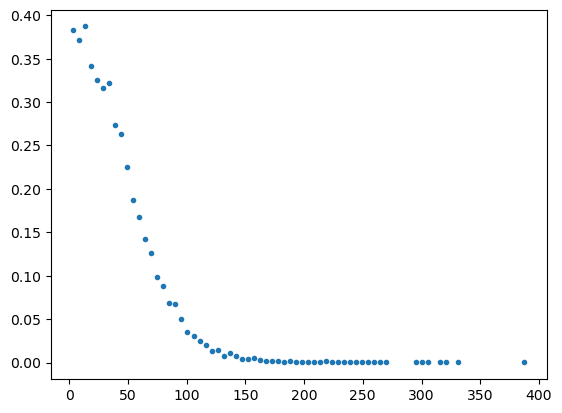

In [538]:
plt.plot(centered_bins, rho, '.')
plt.show()

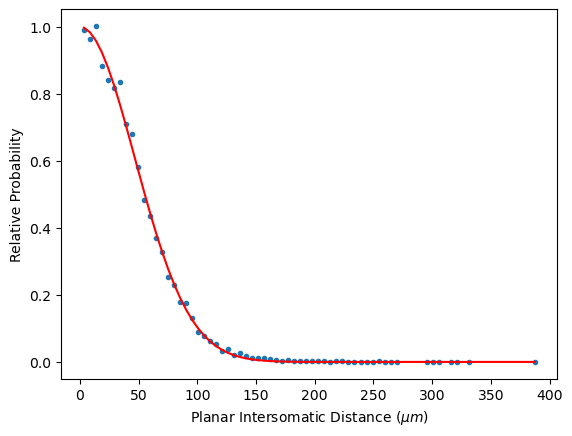

In [545]:
ym = gaussian_func(centered_bins, popt[0], popt[1])
# ym = exp_func(centered_bins, popt[0], popt[1])

fig = plt.figure()
plt.plot(centered_bins, rho/popt[0], '.')
plt.plot(centered_bins, ym/popt[0], c='r', label='Best fit')
plt.ylabel('Relative Probability')
plt.xlabel(r'Planar Intersomatic Distance ($\mu m$)')
plt.show()

In [549]:
gaussian_func(75, 1, popt[1])

0.2785314691843764

In [547]:
centered_bins

array([  3.40993343,   8.53031   ,  13.65068656,  18.77106312,
        23.89143968,  29.01181625,  34.13219281,  39.25256937,
        44.37294594,  49.4933225 ,  54.61369906,  59.73407563,
        64.85445219,  69.97482875,  75.09520532,  80.21558188,
        85.33595844,  90.45633501,  95.57671157, 100.69708813,
       105.8174647 , 110.93784126, 116.05821782, 121.17859438,
       126.29897095, 131.41934751, 136.53972407, 141.66010064,
       146.7804772 , 151.90085376, 157.02123033, 162.14160689,
       167.26198345, 172.38236002, 177.50273658, 182.62311314,
       187.74348971, 192.86386627, 197.98424283, 203.1046194 ,
       208.22499596, 213.34537252, 218.46574908, 223.58612565,
       228.70650221, 233.82687877, 238.94725534, 244.0676319 ,
       249.18800846, 254.30838503, 259.42876159, 264.54913815,
       269.66951472, 295.27139753, 300.3917741 , 305.51215066,
       315.75290378, 320.87328035, 331.11403347, 387.43817567])

In [548]:
ym

array([3.85035754e-01, 3.79723396e-01, 3.70048583e-01, 3.56348740e-01,
       3.39091420e-01, 3.18847830e-01, 2.96261504e-01, 2.72014511e-01,
       2.46793669e-01, 2.21259053e-01, 1.96016746e-01, 1.71597277e-01,
       1.48440600e-01, 1.26887869e-01, 1.07179715e-01, 8.94602658e-02,
       7.37858122e-02, 6.01368440e-02, 4.84321217e-02, 3.85435266e-02,
       3.03105973e-02, 2.35538895e-02, 1.80865554e-02, 1.37237939e-02,
       1.02900528e-02, 7.62405653e-03, 5.58186986e-03, 4.03829831e-03,
       2.88696940e-03, 2.03944057e-03, 1.42365587e-03, 9.82028475e-04,
       6.69373064e-04, 4.50855607e-04, 3.00076379e-04, 1.97356410e-04,
       1.28261335e-04, 8.23692986e-05, 5.22709113e-05, 3.27778050e-05,
       2.03106936e-05, 1.24364015e-05, 7.52471067e-06, 4.49893760e-06,
       2.65800152e-06, 1.55176364e-06, 8.95201936e-07, 5.10318773e-07,
       2.87466452e-07, 1.60013964e-07, 8.80143919e-08, 4.78381739e-08,
       2.56933413e-08, 9.60344221e-10, 4.80201455e-10, 2.37271245e-10,
      

In [1]:
source_area

NameError: name 'source_area' is not defined

In [88]:
edges_file = f"Data/VISp_VISl_edges.h5"
edges_h5 = h5py.File(edges_file, mode='r')
edges_source_ids = np.array(edges_h5['edges'][f'right_ipsi_VISp_VISl']['source_node_id'])
edges_target_ids = np.array(edges_h5['edges'][f'right_ipsi_VISp_VISl']['target_node_id'])

In [89]:
source_node_ids = allen_id_to_bbp_id[source_nodes_mask]
target_node_ids = allen_id_to_bbp_id[target_nodes_mask]

In [90]:
source_mask = np.isin(edges_source_ids, source_node_ids)
target_mask = np.isin(edges_target_ids, target_node_ids)
edges_mask = np.logical_and(source_mask, target_mask)

In [91]:
edges_mask.shape, edges_mask.sum()

((97700988,), 38661857)

In [92]:
(bbp_id_to_allen_id[edges_source_ids[edges_mask]]).astype('u4')

array([ 46522,  46522,  46732, ..., 165056, 165127, 351205], dtype=uint32)

In [93]:
bbp_id_to_allen_id

array([    -1,     -1,     -1, ..., 447105, 447106, 447107], dtype=int32)

In [94]:
n_neurons = source_nodes_mask.sum()
# percentage_of_selected_neurons = 0.1
# tf_indices = np.arange(n_neurons)
#selected_tf_indices = np.random.choice(tf_indices, size=int(n_neurons*percentage_of_selected_neurons), replace=False)

V1_df = pd.DataFrame()
V1_df['node_id'] = node_h5['nodes']['VISp_VISl']['node_id'][source_nodes_mask]
V1_df['x'] = node_h5['nodes']['VISp_VISl']['0']['x'][source_nodes_mask]
V1_df['y'] = node_h5['nodes']['VISp_VISl']['0']['y'][source_nodes_mask]
V1_df['z'] = node_h5['nodes']['VISp_VISl']['0']['z'][source_nodes_mask]
V1_df['Visual area'] = 'V1'
# V1_df['color'] = 'r'

In [95]:
# n_neurons = target_nodes_mask.sum()
# percentage_of_selected_neurons = 0.1
# tf_indices = np.arange(n_neurons)
#selected_tf_indices = np.random.choice(tf_indices, size=int(n_neurons*percentage_of_selected_neurons), replace=False)

LM_df = pd.DataFrame()
LM_df['node_id'] = node_h5['nodes']['VISp_VISl']['node_id'][target_nodes_mask]
LM_df['x'] = node_h5['nodes']['VISp_VISl']['0']['x'][target_nodes_mask]
LM_df['y'] = node_h5['nodes']['VISp_VISl']['0']['y'][target_nodes_mask]
LM_df['z'] = node_h5['nodes']['VISp_VISl']['0']['z'][target_nodes_mask]
LM_df['Visual area'] = 'LM'
# LM_df['color'] = 'b'

In [96]:
n_neurons = source_nodes_mask.sum()
percentage_of_selected_neurons = 0.005
tf_indices = np.arange(n_neurons)
selected_tf_indices = np.random.choice(tf_indices, size=int(n_neurons*percentage_of_selected_neurons), replace=False)
V1_subset = V1_df.iloc[selected_tf_indices]

In [110]:
n_neurons = target_nodes_mask.sum()
percentage_of_selected_neurons = 0.005
tf_indices = np.arange(n_neurons)
selected_tf_indices = np.random.choice(tf_indices, size=int(n_neurons*percentage_of_selected_neurons), replace=False)
LM_subset = LM_df.iloc[selected_tf_indices]

In [98]:
edges_df = file_management.load_lzma(f'Source_{source_area}_Target_{target_area}/{source_area}_to_{target_area}_edges_df.lzma')
# edges_df = edges_df[['Source_id', 'Source', 'Target']]
edges_df['Source_id'] = allen_id_to_bbp_id[edges_df['Source_id']]
edges_df['Target_id'] = allen_id_to_bbp_id[edges_df['Target_id']]
edges_df

,Source_id,Source,Target_id,Target
0,8624668,VISp_L2_e,8161215,VISl_L1_i_Htr3a
1,8624668,VISp_L2_e,8161156,VISl_L1_i_Htr3a
2,8624878,VISp_L2_e,8161131,VISl_L1_i_Htr3a
3,8623409,VISp_L2_e,8161195,VISl_L1_i_Htr3a
4,8627509,VISp_L2_e,8161136,VISl_L1_i_Htr3a
...,...,...,...,...
38661852,8744922,VISp_L2_e,8187711,VISl_L4_e
38661853,8742418,VISp_L2_e,8187994,VISl_L4_e
38661854,8742347,VISp_L2_e,8188454,VISl_L4_e
38661855,8742418,VISp_L2_e,8188772,VISl_L4_e


In [99]:
source_ids = list(set(edges_df['Source_id']))

In [101]:
LM_subset

,node_id,x,y,z,Visual area
30912,8192023,5,1918.646453,9148.032806,LM
22299,8183410,5,1772.035731,9301.896672,LM
24870,8185981,5,1537.003724,9132.120223,LM
19978,8181089,5,1930.188933,9199.025378,LM
47400,8208511,5,1911.765616,9001.706564,LM
...,...,...,...,...,...
39785,8200896,5,1893.684220,8856.445594,LM
4516,8165037,5,1688.739363,9633.466319,LM
18202,8179313,5,1931.744954,9422.110847,LM
37760,8198871,5,1956.922127,9009.125188,LM


In [61]:
for sid in np.random.choice(source_ids, size=10, replace=False):
    df1 = LM_df.loc[np.isin(LM_df['node_id'], edges_df['Target_id'].loc[edges_df['Source_id']==sid])]
    df2 = V1_df.loc[V1_df['node_id']==sid]
    df1['Visual area'] = 'LM targets'
    df2['Visual area'] = 'V1 source'
    df1['marker_size'] = 2
    df2['marker_size'] = 10
    V1_subset['marker_size'] = 2
    LM_subset['marker_size'] = 2
    
    representation_df = pd.concat([V1_subset,LM_subset,df1, df2], ignore_index=True, sort=False)
    fig = px.scatter_3d(representation_df, x='x', y='y', z='z', 
                        color='Visual area', size='marker_size',
                        opacity=0.7)

    #fig.update_traces(marker_size = 2)
    fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0)) #, scene_camera=camera)
    fig.write_html(f"Retinotopic_mapping/V1_node_{sid}_to_LM_bbp_model.html")

<ipython-input-61-1bcb73b304e9>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-61-1bcb73b304e9>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-61-1bcb73b304e9>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-61-1bcb73b

<ipython-input-61-1bcb73b304e9>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-61-1bcb73b304e9>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-61-1bcb73b304e9>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-61-1bcb73b

In [ ]:
representation_df

In [ ]:
import plotly.express as px

fig = px.scatter_3d(representation_df, x='x', y='y', z='z', color='Visual area', size='marker_size',
              opacity=0.7)

# labels={'r': 'V1', 'b':'LM'}
# fig.for_each_trace(lambda t: t.update(name = labels[t.name],
#                                       legendgroup = labels[t.name],
#                                       hovertemplate = t.hovertemplate.replace(t.name, labels[t.name])
#                                      )
#                   )
# tight layout
# camera = dict(
#     eye=dict(x=1, y=1, z=0.1)
# )
#fig.update_traces(marker_size = 2)
fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0)) #, scene_camera=camera)

In [20]:
fig.write_html("Model_representation/LM_V1_bbp_model_representation.html")

In [102]:
source_ids = list(set(edges_df['Source_id']))

In [103]:
len(source_ids)

63078

In [22]:
def data_extraction():
    n_samples = 100

    v1_coordinates = pd.DataFrame(0, index=np.arange(n_samples), columns=['x', 'y', 'z'])
    lm_coordinates = pd.DataFrame(0, index=np.arange(n_samples), columns=['x', 'y', 'z'])
    # for idx, sid in enumerate(np.random.choice(source_ids, size=n_samples, replace=False)):
    for idx, sid in enumerate(source_ids[:n_samples]):
#         if idx%100==0:
#             print(idx)
        df1 = LM_df.loc[LM_df['node_id'].isin(edges_df['Target_id'].loc[edges_df['Source_id']==sid])]
        df2 = V1_df.loc[V1_df['node_id']==sid]
        v1_coordinates.iloc[idx] = df2[['x', 'y', 'z']]
        lm_coordinates.iloc[idx] = df1[['x', 'y', 'z']].mean()

In [203]:
# n_samples = len(source_ids)
n_samples = 1500

v1_coordinates = pd.DataFrame(0, index=source_ids[:150], columns=['x', 'y', 'z'])
lm_coordinates = pd.DataFrame(0, index=source_ids[:150], columns=['x', 'y', 'z'])
# for idx, sid in enumerate(np.random.choice(source_ids, size=n_samples, replace=False)):
for idx, sid in enumerate(source_ids[:150]):
    df1 = LM_df.loc[LM_df['node_id'].isin(edges_df['Target_id'].loc[edges_df['Source_id']==sid])]
    df2 = V1_df.loc[V1_df['node_id']==sid]
    v1_coordinates.iloc[idx] = df2[['x', 'y', 'z']]
    lm_coordinates.iloc[idx] = df1[['x', 'y', 'z']].mean()
    
#     v1_coordinates = pd.concat([v1_coordinates, df2[['x', 'y', 'z']]], ignore_index=True, sort=False)
#     lm_coordinates = pd.concat([lm_coordinates, df1[['x', 'y', 'z']].mean().T], ignore_index=True, sort=False)

In [47]:
df2[['x', 'y', 'z']].values

array([[9770.94532505, 1775.27233699, 8252.07867215]])

In [49]:
df1[['x', 'y', 'z']].mean().values

array([9377.86005964, 2217.98013568, 9112.3317975 ])

In [45]:
v1_coordinates

,x,y,z
8912896,9498.602665,1514.619344,8085.014517
8781825,8186.997437,1155.256491,8694.837746
8650756,7976.146799,730.000253,8302.168786
8912901,8993.720158,1726.139105,8655.758476
8781832,8327.544605,1102.323226,8581.102788
8650761,9651.963460,845.185251,7973.929559
8781833,9653.001012,1043.452005,7785.279000
8912906,9133.916514,1512.908578,8041.714789
8912912,8078.261756,1266.154175,7851.433068
8650771,9684.585237,934.756792,8137.634092


In [46]:
v1_coordinates.iloc[1] = df2[['x', 'y', 'z']].values
v1_coordinates

,x,y,z
8912896,9498.602665,1514.619344,8085.014517
8781825,9770.945325,1775.272337,8252.078672
8650756,7976.146799,730.000253,8302.168786
8912901,8993.720158,1726.139105,8655.758476
8781832,8327.544605,1102.323226,8581.102788
8650761,9651.963460,845.185251,7973.929559
8781833,9653.001012,1043.452005,7785.279000
8912906,9133.916514,1512.908578,8041.714789
8912912,8078.261756,1266.154175,7851.433068
8650771,9684.585237,934.756792,8137.634092


In [24]:
file_management.save_lzma(v1_coordinates, 'v1_source_coordinates.lzma', ' ')
file_management.save_lzma(v1_coordinates, 'lm_targets_coordinates.lzma', ' ')

In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [26]:
# get the model
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    model.compile(loss='mae', optimizer='adam')
    return model

In [ ]:
X = v1_coordinates.values
y = lm_coordinates.values
n_inputs, n_outputs = X.shape[1], y.shape[1]

In [80]:
X.min(axis=0)

array([7753.54914028,  511.2792472 , 7400.22933047])

In [81]:
X.max(axis=0)

array([10149.12337107,  2154.07815846,  9135.91055056])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [30]:
# scaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

In [32]:
# get model
model = get_model(n_inputs, n_outputs)
# fit the model on all data
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_test_scaled, y_test), 
                    verbose=2, epochs=10000, callbacks=[es])

Epoch 1/10000
43/43 - 4s - loss: 6705.3779 - val_loss: 6700.9126
Epoch 2/10000
43/43 - 0s - loss: 6704.7119 - val_loss: 6700.1890
Epoch 3/10000
43/43 - 0s - loss: 6703.9624 - val_loss: 6699.3550
Epoch 4/10000
43/43 - 0s - loss: 6703.0942 - val_loss: 6698.3843
Epoch 5/10000
43/43 - 0s - loss: 6702.0757 - val_loss: 6697.2568
Epoch 6/10000
43/43 - 0s - loss: 6700.8921 - val_loss: 6695.9453
Epoch 7/10000
43/43 - 0s - loss: 6699.5112 - val_loss: 6694.4229
Epoch 8/10000
43/43 - 0s - loss: 6697.9209 - val_loss: 6692.6851
Epoch 9/10000
43/43 - 0s - loss: 6696.1016 - val_loss: 6690.7065
Epoch 10/10000
43/43 - 0s - loss: 6694.0454 - val_loss: 6688.4902
Epoch 11/10000
43/43 - 0s - loss: 6691.7451 - val_loss: 6686.0273
Epoch 12/10000
43/43 - 0s - loss: 6689.2080 - val_loss: 6683.3110
Epoch 13/10000
43/43 - 0s - loss: 6686.4243 - val_loss: 6680.3726
Epoch 14/10000
43/43 - 0s - loss: 6683.4028 - val_loss: 6677.1724
Epoch 15/10000
43/43 - 0s - loss: 6680.1206 - val_loss: 6673.7227
Epoch 16/10000
43/4

Epoch 125/10000
43/43 - 0s - loss: 5368.2773 - val_loss: 5349.6641
Epoch 126/10000
43/43 - 0s - loss: 5353.2725 - val_loss: 5334.4614
Epoch 127/10000
43/43 - 0s - loss: 5338.3662 - val_loss: 5319.5391
Epoch 128/10000
43/43 - 0s - loss: 5323.6562 - val_loss: 5304.6636
Epoch 129/10000
43/43 - 0s - loss: 5309.0098 - val_loss: 5289.9561
Epoch 130/10000
43/43 - 0s - loss: 5294.4146 - val_loss: 5275.4326
Epoch 131/10000
43/43 - 0s - loss: 5279.8130 - val_loss: 5260.7466
Epoch 132/10000
43/43 - 0s - loss: 5265.2158 - val_loss: 5245.9551
Epoch 133/10000
43/43 - 0s - loss: 5250.6582 - val_loss: 5231.3335
Epoch 134/10000
43/43 - 0s - loss: 5236.1763 - val_loss: 5216.6328
Epoch 135/10000
43/43 - 0s - loss: 5221.7407 - val_loss: 5202.0200
Epoch 136/10000
43/43 - 0s - loss: 5207.4009 - val_loss: 5187.4111
Epoch 137/10000
43/43 - 0s - loss: 5193.0859 - val_loss: 5172.7886
Epoch 138/10000
43/43 - 0s - loss: 5178.7812 - val_loss: 5158.2769
Epoch 139/10000
43/43 - 0s - loss: 5164.5039 - val_loss: 5143.

Epoch 248/10000
43/43 - 0s - loss: 3317.4348 - val_loss: 3296.4158
Epoch 249/10000
43/43 - 0s - loss: 3296.3516 - val_loss: 3275.3857
Epoch 250/10000
43/43 - 0s - loss: 3275.1899 - val_loss: 3254.1968
Epoch 251/10000
43/43 - 0s - loss: 3253.9185 - val_loss: 3232.7471
Epoch 252/10000
43/43 - 0s - loss: 3232.5518 - val_loss: 3211.2886
Epoch 253/10000
43/43 - 0s - loss: 3211.1111 - val_loss: 3189.7485
Epoch 254/10000
43/43 - 0s - loss: 3189.5156 - val_loss: 3168.1016
Epoch 255/10000
43/43 - 0s - loss: 3167.9133 - val_loss: 3146.4775
Epoch 256/10000
43/43 - 0s - loss: 3146.2593 - val_loss: 3124.7839
Epoch 257/10000
43/43 - 0s - loss: 3124.5151 - val_loss: 3102.9580
Epoch 258/10000
43/43 - 0s - loss: 3102.7971 - val_loss: 3081.1265
Epoch 259/10000
43/43 - 0s - loss: 3080.9543 - val_loss: 3059.1504
Epoch 260/10000
43/43 - 0s - loss: 3059.0916 - val_loss: 3037.1448
Epoch 261/10000
43/43 - 0s - loss: 3037.1311 - val_loss: 3015.3259
Epoch 262/10000
43/43 - 0s - loss: 3015.2776 - val_loss: 2993.

Epoch 371/10000
43/43 - 0s - loss: 1401.6747 - val_loss: 1454.2332
Epoch 372/10000
43/43 - 0s - loss: 1393.0374 - val_loss: 1446.0414
Epoch 373/10000
43/43 - 0s - loss: 1384.4021 - val_loss: 1437.9421
Epoch 374/10000
43/43 - 0s - loss: 1375.7424 - val_loss: 1429.8350
Epoch 375/10000
43/43 - 0s - loss: 1366.9829 - val_loss: 1421.6139
Epoch 376/10000
43/43 - 0s - loss: 1358.4523 - val_loss: 1413.5215
Epoch 377/10000


KeyboardInterrupt: 

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
df_pred = pd.DataFrame(columns=LM_df.columns)
for sid in np.random.choice(source_ids, size=10, replace=False):
    df1 = LM_df.loc[np.isin(LM_df['node_id'], edges_df['Target_id'].loc[edges_df['Source_id']==sid])]
    df2 = V1_df.loc[V1_df['node_id']==sid]
    df_pred[['x', 'y', 'z']] = model.predict(scaler.transform(df2[['x', 'y', 'z']]))
    df_pred['Visual area'] = 'LM prediction'
    df1['Visual area'] = 'LM targets'
    df2['Visual area'] = 'V1 source'
    df_pred['marker_size'] = 10
    df1['marker_size'] = 2
    df2['marker_size'] = 10
    V1_subset['marker_size'] = 2
    LM_subset['marker_size'] = 2
    
    representation_df = pd.concat([V1_subset,LM_subset,df1, df2, df_pred], ignore_index=True, sort=False)
    fig = px.scatter_3d(representation_df, x='x', y='y', z='z', 
                        color='Visual area', size='marker_size',
                        opacity=0.7)

    #fig.update_traces(marker_size = 2)
    fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0)) #, scene_camera=camera)
    fig.write_html(f"Retinotopic_mapping_pred/V1_node_{sid}_to_LM_bbp_model.html")

In [112]:
df_pred = pd.DataFrame(columns=LM_df.columns)
sids = np.random.choice(source_ids, size=5, replace=False)
df2 = V1_df.loc[np.isin(V1_df['node_id'], sids)]
df_pred[['x', 'y', 'z']] = model.predict(scaler.transform(df2[['x', 'y', 'z']]))
df_pred['Visual area'] = sids #'LM prediction'
df2['Visual area'] = sids #'V1 source'
df_pred['marker_size'] = 5
df2['marker_size'] = 5
V1_subset['marker_size'] = 2
LM_subset['marker_size'] = 2

representation_df = pd.concat([V1_subset, LM_subset, df2, df_pred], ignore_index=True, sort=False)
fig = px.scatter_3d(representation_df, x='x', y='y', z='z', 
                    color='Visual area', size='marker_size',
                    opacity=0.7)

#fig.update_traces(marker_size = 2)
fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0)) #, scene_camera=camera)
# fig.write_html(f"Retinotopic_mapping_pred/V1_node_{sid}_to_LM_bbp_model.html")

<ipython-input-112-c88d9487f35b>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-112-c88d9487f35b>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-112-c88d9487f35b>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-112-c88

In [ ]:
source_coordinates = file_management.load_lzma(f'Retinotopic_mapping/VISl_source_coordinates.lzma')

In [ ]:
source_coordinates

In [ ]:
target_coordinates = file_management.load_lzma(f'Retinotopic_mapping/VISl_targets_coordinates.lzma')

In [ ]:
target_coordinates

In [39]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='glorot_normal', activation='relu'))
    model.add(Dense(n_outputs, kernel_initializer='glorot_normal'))
    model.compile(loss='mae', optimizer='adam')
    return model
        
X = v1_coordinates.values
y = lm_coordinates.values
n_inputs, n_outputs = X.shape[1], y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(n_inputs, n_outputs)
print(X_train.shape)
print(X_test.shape)
# scaler
x_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = x_scaler.transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

# y_scaler = MinMaxScaler().fit(y_train)
# y_train_scaled = y_scaler.transform(y_train)
# y_test_scaled = y_scaler.transform(y_test)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

model = get_model(n_inputs, n_outputs)
# fit the model on all data
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_test_scaled, y_test), 
                    verbose=2, epochs=10000, callbacks=[es])

# Path to save results
prediction_path = 'Retinotopic_mapping_pred'
os.makedirs(prediction_path, exist_ok=True)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

3 3
(1350, 3)
(150, 3)
Epoch 1/10000
43/43 - 1s - loss: 6705.5918 - val_loss: 6701.2759
Epoch 2/10000
43/43 - 0s - loss: 6705.2217 - val_loss: 6700.8354
Epoch 3/10000
43/43 - 0s - loss: 6704.6978 - val_loss: 6700.2002
Epoch 4/10000
43/43 - 0s - loss: 6703.9683 - val_loss: 6699.3428
Epoch 5/10000
43/43 - 0s - loss: 6703.0000 - val_loss: 6698.2354
Epoch 6/10000
43/43 - 0s - loss: 6701.7695 - val_loss: 6696.8389
Epoch 7/10000
43/43 - 0s - loss: 6700.2510 - val_loss: 6695.1519
Epoch 8/10000
43/43 - 0s - loss: 6698.4443 - val_loss: 6693.1743
Epoch 9/10000
43/43 - 0s - loss: 6696.3472 - val_loss: 6690.9155
Epoch 10/10000
43/43 - 0s - loss: 6693.9756 - val_loss: 6688.3740
Epoch 11/10000
43/43 - 0s - loss: 6691.3267 - val_loss: 6685.5581
Epoch 12/10000
43/43 - 0s - loss: 6688.4253 - val_loss: 6682.4863
Epoch 13/10000
43/43 - 0s - loss: 6685.2549 - val_loss: 6679.1514
Epoch 14/10000
43/43 - 0s - loss: 6681.8335 - val_loss: 6675.5659
Epoch 15/10000
43/43 - 0s - loss: 6678.1631 - val_loss: 6671.7

Epoch 125/10000
43/43 - 0s - loss: 5252.3647 - val_loss: 5222.4873
Epoch 126/10000
43/43 - 0s - loss: 5233.5498 - val_loss: 5203.4048
Epoch 127/10000
43/43 - 0s - loss: 5215.0820 - val_loss: 5184.6187
Epoch 128/10000
43/43 - 0s - loss: 5196.8027 - val_loss: 5166.1069
Epoch 129/10000
43/43 - 0s - loss: 5178.7783 - val_loss: 5147.9902
Epoch 130/10000
43/43 - 0s - loss: 5160.8022 - val_loss: 5130.0361
Epoch 131/10000
43/43 - 0s - loss: 5143.1519 - val_loss: 5112.3765
Epoch 132/10000
43/43 - 0s - loss: 5125.8008 - val_loss: 5094.9170
Epoch 133/10000
43/43 - 0s - loss: 5108.5776 - val_loss: 5077.8389
Epoch 134/10000
43/43 - 0s - loss: 5091.5728 - val_loss: 5061.1685
Epoch 135/10000
43/43 - 0s - loss: 5074.7227 - val_loss: 5044.5093
Epoch 136/10000
43/43 - 0s - loss: 5057.9990 - val_loss: 5028.0864
Epoch 137/10000
43/43 - 0s - loss: 5041.4766 - val_loss: 5011.8320
Epoch 138/10000
43/43 - 0s - loss: 5025.2183 - val_loss: 4996.2642
Epoch 139/10000
43/43 - 0s - loss: 5009.3223 - val_loss: 4980.

Epoch 248/10000
43/43 - 0s - loss: 3056.4790 - val_loss: 3016.0532
Epoch 249/10000
43/43 - 0s - loss: 3033.8999 - val_loss: 2993.1711
Epoch 250/10000
43/43 - 0s - loss: 3011.2283 - val_loss: 2970.2668
Epoch 251/10000
43/43 - 0s - loss: 2988.5112 - val_loss: 2947.1655
Epoch 252/10000
43/43 - 0s - loss: 2965.6768 - val_loss: 2924.0254
Epoch 253/10000
43/43 - 0s - loss: 2942.8064 - val_loss: 2900.8879
Epoch 254/10000
43/43 - 0s - loss: 2919.9001 - val_loss: 2877.5776
Epoch 255/10000
43/43 - 0s - loss: 2896.8333 - val_loss: 2854.3206
Epoch 256/10000
43/43 - 0s - loss: 2873.8110 - val_loss: 2830.9084
Epoch 257/10000
43/43 - 0s - loss: 2850.6619 - val_loss: 2807.6643
Epoch 258/10000
43/43 - 0s - loss: 2827.5010 - val_loss: 2784.0969
Epoch 259/10000
43/43 - 0s - loss: 2804.1907 - val_loss: 2760.4268
Epoch 260/10000
43/43 - 0s - loss: 2780.8110 - val_loss: 2736.7200
Epoch 261/10000
43/43 - 0s - loss: 2757.3335 - val_loss: 2713.0337
Epoch 262/10000
43/43 - 0s - loss: 2733.7571 - val_loss: 2689.

Epoch 371/10000
43/43 - 0s - loss: 971.3923 - val_loss: 954.5673
Epoch 372/10000
43/43 - 0s - loss: 969.9691 - val_loss: 953.2876
Epoch 373/10000
43/43 - 0s - loss: 968.6096 - val_loss: 952.1246
Epoch 374/10000
43/43 - 0s - loss: 967.2815 - val_loss: 951.0121
Epoch 375/10000
43/43 - 0s - loss: 966.0389 - val_loss: 950.0553
Epoch 376/10000
43/43 - 0s - loss: 964.8939 - val_loss: 949.0109
Epoch 377/10000
43/43 - 0s - loss: 963.7260 - val_loss: 948.0317
Epoch 378/10000
43/43 - 0s - loss: 962.5858 - val_loss: 947.0979
Epoch 379/10000
43/43 - 0s - loss: 961.5014 - val_loss: 946.1957
Epoch 380/10000
43/43 - 0s - loss: 960.4763 - val_loss: 945.2818
Epoch 381/10000
43/43 - 0s - loss: 959.4375 - val_loss: 944.3677
Epoch 382/10000
43/43 - 0s - loss: 958.5145 - val_loss: 943.4415
Epoch 383/10000
43/43 - 0s - loss: 957.5582 - val_loss: 942.4678
Epoch 384/10000
43/43 - 0s - loss: 956.6309 - val_loss: 941.6592
Epoch 385/10000
43/43 - 0s - loss: 955.7773 - val_loss: 940.7422
Epoch 386/10000
43/43 - 0

43/43 - 0s - loss: 844.3856 - val_loss: 830.5758
Epoch 498/10000
43/43 - 0s - loss: 843.3025 - val_loss: 829.5098
Epoch 499/10000
43/43 - 0s - loss: 842.2108 - val_loss: 828.4903
Epoch 500/10000
43/43 - 0s - loss: 841.1398 - val_loss: 827.5377
Epoch 501/10000
43/43 - 0s - loss: 840.0411 - val_loss: 826.4620
Epoch 502/10000
43/43 - 0s - loss: 838.9503 - val_loss: 825.2453
Epoch 503/10000
43/43 - 0s - loss: 837.8958 - val_loss: 824.1675
Epoch 504/10000
43/43 - 0s - loss: 836.8363 - val_loss: 823.0178
Epoch 505/10000
43/43 - 0s - loss: 835.7942 - val_loss: 822.0143
Epoch 506/10000
43/43 - 0s - loss: 834.6527 - val_loss: 821.0364
Epoch 507/10000
43/43 - 0s - loss: 833.5537 - val_loss: 820.0584
Epoch 508/10000
43/43 - 0s - loss: 832.4966 - val_loss: 818.9365
Epoch 509/10000
43/43 - 0s - loss: 831.4135 - val_loss: 817.9108
Epoch 510/10000
43/43 - 0s - loss: 830.3501 - val_loss: 816.7419
Epoch 511/10000
43/43 - 0s - loss: 829.2334 - val_loss: 815.6539
Epoch 512/10000
43/43 - 0s - loss: 828.16

Epoch 624/10000
43/43 - 0s - loss: 701.7430 - val_loss: 689.6801
Epoch 625/10000
43/43 - 0s - loss: 700.5386 - val_loss: 688.4135
Epoch 626/10000
43/43 - 0s - loss: 699.3797 - val_loss: 687.1938
Epoch 627/10000
43/43 - 0s - loss: 698.2102 - val_loss: 686.0334
Epoch 628/10000
43/43 - 0s - loss: 697.0351 - val_loss: 684.8658
Epoch 629/10000
43/43 - 0s - loss: 695.9120 - val_loss: 683.7806
Epoch 630/10000
43/43 - 0s - loss: 694.6912 - val_loss: 682.5404
Epoch 631/10000
43/43 - 0s - loss: 693.4920 - val_loss: 681.4125
Epoch 632/10000
43/43 - 0s - loss: 692.3197 - val_loss: 680.2139
Epoch 633/10000
43/43 - 0s - loss: 691.1544 - val_loss: 678.9019
Epoch 634/10000
43/43 - 0s - loss: 689.9405 - val_loss: 677.7963
Epoch 635/10000
43/43 - 0s - loss: 688.7528 - val_loss: 676.5146
Epoch 636/10000
43/43 - 0s - loss: 687.6021 - val_loss: 675.4239
Epoch 637/10000
43/43 - 0s - loss: 686.4216 - val_loss: 674.1646
Epoch 638/10000
43/43 - 0s - loss: 685.2015 - val_loss: 672.9011
Epoch 639/10000
43/43 - 0

43/43 - 0s - loss: 548.9913 - val_loss: 538.7297
Epoch 751/10000
43/43 - 0s - loss: 547.7612 - val_loss: 537.5737
Epoch 752/10000
43/43 - 0s - loss: 546.4641 - val_loss: 536.2570
Epoch 753/10000
43/43 - 0s - loss: 545.2573 - val_loss: 535.0068
Epoch 754/10000
43/43 - 0s - loss: 543.9553 - val_loss: 533.9354
Epoch 755/10000
43/43 - 0s - loss: 542.7421 - val_loss: 532.6902
Epoch 756/10000
43/43 - 0s - loss: 541.4286 - val_loss: 531.3721
Epoch 757/10000
43/43 - 0s - loss: 540.1400 - val_loss: 530.0650
Epoch 758/10000
43/43 - 0s - loss: 538.8762 - val_loss: 528.9410
Epoch 759/10000
43/43 - 0s - loss: 537.6153 - val_loss: 527.5776
Epoch 760/10000
43/43 - 0s - loss: 536.3187 - val_loss: 526.3970
Epoch 761/10000
43/43 - 0s - loss: 535.0623 - val_loss: 524.9798
Epoch 762/10000
43/43 - 0s - loss: 533.7714 - val_loss: 523.7909
Epoch 763/10000
43/43 - 0s - loss: 532.5493 - val_loss: 522.4301
Epoch 764/10000
43/43 - 0s - loss: 531.2286 - val_loss: 521.3281
Epoch 765/10000
43/43 - 0s - loss: 529.93

Epoch 877/10000
43/43 - 0s - loss: 380.0867 - val_loss: 373.0286
Epoch 878/10000
43/43 - 0s - loss: 378.7077 - val_loss: 371.6872
Epoch 879/10000
43/43 - 0s - loss: 377.3538 - val_loss: 370.1512
Epoch 880/10000
43/43 - 0s - loss: 376.0052 - val_loss: 368.7997
Epoch 881/10000
43/43 - 0s - loss: 374.6230 - val_loss: 367.5061
Epoch 882/10000
43/43 - 0s - loss: 373.2963 - val_loss: 366.1098
Epoch 883/10000
43/43 - 0s - loss: 371.9180 - val_loss: 364.8954
Epoch 884/10000
43/43 - 0s - loss: 370.5264 - val_loss: 363.7075
Epoch 885/10000
43/43 - 0s - loss: 369.1749 - val_loss: 362.4319
Epoch 886/10000
43/43 - 0s - loss: 367.8002 - val_loss: 360.7559
Epoch 887/10000
43/43 - 0s - loss: 366.4579 - val_loss: 359.6343
Epoch 888/10000
43/43 - 0s - loss: 365.0522 - val_loss: 358.3233
Epoch 889/10000
43/43 - 0s - loss: 363.6620 - val_loss: 357.1517
Epoch 890/10000
43/43 - 0s - loss: 362.2815 - val_loss: 355.6418
Epoch 891/10000
43/43 - 0s - loss: 360.8941 - val_loss: 354.2054
Epoch 892/10000
43/43 - 0

Epoch 1003/10000
43/43 - 0s - loss: 209.8745 - val_loss: 208.1106
Epoch 1004/10000
43/43 - 0s - loss: 208.7399 - val_loss: 207.0531
Epoch 1005/10000
43/43 - 0s - loss: 207.5970 - val_loss: 206.0910
Epoch 1006/10000
43/43 - 0s - loss: 206.4925 - val_loss: 204.9070
Epoch 1007/10000
43/43 - 0s - loss: 205.3315 - val_loss: 203.7859
Epoch 1008/10000
43/43 - 0s - loss: 204.2317 - val_loss: 202.5971
Epoch 1009/10000
43/43 - 0s - loss: 203.1469 - val_loss: 201.7130
Epoch 1010/10000
43/43 - 0s - loss: 202.0549 - val_loss: 200.6078
Epoch 1011/10000
43/43 - 0s - loss: 200.9844 - val_loss: 199.5188
Epoch 1012/10000
43/43 - 0s - loss: 199.9455 - val_loss: 198.5979
Epoch 1013/10000
43/43 - 0s - loss: 198.8743 - val_loss: 197.6326
Epoch 1014/10000
43/43 - 0s - loss: 197.8388 - val_loss: 196.5063
Epoch 1015/10000
43/43 - 0s - loss: 196.8213 - val_loss: 195.4944
Epoch 1016/10000
43/43 - 0s - loss: 195.8104 - val_loss: 194.7855
Epoch 1017/10000
43/43 - 0s - loss: 194.8199 - val_loss: 193.6098
Epoch 1018

43/43 - 0s - loss: 150.1862 - val_loss: 151.5244
Epoch 1128/10000
43/43 - 0s - loss: 150.1149 - val_loss: 151.5029
Epoch 1129/10000
43/43 - 0s - loss: 150.0478 - val_loss: 151.4762
Epoch 1130/10000
43/43 - 0s - loss: 149.9744 - val_loss: 151.3873
Epoch 1131/10000
43/43 - 0s - loss: 149.9138 - val_loss: 151.3401
Epoch 1132/10000
43/43 - 0s - loss: 149.8831 - val_loss: 151.3046
Epoch 1133/10000
43/43 - 0s - loss: 149.7816 - val_loss: 151.2784
Epoch 1134/10000
43/43 - 0s - loss: 149.7373 - val_loss: 151.2572
Epoch 1135/10000
43/43 - 0s - loss: 149.6708 - val_loss: 151.2053
Epoch 1136/10000
43/43 - 0s - loss: 149.6044 - val_loss: 151.1496
Epoch 1137/10000
43/43 - 0s - loss: 149.5482 - val_loss: 151.1214
Epoch 1138/10000
43/43 - 0s - loss: 149.4879 - val_loss: 151.0889
Epoch 1139/10000
43/43 - 0s - loss: 149.4375 - val_loss: 151.0340
Epoch 1140/10000
43/43 - 0s - loss: 149.3904 - val_loss: 151.0120
Epoch 1141/10000
43/43 - 0s - loss: 149.3430 - val_loss: 150.9879
Epoch 1142/10000
43/43 - 0s

Epoch 1252/10000
43/43 - 0s - loss: 147.5506 - val_loss: 149.9416
Epoch 1253/10000
43/43 - 0s - loss: 147.5474 - val_loss: 149.8749
Epoch 1254/10000
43/43 - 0s - loss: 147.5759 - val_loss: 149.9408
Epoch 1255/10000
43/43 - 0s - loss: 147.5541 - val_loss: 150.0254
Epoch 1256/10000
43/43 - 0s - loss: 147.5607 - val_loss: 149.9909
Epoch 1257/10000
43/43 - 0s - loss: 147.5396 - val_loss: 149.9070
Epoch 1258/10000
43/43 - 0s - loss: 147.5223 - val_loss: 149.9357
Epoch 1259/10000
43/43 - 0s - loss: 147.5303 - val_loss: 149.8954
Epoch 1260/10000
43/43 - 0s - loss: 147.5087 - val_loss: 150.0103
Epoch 1261/10000
43/43 - 0s - loss: 147.5067 - val_loss: 149.9861
Epoch 1262/10000
43/43 - 0s - loss: 147.4995 - val_loss: 150.0018
Epoch 1263/10000
43/43 - 0s - loss: 147.4989 - val_loss: 149.9822
Epoch 1264/10000
43/43 - 0s - loss: 147.4793 - val_loss: 149.9360
Epoch 1265/10000
43/43 - 0s - loss: 147.4998 - val_loss: 149.9593
Epoch 1266/10000
43/43 - 0s - loss: 147.4945 - val_loss: 149.8814
Epoch 1267

43/43 - 0s - loss: 147.1979 - val_loss: 149.7702
Epoch 1377/10000
43/43 - 0s - loss: 147.1799 - val_loss: 149.8362
Epoch 1378/10000
43/43 - 0s - loss: 147.1581 - val_loss: 149.8606
Epoch 1379/10000
43/43 - 0s - loss: 147.1513 - val_loss: 149.8305
Epoch 1380/10000
43/43 - 0s - loss: 147.1550 - val_loss: 149.8385
Epoch 1381/10000
43/43 - 0s - loss: 147.1518 - val_loss: 149.7997
Epoch 1382/10000
43/43 - 0s - loss: 147.1497 - val_loss: 149.7990
Epoch 1383/10000
43/43 - 0s - loss: 147.1659 - val_loss: 149.7985
Epoch 1384/10000
43/43 - 0s - loss: 147.1361 - val_loss: 149.8265
Epoch 1385/10000
43/43 - 0s - loss: 147.1767 - val_loss: 149.8014
Epoch 1386/10000
43/43 - 0s - loss: 147.1474 - val_loss: 149.8489
Epoch 1387/10000
43/43 - 0s - loss: 147.1427 - val_loss: 149.8362
Epoch 1388/10000
43/43 - 0s - loss: 147.1314 - val_loss: 149.8502
Epoch 1389/10000
43/43 - 0s - loss: 147.1395 - val_loss: 149.7955
Epoch 1390/10000
43/43 - 0s - loss: 147.1108 - val_loss: 149.8046
Epoch 1391/10000
43/43 - 0s

Epoch 1501/10000
43/43 - 0s - loss: 146.6788 - val_loss: 149.5085
Epoch 1502/10000
43/43 - 0s - loss: 146.7001 - val_loss: 149.5151
Epoch 1503/10000
43/43 - 0s - loss: 146.6798 - val_loss: 149.4653
Epoch 1504/10000
43/43 - 0s - loss: 146.6649 - val_loss: 149.4822
Epoch 1505/10000
43/43 - 0s - loss: 146.6716 - val_loss: 149.4782
Epoch 1506/10000
43/43 - 0s - loss: 146.6647 - val_loss: 149.5066
Epoch 1507/10000
43/43 - 0s - loss: 146.6654 - val_loss: 149.4612
Epoch 1508/10000
43/43 - 0s - loss: 146.6526 - val_loss: 149.4560
Epoch 1509/10000
43/43 - 0s - loss: 146.6592 - val_loss: 149.4142
Epoch 1510/10000
43/43 - 0s - loss: 146.6620 - val_loss: 149.4324
Epoch 1511/10000
43/43 - 0s - loss: 146.6445 - val_loss: 149.5186
Epoch 1512/10000
43/43 - 0s - loss: 146.6169 - val_loss: 149.4532
Epoch 1513/10000
43/43 - 0s - loss: 146.6263 - val_loss: 149.4182
Epoch 1514/10000
43/43 - 0s - loss: 146.6468 - val_loss: 149.4556
Epoch 1515/10000
43/43 - 0s - loss: 146.6136 - val_loss: 149.4013
Epoch 1516

43/43 - 0s - loss: 145.6714 - val_loss: 148.5285
Epoch 1626/10000
43/43 - 0s - loss: 145.6515 - val_loss: 148.4941
Epoch 1627/10000
43/43 - 0s - loss: 145.6434 - val_loss: 148.4691
Epoch 1628/10000
43/43 - 0s - loss: 145.6201 - val_loss: 148.4743
Epoch 1629/10000
43/43 - 0s - loss: 145.6186 - val_loss: 148.4577
Epoch 1630/10000
43/43 - 0s - loss: 145.6100 - val_loss: 148.4532
Epoch 1631/10000
43/43 - 0s - loss: 145.6085 - val_loss: 148.4642
Epoch 1632/10000
43/43 - 0s - loss: 145.5790 - val_loss: 148.4103
Epoch 1633/10000
43/43 - 0s - loss: 145.5615 - val_loss: 148.3961
Epoch 1634/10000
43/43 - 0s - loss: 145.5590 - val_loss: 148.3326
Epoch 1635/10000
43/43 - 0s - loss: 145.5205 - val_loss: 148.3984
Epoch 1636/10000
43/43 - 0s - loss: 145.5376 - val_loss: 148.3815
Epoch 1637/10000
43/43 - 0s - loss: 145.5009 - val_loss: 148.3313
Epoch 1638/10000
43/43 - 0s - loss: 145.5000 - val_loss: 148.3264
Epoch 1639/10000
43/43 - 0s - loss: 145.4893 - val_loss: 148.2999
Epoch 1640/10000
43/43 - 0s

Epoch 1750/10000
43/43 - 0s - loss: 143.2367 - val_loss: 146.0344
Epoch 1751/10000
43/43 - 0s - loss: 143.1923 - val_loss: 145.9406
Epoch 1752/10000
43/43 - 0s - loss: 143.1676 - val_loss: 145.9617
Epoch 1753/10000
43/43 - 0s - loss: 143.1438 - val_loss: 145.9299
Epoch 1754/10000
43/43 - 0s - loss: 143.1093 - val_loss: 145.8627
Epoch 1755/10000
43/43 - 0s - loss: 143.0926 - val_loss: 145.8671
Epoch 1756/10000
43/43 - 0s - loss: 143.0507 - val_loss: 145.8248
Epoch 1757/10000
43/43 - 0s - loss: 143.0338 - val_loss: 145.8128
Epoch 1758/10000
43/43 - 0s - loss: 142.9995 - val_loss: 145.7807
Epoch 1759/10000
43/43 - 0s - loss: 142.9565 - val_loss: 145.7587
Epoch 1760/10000
43/43 - 0s - loss: 142.9636 - val_loss: 145.7615
Epoch 1761/10000
43/43 - 0s - loss: 142.9256 - val_loss: 145.6572
Epoch 1762/10000
43/43 - 0s - loss: 142.8766 - val_loss: 145.6540
Epoch 1763/10000
43/43 - 0s - loss: 142.8353 - val_loss: 145.6334
Epoch 1764/10000
43/43 - 0s - loss: 142.8004 - val_loss: 145.5940
Epoch 1765

43/43 - 0s - loss: 137.7635 - val_loss: 140.4088
Epoch 1875/10000
43/43 - 0s - loss: 137.6856 - val_loss: 140.3898
Epoch 1876/10000
43/43 - 0s - loss: 137.6429 - val_loss: 140.2676
Epoch 1877/10000
43/43 - 0s - loss: 137.5718 - val_loss: 140.2002
Epoch 1878/10000
43/43 - 0s - loss: 137.4812 - val_loss: 140.1326
Epoch 1879/10000
43/43 - 0s - loss: 137.4396 - val_loss: 140.0629
Epoch 1880/10000
43/43 - 0s - loss: 137.3589 - val_loss: 139.9962
Epoch 1881/10000
43/43 - 0s - loss: 137.3019 - val_loss: 139.9289
Epoch 1882/10000
43/43 - 0s - loss: 137.2332 - val_loss: 139.8405
Epoch 1883/10000
43/43 - 0s - loss: 137.1777 - val_loss: 139.8300
Epoch 1884/10000
43/43 - 0s - loss: 137.0956 - val_loss: 139.7477
Epoch 1885/10000
43/43 - 0s - loss: 137.0325 - val_loss: 139.6496
Epoch 1886/10000
43/43 - 0s - loss: 136.9618 - val_loss: 139.6190
Epoch 1887/10000
43/43 - 0s - loss: 136.8900 - val_loss: 139.4947
Epoch 1888/10000
43/43 - 0s - loss: 136.8539 - val_loss: 139.4865
Epoch 1889/10000
43/43 - 0s

Epoch 1999/10000
43/43 - 0s - loss: 126.4049 - val_loss: 128.5357
Epoch 2000/10000
43/43 - 0s - loss: 126.2659 - val_loss: 128.4008
Epoch 2001/10000
43/43 - 0s - loss: 126.1496 - val_loss: 128.3155
Epoch 2002/10000
43/43 - 0s - loss: 126.0172 - val_loss: 128.1635
Epoch 2003/10000
43/43 - 0s - loss: 125.9139 - val_loss: 128.0125
Epoch 2004/10000
43/43 - 0s - loss: 125.7922 - val_loss: 127.7836
Epoch 2005/10000
43/43 - 0s - loss: 125.6408 - val_loss: 127.7203
Epoch 2006/10000
43/43 - 0s - loss: 125.5320 - val_loss: 127.5536
Epoch 2007/10000
43/43 - 0s - loss: 125.4064 - val_loss: 127.4826
Epoch 2008/10000
43/43 - 0s - loss: 125.2321 - val_loss: 127.2910
Epoch 2009/10000
43/43 - 0s - loss: 125.1192 - val_loss: 127.2116
Epoch 2010/10000
43/43 - 0s - loss: 124.9859 - val_loss: 127.0160
Epoch 2011/10000
43/43 - 0s - loss: 124.8874 - val_loss: 126.9346
Epoch 2012/10000
43/43 - 0s - loss: 124.7324 - val_loss: 126.7814
Epoch 2013/10000
43/43 - 0s - loss: 124.5906 - val_loss: 126.6601
Epoch 2014

43/43 - 0s - loss: 106.4634 - val_loss: 107.4533
Epoch 2124/10000
43/43 - 0s - loss: 106.2658 - val_loss: 107.2673
Epoch 2125/10000
43/43 - 0s - loss: 106.0816 - val_loss: 107.0203
Epoch 2126/10000
43/43 - 0s - loss: 105.8828 - val_loss: 106.8917
Epoch 2127/10000
43/43 - 0s - loss: 105.7020 - val_loss: 106.6186
Epoch 2128/10000
43/43 - 0s - loss: 105.5151 - val_loss: 106.5000
Epoch 2129/10000
43/43 - 0s - loss: 105.3064 - val_loss: 106.2366
Epoch 2130/10000
43/43 - 0s - loss: 105.1163 - val_loss: 106.0384
Epoch 2131/10000
43/43 - 0s - loss: 104.9287 - val_loss: 105.8257
Epoch 2132/10000
43/43 - 0s - loss: 104.7135 - val_loss: 105.6338
Epoch 2133/10000
43/43 - 0s - loss: 104.5298 - val_loss: 105.3241
Epoch 2134/10000
43/43 - 0s - loss: 104.3870 - val_loss: 105.3275
Epoch 2135/10000
43/43 - 0s - loss: 104.1289 - val_loss: 104.9665
Epoch 2136/10000
43/43 - 0s - loss: 103.9438 - val_loss: 104.7791
Epoch 2137/10000
43/43 - 0s - loss: 103.7670 - val_loss: 104.5527
Epoch 2138/10000
43/43 - 0s

43/43 - 0s - loss: 84.7924 - val_loss: 84.2216
Epoch 2251/10000
43/43 - 0s - loss: 84.6487 - val_loss: 84.0475
Epoch 2252/10000
43/43 - 0s - loss: 84.5417 - val_loss: 83.9810
Epoch 2253/10000
43/43 - 0s - loss: 84.4126 - val_loss: 83.8188
Epoch 2254/10000
43/43 - 0s - loss: 84.3082 - val_loss: 83.8123
Epoch 2255/10000
43/43 - 0s - loss: 84.1836 - val_loss: 83.5908
Epoch 2256/10000
43/43 - 0s - loss: 84.0985 - val_loss: 83.5006
Epoch 2257/10000
43/43 - 0s - loss: 83.9574 - val_loss: 83.4979
Epoch 2258/10000
43/43 - 0s - loss: 83.8243 - val_loss: 83.3676
Epoch 2259/10000
43/43 - 0s - loss: 83.7578 - val_loss: 83.2906
Epoch 2260/10000
43/43 - 0s - loss: 83.6211 - val_loss: 83.1452
Epoch 2261/10000
43/43 - 0s - loss: 83.5157 - val_loss: 82.9821
Epoch 2262/10000
43/43 - 0s - loss: 83.4548 - val_loss: 82.8554
Epoch 2263/10000
43/43 - 0s - loss: 83.3240 - val_loss: 82.7821
Epoch 2264/10000
43/43 - 0s - loss: 83.1977 - val_loss: 82.7728
Epoch 2265/10000
43/43 - 0s - loss: 83.1298 - val_loss: 8

Epoch 2379/10000
43/43 - 0s - loss: 76.5767 - val_loss: 76.5364
Epoch 2380/10000
43/43 - 0s - loss: 76.5510 - val_loss: 76.5795
Epoch 2381/10000
43/43 - 0s - loss: 76.5000 - val_loss: 76.2089
Epoch 2382/10000
43/43 - 0s - loss: 76.4852 - val_loss: 76.3011
Epoch 2383/10000
43/43 - 0s - loss: 76.4720 - val_loss: 76.3068
Epoch 2384/10000
43/43 - 0s - loss: 76.4429 - val_loss: 76.3215
Epoch 2385/10000
43/43 - 0s - loss: 76.4322 - val_loss: 76.4301
Epoch 2386/10000
43/43 - 0s - loss: 76.4017 - val_loss: 76.3344
Epoch 2387/10000
43/43 - 0s - loss: 76.3864 - val_loss: 76.2797
Epoch 2388/10000
43/43 - 0s - loss: 76.3673 - val_loss: 76.2842
Epoch 2389/10000
43/43 - 0s - loss: 76.3560 - val_loss: 76.2118
Epoch 2390/10000
43/43 - 0s - loss: 76.3267 - val_loss: 76.4425
Epoch 2391/10000
43/43 - 0s - loss: 76.3217 - val_loss: 76.3364
Epoch 2392/10000
43/43 - 0s - loss: 76.2739 - val_loss: 76.2380
Epoch 2393/10000
43/43 - 0s - loss: 76.2404 - val_loss: 76.1461
Epoch 2394/10000
43/43 - 0s - loss: 76.2

43/43 - 0s - loss: 75.0984 - val_loss: 75.2310
Epoch 2508/10000
43/43 - 0s - loss: 75.1077 - val_loss: 75.3095
Epoch 2509/10000
43/43 - 0s - loss: 75.0877 - val_loss: 75.3691
Epoch 2510/10000
43/43 - 0s - loss: 75.0748 - val_loss: 75.4463
Epoch 2511/10000
43/43 - 0s - loss: 75.0718 - val_loss: 75.3619
Epoch 2512/10000
43/43 - 0s - loss: 75.0814 - val_loss: 75.3656
Epoch 2513/10000
43/43 - 0s - loss: 75.0678 - val_loss: 75.2278
Epoch 2514/10000
43/43 - 0s - loss: 75.1024 - val_loss: 75.2836
Epoch 2515/10000
43/43 - 0s - loss: 75.0641 - val_loss: 75.2213
Epoch 2516/10000
43/43 - 0s - loss: 75.0602 - val_loss: 75.1561
Epoch 2517/10000
43/43 - 0s - loss: 75.0620 - val_loss: 75.4138
Epoch 2518/10000
43/43 - 0s - loss: 75.0683 - val_loss: 75.2775
Epoch 2519/10000
43/43 - 0s - loss: 75.0689 - val_loss: 75.3728
Epoch 2520/10000
43/43 - 0s - loss: 75.0216 - val_loss: 75.2273
Epoch 2521/10000
43/43 - 0s - loss: 75.0375 - val_loss: 75.3372
Epoch 2522/10000
43/43 - 0s - loss: 75.0547 - val_loss: 7

Epoch 2636/10000
43/43 - 0s - loss: 74.3870 - val_loss: 74.6914
Epoch 2637/10000
43/43 - 0s - loss: 74.4529 - val_loss: 74.5969
Epoch 2638/10000
43/43 - 0s - loss: 74.3729 - val_loss: 74.3137
Epoch 2639/10000
43/43 - 0s - loss: 74.3716 - val_loss: 74.5065
Epoch 2640/10000
43/43 - 0s - loss: 74.3725 - val_loss: 74.4389
Epoch 2641/10000
43/43 - 0s - loss: 74.3844 - val_loss: 74.4590
Epoch 2642/10000
43/43 - 0s - loss: 74.3745 - val_loss: 74.3606
Epoch 2643/10000
43/43 - 0s - loss: 74.3677 - val_loss: 74.3068
Epoch 2644/10000
43/43 - 0s - loss: 74.4007 - val_loss: 74.6027
Epoch 2645/10000
43/43 - 0s - loss: 74.3613 - val_loss: 74.5260
Epoch 2646/10000
43/43 - 0s - loss: 74.3275 - val_loss: 74.3152
Epoch 2647/10000
43/43 - 0s - loss: 74.3295 - val_loss: 74.5576
Epoch 2648/10000
43/43 - 0s - loss: 74.3737 - val_loss: 74.3070
Epoch 2649/10000
43/43 - 0s - loss: 74.3439 - val_loss: 74.5048
Epoch 2650/10000
43/43 - 0s - loss: 74.3224 - val_loss: 74.5160
Epoch 2651/10000
43/43 - 0s - loss: 74.3

43/43 - 0s - loss: 73.5588 - val_loss: 73.3009
Epoch 2765/10000
43/43 - 0s - loss: 73.5637 - val_loss: 73.2763
Epoch 2766/10000
43/43 - 0s - loss: 73.5352 - val_loss: 73.3237
Epoch 2767/10000
43/43 - 0s - loss: 73.5334 - val_loss: 73.4646
Epoch 2768/10000
43/43 - 0s - loss: 73.5332 - val_loss: 73.2904
Epoch 2769/10000
43/43 - 0s - loss: 73.5572 - val_loss: 73.5790
Epoch 2770/10000
43/43 - 0s - loss: 73.5125 - val_loss: 73.3012
Epoch 2771/10000
43/43 - 0s - loss: 73.4871 - val_loss: 73.4332
Epoch 2772/10000
43/43 - 0s - loss: 73.4959 - val_loss: 73.2217
Epoch 2773/10000
43/43 - 0s - loss: 73.5113 - val_loss: 73.1774
Epoch 2774/10000
43/43 - 0s - loss: 73.4844 - val_loss: 73.3035
Epoch 2775/10000
43/43 - 0s - loss: 73.4783 - val_loss: 73.2357
Epoch 2776/10000
43/43 - 0s - loss: 73.4783 - val_loss: 73.3456
Epoch 2777/10000
43/43 - 0s - loss: 73.5426 - val_loss: 73.1066
Epoch 2778/10000
43/43 - 0s - loss: 73.4410 - val_loss: 73.2146
Epoch 2779/10000
43/43 - 0s - loss: 73.4707 - val_loss: 7

Epoch 2893/10000
43/43 - 0s - loss: 72.4282 - val_loss: 72.1527
Epoch 2894/10000
43/43 - 0s - loss: 72.4429 - val_loss: 72.0741
Epoch 2895/10000
43/43 - 0s - loss: 72.4245 - val_loss: 71.9447
Epoch 2896/10000
43/43 - 0s - loss: 72.4018 - val_loss: 71.8346
Epoch 2897/10000
43/43 - 0s - loss: 72.4046 - val_loss: 71.9990
Epoch 2898/10000
43/43 - 0s - loss: 72.4251 - val_loss: 72.0980
Epoch 2899/10000
43/43 - 0s - loss: 72.3923 - val_loss: 72.0164
Epoch 2900/10000
43/43 - 0s - loss: 72.3563 - val_loss: 71.9216
Epoch 2901/10000
43/43 - 0s - loss: 72.3563 - val_loss: 72.0464
Epoch 2902/10000
43/43 - 0s - loss: 72.3739 - val_loss: 71.9040
Epoch 2903/10000
43/43 - 0s - loss: 72.3508 - val_loss: 71.7670
Epoch 2904/10000
43/43 - 0s - loss: 72.3346 - val_loss: 71.9499
Epoch 2905/10000
43/43 - 0s - loss: 72.3184 - val_loss: 71.9572
Epoch 2906/10000
43/43 - 0s - loss: 72.4169 - val_loss: 71.8383
Epoch 2907/10000
43/43 - 0s - loss: 72.3302 - val_loss: 71.7616
Epoch 2908/10000
43/43 - 0s - loss: 72.3

43/43 - 0s - loss: 70.9744 - val_loss: 70.3677
Epoch 3022/10000
43/43 - 0s - loss: 70.9721 - val_loss: 70.2452
Epoch 3023/10000
43/43 - 0s - loss: 70.9478 - val_loss: 70.2831
Epoch 3024/10000
43/43 - 0s - loss: 70.9479 - val_loss: 70.3728
Epoch 3025/10000
43/43 - 0s - loss: 70.9215 - val_loss: 70.3385
Epoch 3026/10000
43/43 - 0s - loss: 70.9367 - val_loss: 70.3486
Epoch 3027/10000
43/43 - 0s - loss: 70.8899 - val_loss: 70.1173
Epoch 3028/10000
43/43 - 0s - loss: 70.8858 - val_loss: 70.2500
Epoch 3029/10000
43/43 - 0s - loss: 70.8782 - val_loss: 70.3058
Epoch 3030/10000
43/43 - 0s - loss: 70.8805 - val_loss: 70.1107
Epoch 3031/10000
43/43 - 0s - loss: 70.8625 - val_loss: 70.1391
Epoch 3032/10000
43/43 - 0s - loss: 70.8264 - val_loss: 70.1942
Epoch 3033/10000
43/43 - 0s - loss: 70.8172 - val_loss: 70.3719
Epoch 3034/10000
43/43 - 0s - loss: 70.8165 - val_loss: 70.3566
Epoch 3035/10000
43/43 - 0s - loss: 70.7977 - val_loss: 70.1158
Epoch 3036/10000
43/43 - 0s - loss: 70.7682 - val_loss: 6

Epoch 3150/10000
43/43 - 0s - loss: 69.0667 - val_loss: 68.1105
Epoch 3151/10000
43/43 - 0s - loss: 69.0373 - val_loss: 68.1880
Epoch 3152/10000
43/43 - 0s - loss: 69.0522 - val_loss: 68.3904
Epoch 3153/10000
43/43 - 0s - loss: 69.0262 - val_loss: 68.1006
Epoch 3154/10000
43/43 - 0s - loss: 69.0310 - val_loss: 68.0386
Epoch 3155/10000
43/43 - 0s - loss: 68.9601 - val_loss: 68.1668
Epoch 3156/10000
43/43 - 0s - loss: 68.9684 - val_loss: 68.1228
Epoch 3157/10000
43/43 - 0s - loss: 68.9546 - val_loss: 68.1653
Epoch 3158/10000
43/43 - 0s - loss: 68.9494 - val_loss: 67.9652
Epoch 3159/10000
43/43 - 0s - loss: 68.9076 - val_loss: 68.1429
Epoch 3160/10000
43/43 - 0s - loss: 68.9016 - val_loss: 67.9211
Epoch 3161/10000
43/43 - 0s - loss: 68.9021 - val_loss: 67.9276
Epoch 3162/10000
43/43 - 0s - loss: 68.8698 - val_loss: 67.9110
Epoch 3163/10000
43/43 - 0s - loss: 68.8683 - val_loss: 67.8068
Epoch 3164/10000
43/43 - 0s - loss: 68.8265 - val_loss: 67.7891
Epoch 3165/10000
43/43 - 0s - loss: 68.8

43/43 - 0s - loss: 66.6806 - val_loss: 65.3401
Epoch 3279/10000
43/43 - 0s - loss: 66.6478 - val_loss: 65.3200
Epoch 3280/10000
43/43 - 0s - loss: 66.6238 - val_loss: 65.4339
Epoch 3281/10000
43/43 - 0s - loss: 66.5981 - val_loss: 65.2762
Epoch 3282/10000
43/43 - 0s - loss: 66.6202 - val_loss: 65.2010
Epoch 3283/10000
43/43 - 0s - loss: 66.5737 - val_loss: 65.4058
Epoch 3284/10000
43/43 - 0s - loss: 66.5416 - val_loss: 65.2600
Epoch 3285/10000
43/43 - 0s - loss: 66.5103 - val_loss: 65.2720
Epoch 3286/10000
43/43 - 0s - loss: 66.4958 - val_loss: 65.2508
Epoch 3287/10000
43/43 - 0s - loss: 66.4764 - val_loss: 65.1861
Epoch 3288/10000
43/43 - 0s - loss: 66.4646 - val_loss: 65.1961
Epoch 3289/10000
43/43 - 0s - loss: 66.4318 - val_loss: 65.2354
Epoch 3290/10000
43/43 - 0s - loss: 66.4097 - val_loss: 65.0742
Epoch 3291/10000
43/43 - 0s - loss: 66.4119 - val_loss: 65.0700
Epoch 3292/10000
43/43 - 0s - loss: 66.3713 - val_loss: 64.9333
Epoch 3293/10000
43/43 - 0s - loss: 66.3350 - val_loss: 6

Epoch 3407/10000
43/43 - 0s - loss: 63.8365 - val_loss: 62.0077
Epoch 3408/10000
43/43 - 0s - loss: 63.8563 - val_loss: 62.0938
Epoch 3409/10000
43/43 - 0s - loss: 63.8173 - val_loss: 62.0396
Epoch 3410/10000
43/43 - 0s - loss: 63.7861 - val_loss: 61.8979
Epoch 3411/10000
43/43 - 0s - loss: 63.7701 - val_loss: 61.9207
Epoch 3412/10000
43/43 - 0s - loss: 63.7528 - val_loss: 61.9563
Epoch 3413/10000
43/43 - 0s - loss: 63.7071 - val_loss: 61.8516
Epoch 3414/10000
43/43 - 0s - loss: 63.6993 - val_loss: 61.6590
Epoch 3415/10000
43/43 - 0s - loss: 63.6631 - val_loss: 61.9683
Epoch 3416/10000
43/43 - 0s - loss: 63.6631 - val_loss: 61.8393
Epoch 3417/10000
43/43 - 0s - loss: 63.6452 - val_loss: 61.6665
Epoch 3418/10000
43/43 - 0s - loss: 63.5838 - val_loss: 61.7695
Epoch 3419/10000
43/43 - 0s - loss: 63.6037 - val_loss: 61.7836
Epoch 3420/10000
43/43 - 0s - loss: 63.5648 - val_loss: 61.5555
Epoch 3421/10000
43/43 - 0s - loss: 63.5371 - val_loss: 61.6218
Epoch 3422/10000
43/43 - 0s - loss: 63.5

KeyboardInterrupt: 

In [165]:
lm_coordinates

,x,y,z
8912896,9142.711573,2142.144546,9221.616705
8781825,8912.441163,1939.467658,9481.877502
8650756,8559.699160,1559.579719,9222.854567
8912901,8999.661892,1886.833509,8971.305895
8781832,8690.123949,1659.867417,9138.715567
...,...,...,...
8913112,8700.911166,1970.439044,9227.360512
8782040,8982.733883,1853.421374,9341.146903
8782043,8880.522176,1852.748818,9359.367503
8782044,9312.056899,1851.921073,9153.583060


In [ ]:
np.isnan(y_test_scaled).sum()

In [ ]:
X_test_scaled

In [ ]:
y_train_scaled

In [ ]:
y_test_scaled

In [ ]:
model = get_model(n_inputs, n_outputs)
# fit the model on all data
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_test_scaled, y_test), 
                    verbose=2, epochs=10000)

In [135]:
V1_subset

,node_id,x,y,z,Visual area,marker_size
221823,8814098,8294.903101,930.878311,8063.631868,V1,2
302667,8894942,9192.169311,1020.273155,7615.248348,V1,2
338753,8931028,8864.532634,1718.837956,8605.716575,V1,2
15002,8605278,9443.536901,959.261871,8366.082227,V1,2
189468,8781743,9805.506228,1808.546594,8788.764749,V1,2
...,...,...,...,...,...,...
384200,8976475,8622.558139,1789.567932,8837.140234,V1,2
296288,8888563,9062.424772,1558.223591,8792.192466,V1,2
368854,8961129,8973.161979,1489.902099,7952.516411,V1,2
197044,8789319,10113.917344,1823.878261,8344.350998,V1,2


In [139]:
prueba_df = pd.DataFrame(X, columns=['x', 'y', 'z'])
prueba_df

,x,y,z
0,9498.602665,1514.619344,8085.014517
1,8186.997437,1155.256491,8694.837746
2,7976.146799,730.000253,8302.168786
3,8993.720158,1726.139105,8655.758476
4,8327.544605,1102.323226,8581.102788
...,...,...,...
1495,8581.709886,1633.030269,8443.067581
1496,9068.321959,637.891066,7764.311449
1497,8217.697219,845.172746,8455.757374
1498,8612.060799,1529.406292,8161.775993


In [239]:
representation_df = pd.concat([V1_subset, LM_subset], ignore_index=True, sort=False)
fig = px.scatter_3d(representation_df, x='x', y='y', z='z', 
                    color='Visual area', size='marker_size',
                    opacity=0.7)

#fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0)) #, scene_camera=camera)

os.makedirs('coordinate_system', exist_ok=True)
fig.write_html(f"coordinate_system/original.html")

In [143]:
X = representation_df[['x', 'y', 'z']]
X

,x,y,z
0,8294.903101,930.878311,8063.631868
1,9192.169311,1020.273155,7615.248348
2,8864.532634,1718.837956,8605.716575
3,9443.536901,959.261871,8366.082227
4,9805.506228,1808.546594,8788.764749
...,...,...,...
2230,8948.939973,2079.220876,9012.134104
2231,8883.100220,2073.590257,9007.171723
2232,9321.855788,1740.954149,9403.658385
2233,8862.544920,1807.050109,9154.588013


In [115]:
from sklearn.decomposition import PCA

In [161]:
pca=PCA(3)
pca.fit(X)
print("Principal axes:", pca.components_)
print("Explained variance:", pca.explained_variance_)
print("Mean:", pca.mean_)

Z= representation_df.copy()
Z[['x_trans', 'y_trans', 'z_trans']] = pca.transform(X)
Z['z_trans'] -= Z['z_trans'].max()
Z['z_trans'] *= (-1) 
Z['z_trans'] -= Z['z_trans'].max()

Principal axes: [[-0.85907403 -0.40646425 -0.31109263]
 [ 0.47142679 -0.39158273 -0.79020235]
 [-0.1993705   0.82549971 -0.52801669]]
Explained variance: [433771.53819744 378765.342425    49935.05360043]
Mean: [9182.65639315 1341.42926819 8360.64103419]


In [240]:
fig = px.scatter_3d(Z, x='x_trans', y='y_trans', z='z_trans', 
                    color='Visual area', size='marker_size',
                    opacity=0.7)

#fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0)) #, scene_camera=camera)
os.makedirs('coordinate_system', exist_ok=True)
fig.write_html(f"coordinate_system/pca_transformed.html")

In [156]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [157]:
Z['radius'], Z['rho'] = cart2pol(Z['x_trans'], Z['y_trans'])

In [166]:
v1_coordinates

,x,y,z
8912896,9498.602665,1514.619344,8085.014517
8781825,8186.997437,1155.256491,8694.837746
8650756,7976.146799,730.000253,8302.168786
8912901,8993.720158,1726.139105,8655.758476
8781832,8327.544605,1102.323226,8581.102788
...,...,...,...
8913112,8731.324239,1219.067605,7803.591974
8782040,9191.229796,1087.924623,8190.244352
8782043,8981.305734,1040.611571,7953.948664
8782044,9612.193483,1492.617790,8604.900772


In [204]:
v1_coordinates[['x_trans', 'y_trans', 'z_trans']] = pca.transform(v1_coordinates)
v1_coordinates['z_trans'] -= Z['z_trans'].max()
v1_coordinates['z_trans'] *= (-1) 
v1_coordinates['z_trans'] -= Z['z_trans'].max()

In [205]:
lm_coordinates[['x_trans', 'y_trans', 'z_trans']] = pca.transform(lm_coordinates)
lm_coordinates['z_trans'] -= Z['z_trans'].max()
lm_coordinates['z_trans'] *= (-1) 
lm_coordinates['z_trans'] -= Z['z_trans'].max()

In [211]:
Z

,node_id,x,y,z,Visual area,marker_size,x_trans,y_trans,z_trans
0,8814098,8294.903101,930.878311,8063.631868,V1,2,1021.917448,-23.048677,-533.452455
1,8894942,9192.169311,1020.273155,7615.248348,V1,2,354.252351,719.254882,-665.113443
2,8931028,8864.532634,1718.837956,8605.716575,V1,2,43.647525,-491.418055,-784.115815
3,8605278,9443.536901,959.261871,8366.082227,V1,2,-70.470999,268.336571,-168.180540
4,8781743,9805.506228,1808.546594,8788.764749,V1,2,-858.126744,-227.591346,-573.915401
...,...,...,...,...,...,...,...,...,...
2230,8206248,8948.939973,2079.220876,9012.134104,LM,2,-301.780901,-913.897988,-850.188239
2231,8204246,8883.100220,2073.590257,9007.171723,LM,2,-241.387273,-938.810473,-861.286888
2232,8175335,9321.855788,1740.954149,9403.658385,LM,2,-606.450179,-915.019478,-289.869383
2233,8190247,8862.544920,1807.050109,9154.588013,LM,2,-161.249829,-960.616970,-567.517931


In [207]:
v1_coordinates['node_id'] = 'v1_coordinates'
v1_coordinates['Visual area'] = 'v1_coordinates'
v1_coordinates['marker_size'] = 10

In [208]:
lm_coordinates['node_id'] = 'lm_coordinates'
lm_coordinates['Visual area'] = 'lm_coordinates'
lm_coordinates['marker_size'] = 10

In [209]:
lm_coordinates.iloc[0]

x                 9142.711573
y                 2142.144546
z                 9221.616705
x_trans           -558.989766
y_trans           -1012.72233
z_trans           -214.344524
node_id        lm_coordinates
Visual area    lm_coordinates
marker_size                10
Name: 8912896, dtype: object

In [210]:
X

,x,y,z
0,8294.903101,930.878311,8063.631868
1,9192.169311,1020.273155,7615.248348
2,8864.532634,1718.837956,8605.716575
3,9443.536901,959.261871,8366.082227
4,9805.506228,1808.546594,8788.764749
...,...,...,...
2230,8948.939973,2079.220876,9012.134104
2231,8883.100220,2073.590257,9007.171723
2232,9321.855788,1740.954149,9403.658385
2233,8862.544920,1807.050109,9154.588013


In [212]:
representation_df = pd.concat([Z,v1_coordinates.iloc[:1], lm_coordinates.iloc[:1]], ignore_index=True, sort=False)

fig = px.scatter_3d(representation_df, x='x_trans', y='y_trans', z='z_trans', 
                    color='Visual area', size='marker_size',
                    opacity=0.7)

#fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0)) #, scene_camera=camera)

In [213]:
v1_coordinates

,x,y,z,x_trans,y_trans,z_trans,node_id,Visual area,marker_size
8912896,9498.602665,1514.619344,8085.014517,-256.071433,298.928013,-225.513393,v1_coordinates,v1_coordinates,10
8781825,8186.997437,1155.256491,8694.837746,827.051194,-660.561283,131.641990,v1_coordinates,v1_coordinates,10
8650756,7976.146799,730.000253,8302.168786,1303.195381,-283.150989,233.317730,v1_coordinates,v1_coordinates,10
8912901,8993.720158,1726.139105,8655.758476,-85.869444,-472.917827,-199.419236,v1_coordinates,v1_coordinates,10
8781832,8327.544605,1102.323226,8581.102788,763.208360,-483.702201,143.305389,v1_coordinates,v1_coordinates,10
...,...,...,...,...,...,...,...,...,...
8913112,8731.324239,1219.067605,7803.591974,610.757232,275.326121,-283.104003,v1_coordinates,v1_coordinates,10
8782040,9191.229796,1087.924623,8190.244352,148.684540,237.957632,121.005002,v1_coordinates,v1_coordinates,10
8782043,8981.305734,1040.611571,7953.948664,421.765762,344.242187,-6.558820,v1_coordinates,v1_coordinates,10
8782044,9612.193483,1492.617790,8604.900772,-506.444292,-49.722142,89.804163,v1_coordinates,v1_coordinates,10


In [215]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='glorot_normal', activation='relu'))
    model.add(Dense(n_outputs, kernel_initializer='glorot_normal'))
    model.compile(loss='mae', optimizer='adam')
    return model
        
X = v1_coordinates[['x_trans', 'y_trans']].values
y = lm_coordinates[['x_trans', 'y_trans']].values
n_inputs, n_outputs = X.shape[1], y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(n_inputs, n_outputs)
print(X_train.shape)
print(X_test.shape)
# scaler
x_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = x_scaler.transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

# y_scaler = MinMaxScaler().fit(y_train)
# y_train_scaled = y_scaler.transform(y_train)
# y_test_scaled = y_scaler.transform(y_test)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

model = get_model(n_inputs, n_outputs)
# fit the model on all data
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_test_scaled, y_test), 
                    verbose=2, epochs=1000, callbacks=[es])

# Path to save results
prediction_path = 'Retinotopic_mapping_pred'
os.makedirs(prediction_path, exist_ok=True)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

2 2
(135, 2)
(15, 2)
Epoch 1/1000
5/5 - 1s - loss: 678.2221 - val_loss: 699.0665
Epoch 2/1000
5/5 - 0s - loss: 678.2003 - val_loss: 699.0449
Epoch 3/1000
5/5 - 0s - loss: 678.1787 - val_loss: 699.0229
Epoch 4/1000
5/5 - 0s - loss: 678.1568 - val_loss: 699.0001
Epoch 5/1000
5/5 - 0s - loss: 678.1340 - val_loss: 698.9771
Epoch 6/1000
5/5 - 0s - loss: 678.1109 - val_loss: 698.9533
Epoch 7/1000
5/5 - 0s - loss: 678.0867 - val_loss: 698.9287
Epoch 8/1000
5/5 - 0s - loss: 678.0618 - val_loss: 698.9030
Epoch 9/1000
5/5 - 0s - loss: 678.0360 - val_loss: 698.8765
Epoch 10/1000
5/5 - 0s - loss: 678.0082 - val_loss: 698.8486
Epoch 11/1000
5/5 - 0s - loss: 677.9797 - val_loss: 698.8182
Epoch 12/1000
5/5 - 0s - loss: 677.9490 - val_loss: 698.7868
Epoch 13/1000
5/5 - 0s - loss: 677.9173 - val_loss: 698.7537
Epoch 14/1000
5/5 - 0s - loss: 677.8842 - val_loss: 698.7195
Epoch 15/1000
5/5 - 0s - loss: 677.8495 - val_loss: 698.6833
Epoch 16/1000
5/5 - 0s - loss: 677.8128 - val_loss: 698.6456
Epoch 17/100

Epoch 135/1000
5/5 - 0s - loss: 658.3344 - val_loss: 678.8281
Epoch 136/1000
5/5 - 0s - loss: 658.0251 - val_loss: 678.5118
Epoch 137/1000
5/5 - 0s - loss: 657.7117 - val_loss: 678.1964
Epoch 138/1000
5/5 - 0s - loss: 657.3887 - val_loss: 677.8764
Epoch 139/1000
5/5 - 0s - loss: 657.0712 - val_loss: 677.5527
Epoch 140/1000
5/5 - 0s - loss: 656.7546 - val_loss: 677.2316
Epoch 141/1000
5/5 - 0s - loss: 656.4371 - val_loss: 676.9129
Epoch 142/1000
5/5 - 0s - loss: 656.1224 - val_loss: 676.5895
Epoch 143/1000
5/5 - 0s - loss: 655.8044 - val_loss: 676.2614
Epoch 144/1000
5/5 - 0s - loss: 655.4799 - val_loss: 675.9304
Epoch 145/1000
5/5 - 0s - loss: 655.1504 - val_loss: 675.6021
Epoch 146/1000
5/5 - 0s - loss: 654.8215 - val_loss: 675.2690
Epoch 147/1000
5/5 - 0s - loss: 654.5002 - val_loss: 674.9244
Epoch 148/1000
5/5 - 0s - loss: 654.1552 - val_loss: 674.5842
Epoch 149/1000
5/5 - 0s - loss: 653.8149 - val_loss: 674.2423
Epoch 150/1000
5/5 - 0s - loss: 653.4846 - val_loss: 673.8972
Epoch 15

5/5 - 0s - loss: 602.3276 - val_loss: 621.0774
Epoch 268/1000
5/5 - 0s - loss: 601.8482 - val_loss: 620.5917
Epoch 269/1000
5/5 - 0s - loss: 601.3574 - val_loss: 620.1090
Epoch 270/1000
5/5 - 0s - loss: 600.8588 - val_loss: 619.6238
Epoch 271/1000
5/5 - 0s - loss: 600.3646 - val_loss: 619.1314
Epoch 272/1000
5/5 - 0s - loss: 599.8767 - val_loss: 618.6286
Epoch 273/1000
5/5 - 0s - loss: 599.3540 - val_loss: 618.1349
Epoch 274/1000
5/5 - 0s - loss: 598.8629 - val_loss: 617.6385
Epoch 275/1000
5/5 - 0s - loss: 598.3651 - val_loss: 617.1442
Epoch 276/1000
5/5 - 0s - loss: 597.8739 - val_loss: 616.6473
Epoch 277/1000
5/5 - 0s - loss: 597.3677 - val_loss: 616.1464
Epoch 278/1000
5/5 - 0s - loss: 596.8755 - val_loss: 615.6369
Epoch 279/1000
5/5 - 0s - loss: 596.3582 - val_loss: 615.1324
Epoch 280/1000
5/5 - 0s - loss: 595.8555 - val_loss: 614.6263
Epoch 281/1000
5/5 - 0s - loss: 595.3514 - val_loss: 614.1272
Epoch 282/1000
5/5 - 0s - loss: 594.8587 - val_loss: 613.6265
Epoch 283/1000
5/5 - 0s

Epoch 400/1000
5/5 - 0s - loss: 531.1667 - val_loss: 547.1594
Epoch 401/1000
5/5 - 0s - loss: 530.5853 - val_loss: 546.5665
Epoch 402/1000
5/5 - 0s - loss: 529.9827 - val_loss: 545.9794
Epoch 403/1000
5/5 - 0s - loss: 529.3974 - val_loss: 545.3929
Epoch 404/1000
5/5 - 0s - loss: 528.8104 - val_loss: 544.8107
Epoch 405/1000
5/5 - 0s - loss: 528.2187 - val_loss: 544.2303
Epoch 406/1000
5/5 - 0s - loss: 527.6381 - val_loss: 543.6341
Epoch 407/1000
5/5 - 0s - loss: 527.0389 - val_loss: 543.0420
Epoch 408/1000
5/5 - 0s - loss: 526.4371 - val_loss: 542.4584
Epoch 409/1000
5/5 - 0s - loss: 525.8541 - val_loss: 541.8664
Epoch 410/1000
5/5 - 0s - loss: 525.2582 - val_loss: 541.2723
Epoch 411/1000
5/5 - 0s - loss: 524.6554 - val_loss: 540.6697
Epoch 412/1000
5/5 - 0s - loss: 524.0619 - val_loss: 540.0643
Epoch 413/1000
5/5 - 0s - loss: 523.4669 - val_loss: 539.4589
Epoch 414/1000
5/5 - 0s - loss: 522.8687 - val_loss: 538.8581
Epoch 415/1000
5/5 - 0s - loss: 522.2776 - val_loss: 538.2588
Epoch 41

5/5 - 0s - loss: 450.1761 - val_loss: 469.3929
Epoch 533/1000
5/5 - 0s - loss: 449.5268 - val_loss: 468.7762
Epoch 534/1000
5/5 - 0s - loss: 448.8699 - val_loss: 468.1548
Epoch 535/1000
5/5 - 0s - loss: 448.2166 - val_loss: 467.5365
Epoch 536/1000
5/5 - 0s - loss: 447.5618 - val_loss: 466.9207
Epoch 537/1000
5/5 - 0s - loss: 446.9100 - val_loss: 466.3078
Epoch 538/1000
5/5 - 0s - loss: 446.2541 - val_loss: 465.6904
Epoch 539/1000
5/5 - 0s - loss: 445.5822 - val_loss: 465.0734
Epoch 540/1000
5/5 - 0s - loss: 444.9313 - val_loss: 464.4517
Epoch 541/1000
5/5 - 0s - loss: 444.2757 - val_loss: 463.8298
Epoch 542/1000
5/5 - 0s - loss: 443.6221 - val_loss: 463.2100
Epoch 543/1000
5/5 - 0s - loss: 442.9746 - val_loss: 462.5887
Epoch 544/1000
5/5 - 0s - loss: 442.3262 - val_loss: 461.9682
Epoch 545/1000
5/5 - 0s - loss: 441.6852 - val_loss: 461.3468
Epoch 546/1000
5/5 - 0s - loss: 441.0258 - val_loss: 460.7251
Epoch 547/1000
5/5 - 0s - loss: 440.3841 - val_loss: 460.0995
Epoch 548/1000
5/5 - 0s

Epoch 665/1000
5/5 - 0s - loss: 357.9792 - val_loss: 379.2177
Epoch 666/1000
5/5 - 0s - loss: 357.2254 - val_loss: 378.4749
Epoch 667/1000
5/5 - 0s - loss: 356.4799 - val_loss: 377.7328
Epoch 668/1000
5/5 - 0s - loss: 355.7401 - val_loss: 376.9901
Epoch 669/1000
5/5 - 0s - loss: 354.9893 - val_loss: 376.2482
Epoch 670/1000
5/5 - 0s - loss: 354.2466 - val_loss: 375.4977
Epoch 671/1000
5/5 - 0s - loss: 353.4883 - val_loss: 374.7497
Epoch 672/1000
5/5 - 0s - loss: 352.7377 - val_loss: 373.9995
Epoch 673/1000
5/5 - 0s - loss: 351.9820 - val_loss: 373.2474
Epoch 674/1000
5/5 - 0s - loss: 351.2274 - val_loss: 372.4962
Epoch 675/1000
5/5 - 0s - loss: 350.4727 - val_loss: 371.7424
Epoch 676/1000
5/5 - 0s - loss: 349.7100 - val_loss: 370.9875
Epoch 677/1000
5/5 - 0s - loss: 348.9619 - val_loss: 370.2341
Epoch 678/1000
5/5 - 0s - loss: 348.2202 - val_loss: 369.4823
Epoch 679/1000
5/5 - 0s - loss: 347.4620 - val_loss: 368.7271
Epoch 680/1000
5/5 - 0s - loss: 346.7141 - val_loss: 367.9760
Epoch 68

Epoch 798/1000
5/5 - 0s - loss: 251.5911 - val_loss: 271.5248
Epoch 799/1000
5/5 - 0s - loss: 250.7312 - val_loss: 270.6476
Epoch 800/1000
5/5 - 0s - loss: 249.8768 - val_loss: 269.7727
Epoch 801/1000
5/5 - 0s - loss: 249.0167 - val_loss: 268.8929
Epoch 802/1000
5/5 - 0s - loss: 248.1581 - val_loss: 268.0073
Epoch 803/1000
5/5 - 0s - loss: 247.2997 - val_loss: 267.1222
Epoch 804/1000
5/5 - 0s - loss: 246.4379 - val_loss: 266.2403
Epoch 805/1000
5/5 - 0s - loss: 245.5802 - val_loss: 265.3577
Epoch 806/1000
5/5 - 0s - loss: 244.7245 - val_loss: 264.4726
Epoch 807/1000
5/5 - 0s - loss: 243.8593 - val_loss: 263.5846
Epoch 808/1000
5/5 - 0s - loss: 242.9974 - val_loss: 262.6960
Epoch 809/1000
5/5 - 0s - loss: 242.1266 - val_loss: 261.8043
Epoch 810/1000
5/5 - 0s - loss: 241.2538 - val_loss: 260.9069
Epoch 811/1000
5/5 - 0s - loss: 240.3808 - val_loss: 260.0124
Epoch 812/1000
5/5 - 0s - loss: 239.5076 - val_loss: 259.1222
Epoch 813/1000
5/5 - 0s - loss: 238.6378 - val_loss: 258.2374
Epoch 81

5/5 - 0s - loss: 163.9778 - val_loss: 183.6296
Epoch 931/1000
5/5 - 0s - loss: 163.9458 - val_loss: 183.5792
Epoch 932/1000
5/5 - 0s - loss: 163.9131 - val_loss: 183.5379
Epoch 933/1000
5/5 - 0s - loss: 163.8751 - val_loss: 183.4912
Epoch 934/1000
5/5 - 0s - loss: 163.8359 - val_loss: 183.4585
Epoch 935/1000
5/5 - 0s - loss: 163.8008 - val_loss: 183.4355
Epoch 936/1000
5/5 - 0s - loss: 163.7780 - val_loss: 183.4207
Epoch 937/1000
5/5 - 0s - loss: 163.7500 - val_loss: 183.4181
Epoch 938/1000
5/5 - 0s - loss: 163.7315 - val_loss: 183.4013
Epoch 939/1000
5/5 - 0s - loss: 163.7052 - val_loss: 183.3889
Epoch 940/1000
5/5 - 0s - loss: 163.6737 - val_loss: 183.3709
Epoch 941/1000
5/5 - 0s - loss: 163.6485 - val_loss: 183.3436
Epoch 942/1000
5/5 - 0s - loss: 163.6006 - val_loss: 183.3132
Epoch 943/1000
5/5 - 0s - loss: 163.5679 - val_loss: 183.2759
Epoch 944/1000
5/5 - 0s - loss: 163.5340 - val_loss: 183.2375
Epoch 945/1000
5/5 - 0s - loss: 163.5055 - val_loss: 183.2057
Epoch 946/1000
5/5 - 0s

In [224]:
df_pred = pd.DataFrame(columns=LM_df.columns)
for sid in np.random.choice(source_ids, size=10, replace=False):
    df1 = LM_df.loc[np.isin(LM_df['node_id'], edges_df['Target_id'].loc[edges_df['Source_id']==sid])]
    df2 = V1_df.loc[V1_df['node_id']==sid]
    
    trans_points = pca.transform(df2[['x', 'y', 'z']])
    trans_points[0][2] -= Z['z_trans'].max()
    trans_points[0][2] *= (-1) 
    trans_points[0][2] -= Z['z_trans'].max()
    
    df1[['x_trans', 'y_trans', 'z_trans']] = pca.transform(df1[['x', 'y', 'z']])
    df1['z_trans'] -= Z['z_trans'].max()
    df1['z_trans'] *= (-1) 
    df1['z_trans'] -= Z['z_trans'].max()
    
    df2[['x_trans', 'y_trans', 'z_trans']] = pca.transform(df2[['x', 'y', 'z']])
    df2['z_trans'] -= Z['z_trans'].max()
    df2['z_trans'] *= (-1) 
    df2['z_trans'] -= Z['z_trans'].max()

    df_pred[['x_trans', 'y_trans', 'z_trans']] = model.predict(scaler.transform(trans_points))
    df_pred['Visual area'] = 'LM prediction'
    df1['Visual area'] = 'LM targets'
    df2['Visual area'] = 'V1 source'
    df_pred['marker_size'] = 10
    df1['marker_size'] = 2
    df2['marker_size'] = 10
    V1_subset['marker_size'] = 2
    LM_subset['marker_size'] = 2
    
    representation_df = pd.concat([Z,df1, df2, df_pred], ignore_index=True, sort=False)
    fig = px.scatter_3d(representation_df, x='x_trans', y='y_trans', z='z_trans', 
                        color='Visual area', size='marker_size',
                        opacity=0.7)

    #fig.update_traces(marker_size = 2)
    fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0)) #, scene_camera=camera)
    fig.write_html(f"Retinotopic_mapping_pred_new/V1_node_{sid}_to_LM_bbp_model.html")

<ipython-input-224-2eb70fbc8ef1>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-224-2eb70fbc8ef1>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-224-2eb70fbc8ef1>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-224-

ValueError: in user code:

    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_8 is incompatible with the layer: expected axis -1 of input shape to have value 2 but received input with shape (None, 3)


In [222]:
pca.transform(df2[['x', 'y', 'z']])

array([[  63.79541385, -488.67908754,  175.3639344 ]])

In [223]:
trans_points[0]

array([  63.79541385, -488.67908754,  175.3639344 ])

In [231]:
scaler.transform(trans_points)[0][:2]

array([-14.1272075 ,  -3.40920977])

In [234]:
model.predict([-14.1272075 ,  -3.40920977])

ValueError: in user code:

    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_8 is incompatible with the layer: expected axis -1 of input shape to have value 2 but received input with shape (None, 1)


In [233]:
model.predict(np.array(scaler.transform(trans_points)[0][:2]))

ValueError: in user code:

    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/jgalvan/.conda/envs/predictive_coding/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_8 is incompatible with the layer: expected axis -1 of input shape to have value 2 but received input with shape (None, 1)
